In [4]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [5]:
import random
import numpy as np
import pandas as pd
import igraph
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn import preprocessing
import nltk
import csv
from collections import Counter

from __future__ import division

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import keras
import xgboost as xgb


from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from matplotlib import pyplot as plt


import datetime
import time

In [2]:
nltk.download('punkt') # for tokenization
nltk.download('stopwords')
stpwds = set(nltk.corpus.stopwords.words("english"))
stemmer = nltk.stem.PorterStemmer()

[nltk_data] Downloading package punkt to /Users/sarahlina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sarahlina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# -------Functions definition

In [332]:
def test_classifier(X_train, X_test, y_train, y_test):

    df_recap= pd.DataFrame(np.zeros((2, 7)),columns=['LogReg', 'NaiveBayes','SVM', 'RandomForest', 'GBM', 'XGBoost', 'NNET'],
                       index = ['F1', 'Accuracy'])


    logit = LogisticRegression()
    naiveb = GaussianNB()
    svm_ = SVC()
    rf = RandomForestClassifier()
    gbm = GradientBoostingClassifier()
    xg = xgb.XGBClassifier(max_depth=5, n_estimators=500, learning_rate=0.05)
    nnet = MLPClassifier()
   
    classifiers= [logit, naiveb,svm_,rf,gbm ,xg, nnet]
    idx=0
    for classifier in classifiers: 
        
        model = classifier.fit(X_train, y_train)
        predictions = model.predict(X_test)    
        f1 = f1_score(y_test, predictions)
        accuracy = accuracy_score(y_test, predictions)
        
        df_recap.iloc[0,idx]=np.round(f1,3)
        df_recap.iloc[1,idx]=np.round(accuracy,3)
        idx+=1
    
    return df_recap

# 1. Load data 

In [3]:
with open("../Data/training_set.txt", "r") as f:
    reader = csv.reader(f)
    training_set  = list(reader)
    
training_set = [element[0].split(" ") for element in training_set]
training_set =  pd.DataFrame(training_set, columns=['NodeSrc', 'NodeDest', 'Edge'])
training_set.head(2)

,NodeSrc,NodeDest,Edge
0,9510123,9502114,1
1,9707075,9604178,1


In [4]:
type(training_set.NodeSrc[0])

str

In [5]:
with open("../Data/node_information.csv", "r") as f:
    reader = csv.reader(f)
    node_info  = list(reader)

IDs = [element[0] for element in node_info]
node_info =  pd.DataFrame(node_info, columns=['ID', 'year_pub', 'title','authors','name_journal','abstract'])
node_info.head(2)

,ID,year_pub,title,authors,name_journal,abstract
0,1001,2000,compactification geometry and duality,Paul S. Aspinwall,,these are notes based on lectures given at tas...
1,1002,2000,domain walls and massive gauged supergravity p...,"M. Cvetic, H. Lu, C.N. Pope",Class.Quant.Grav.,we point out that massive gauged supergravity ...


In [6]:
type(node_info.iloc[0,0])

str

In [7]:
with open("../Data/testing_set.txt", "r") as f:
    reader = csv.reader(f)
    testing_set  = list(reader)

testing_set = [element[0].split(" ") for element in testing_set]
testing_set =  pd.DataFrame(testing_set, columns=['NodeSrc', 'NodeDest'])
testing_set.shape

(32648, 2)

In [8]:
testing_set.shape

(32648, 2)

# 2. Pre processing

In [10]:
# randomly select 5% of training set to fit and validate the models 
# 95% of the remaining graph is used to create the graph features
to_keep = random.sample(range(len(training_set)), k=int(round(len(training_set)*0.05)))
dataset_train_val= training_set.iloc[to_keep]
df_rest = training_set.loc[~training_set.index.isin(to_keep)]

In [12]:
df_rest.shape

(584736, 3)

In [13]:
dataset_train_val.shape

(30776, 3)

In [15]:
nodes = df_rest.loc[df_rest['Edge']=='1']
nodes= nodes[['NodeSrc','NodeDest' ]]
nodes.to_csv('../Data/nodes.txt', sep=' ', index=False, header=False)

In [16]:
import networkx as nx
DG=nx.DiGraph(directed=True)
DG=nx.read_edgelist('../Data/nodes.txt', create_using=nx.DiGraph(), nodetype = str)

In [17]:
neighborsDict={}
for n in DG.nodes():
    neighborsDict[n]= list(DG.neighbors(n))

In [18]:
pr = nx.pagerank(DG, alpha=0.7)

### a. Train

In [19]:
my_list = list(zip(dataset_train_val.NodeSrc, dataset_train_val.NodeDest))
dict_pairs = pd.Series( my_list , index=dataset_train_val.index).to_dict()

In [20]:
dataset= pd.DataFrame()
dataset['IDPairs']= dict_pairs.keys()
dataset['overlap_title'] = np.zeros(len(dataset))
dataset['overlap_abstract'] = np.zeros(len(dataset))
dataset['temp_diff'] = np.zeros(len(dataset))
dataset['comm_auth'] = np.zeros(len(dataset))
dataset['cossim_a_tfidf'] = np.zeros(len(dataset))
dataset['cossim_t_tfidf'] = np.zeros(len(dataset))
dataset['lsa_abstract'] = np.zeros(len(dataset))
dataset['lsa_title'] = np.zeros(len(dataset))
dataset['nb_cit_indiv'] = np.zeros(len(dataset)) 

dataset['common_out_neighbors'] = np.zeros(len(dataset))
dataset['common_in_neighbors'] = np.zeros(len(dataset))
dataset['jaccard_sim_out'] = np.zeros(len(dataset))
dataset['jaccard_sim_in'] = np.zeros(len(dataset))
dataset['shortest_path'] = np.zeros(len(dataset))
dataset['page_rank'] = np.zeros(len(dataset))
dataset['node2vec']   = np.zeros(len(dataset))


dataset.head(2)

,IDPairs,overlap_title,overlap_abstract,temp_diff,comm_auth,cossim_a_tfidf,cossim_t_tfidf,lsa_abstract,lsa_title,nb_cit_indiv,common_out_neighbors,common_in_neighbors,jaccard_sim_out,jaccard_sim_in,shortest_path,page_rank,node2vec
0,262151,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,262152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
temp=pd.DataFrame(dict_pairs.values(),columns=['NodeSrc','NodeDest'])
temp['IDPairs']=dict_pairs.keys()
dataset_train_val['IDPairs']=dataset_train_val.index
df_merg=pd.merge(dataset_train_val, temp, on=['IDPairs'])
df_merg=df_merg[['IDPairs','Edge']]

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [37]:
dataset=pd.merge(dataset,df_merg, on='IDPairs')
dataset.head(1)

,IDPairs,overlap_title,overlap_abstract,temp_diff,comm_auth,cossim_a_tfidf,cossim_t_tfidf,lsa_abstract,lsa_title,nb_cit_indiv,...,jaccard_sim_out,jaccard_sim_in,shortest_path,page_rank,node2vec,Edge_x,Edge_y,Edge_x,Edge_y,Edge
0,262151,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0


In [329]:
dataset.drop(['Edge_x','Edge_y','Edge_x','Edge_y'], axis=1, inplace=True)
dataset.head(1)

,IDPairs,overlap_title,overlap_abstract,temp_diff,comm_auth,cossim_a_tfidf,cossim_t_tfidf,lsa_abstract,lsa_title,nb_cit_indiv,common_out_neighbors,common_in_neighbors,jaccard_sim_out,jaccard_sim_in,shortest_path,page_rank,node2vec,Edge
0,262151,5,49,-4,0,0.029064,0.0,0.154641,0.002909,0.0,0,0,0.0,0.0,0,0.000019,0.265133,0


### b. Test

In [38]:
my_list_test = list(zip(testing_set.NodeSrc, testing_set.NodeDest))
dict_pairs_test = pd.Series(my_list_test, index=testing_set.index).to_dict()

In [39]:
dataset_test= pd.DataFrame()
dataset_test['IDPairs']= dict_pairs_test.keys()
dataset_test['overlap_title'] = np.zeros(len(dataset_test))
dataset_test['overlap_abstract'] = np.zeros(len(dataset_test))
dataset_test['temp_diff'] = np.zeros(len(dataset_test))
dataset_test['overlap_title'] = np.zeros(len(dataset_test))
dataset_test['comm_auth'] = np.zeros(len(dataset_test))


dataset_test['overlap_title'] = np.zeros(len(dataset_test))
dataset_test['overlap_abstract'] = np.zeros(len(dataset_test))
dataset_test['temp_diff'] = np.zeros(len(dataset_test))
dataset_test['comm_auth'] = np.zeros(len(dataset_test))
dataset_test['cossim_a_tfidf'] = np.zeros(len(dataset_test))
dataset_test['cossim_t_tfidf'] = np.zeros(len(dataset_test))
dataset_test['lsa_abstract'] = np.zeros(len(dataset_test))
dataset_test['lsa_title'] = np.zeros(len(dataset_test))
dataset_test['nb_cit_indiv'] = np.zeros(len(dataset_test)) 

dataset_test['common_out_neighbors'] = np.zeros(len(dataset_test))
dataset_test['common_in_neighbors'] = np.zeros(len(dataset_test))
dataset_test['jaccard_sim_out'] = np.zeros(len(dataset_test))
dataset_test['jaccard_sim_in'] = np.zeros(len(dataset_test))
dataset_test['shortest_path'] = np.zeros(len(dataset_test))
dataset_test['page_rank'] = np.zeros(len(dataset_test))
dataset_test['node2vec']   = np.zeros(len(dataset_test))

dataset_test.head(2)

,IDPairs,overlap_title,overlap_abstract,temp_diff,comm_auth,cossim_a_tfidf,cossim_t_tfidf,lsa_abstract,lsa_title,nb_cit_indiv,common_out_neighbors,common_in_neighbors,jaccard_sim_out,jaccard_sim_in,shortest_path,page_rank,node2vec
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 3. Features Creation and Modeling

# ----------- Text based Features

## A. Number of overlapping words in the title

In [40]:
def overlap_title(idPair, dict_pairs):
    source = dict_pairs.get(idPair)[0]
    target = dict_pairs.get(idPair)[1] 
    
    source_info = node_info.loc [node_info['ID']==source]
    target_info = node_info.loc [node_info['ID']==target]
    
    #Title
    source_title = source_info.iloc[0,2].lower().split(" ")   
    source_title = [token for token in source_title if token not in stpwds]
    source_title = [stemmer.stem(token) for token in source_title]
      
    target_title = source_info.iloc[0,2].lower().split(" ")
    target_title = [token for token in target_title if token not in stpwds]
    target_title = [stemmer.stem(token) for token in target_title]
    
    return (len(set(source_title).intersection(set(target_title))))

In [41]:
import datetime

time_beg = datetime.datetime.now()
dataset['overlap_title']=map(lambda i: overlap_title(i,dict_pairs), dataset['IDPairs'])
time_end = datetime.datetime.now()
print (time_end-time_beg)

0:03:22.218393


In [42]:
import datetime

time_beg = datetime.datetime.now()
dataset_test['overlap_title']=map(lambda i: overlap_title(i,dict_pairs_test), dataset_test['IDPairs'])
time_end = datetime.datetime.now()

print (time_end-time_beg)

0:03:33.770191


## B. Number of overlapping words in the abstract

In [43]:
def overlap_abstract(idPair,dict_pairs):
    source = dict_pairs.get(idPair)[0]
    target = dict_pairs.get(idPair)[1] 
    
    source_info = node_info.loc [node_info['ID']==source]
    target_info = node_info.loc [node_info['ID']==target]
    
    #Title
    source_abstract = source_info.iloc[0,5].lower().split(" ")   
    source_abstract = [token for token in source_abstract if token not in stpwds]
    source_abstract = [stemmer.stem(token) for token in source_abstract]
      
    target_abstract = source_info.iloc[0,5].lower().split(" ")
    target_abstract = [token for token in target_abstract if token not in stpwds]
    target_abstract = [stemmer.stem(token) for token in target_abstract]
    
    return (len(set(source_abstract).intersection(set(target_abstract))))

In [44]:
import datetime
time_beg = datetime.datetime.now()
dataset['overlap_abstract']=map(lambda i: overlap_abstract(i,dict_pairs), dataset['IDPairs'])
time_end = datetime.datetime.now()
print (time_end-time_beg)

0:07:55.316699


In [45]:
import datetime
time_beg = datetime.datetime.now()
dataset_test['overlap_abstract']=map(lambda i: overlap_abstract(i, dict_pairs_test), dataset_test['IDPairs'])
time_end = datetime.datetime.now()
print (time_end-time_beg)

0:07:38.651756


## C. Temporal distance between the papers

In [46]:
def tmp_dist(idPair,dict_pairs):
    source = dict_pairs.get(idPair)[0]
    target = dict_pairs.get(idPair)[1] 
    
    source_info = node_info.loc [node_info['ID']==source]
    target_info = node_info.loc [node_info['ID']==target]
    
    #Year
    source_year = source_info.iloc[0,1]
    target_year = target_info.iloc[0,1]
 
    return (int(source_year) - int(target_year))

In [47]:
import datetime
time_beg = datetime.datetime.now()
dataset['temp_diff']=map(lambda i: tmp_dist(i,dict_pairs), dataset['IDPairs'])
time_end = datetime.datetime.now()
print (time_end-time_beg)

0:03:13.751692


In [48]:
import datetime
time_beg = datetime.datetime.now()
dataset_test['temp_diff']=map(lambda i: tmp_dist(i, dict_pairs_test), dataset_test['IDPairs'])
time_end = datetime.datetime.now()
print (time_end-time_beg)

0:03:27.026029


## D. Number of common authors

In [49]:
def comm_auth(idPair, dict_pairs):
    source = dict_pairs.get(idPair)[0]
    target = dict_pairs.get(idPair)[1] 
    
    source_info = node_info.loc [node_info['ID']==source]
    target_info = node_info.loc [node_info['ID']==target]
    
    #Authors
    source_auth = source_info.iloc[0,3].split(",")
    target_auth = target_info.iloc[0,3].split(",")
 
    return (len(set(source_auth).intersection(set(target_auth))))

In [50]:
import datetime
time_beg = datetime.datetime.now()
dataset['comm_auth']=map(lambda i: comm_auth(i,dict_pairs), dataset['IDPairs'])
time_end = datetime.datetime.now()
print (time_end-time_beg)

0:03:11.551323


In [51]:
import datetime
time_beg = datetime.datetime.now()
dataset_test['comm_auth']=map(lambda i: comm_auth(i, dict_pairs_test), dataset_test['IDPairs'])
time_end = datetime.datetime.now()
print (time_end-time_beg)

0:03:23.412197


In [330]:
dataset.head(2)

,IDPairs,overlap_title,overlap_abstract,temp_diff,comm_auth,cossim_a_tfidf,cossim_t_tfidf,lsa_abstract,lsa_title,nb_cit_indiv,common_out_neighbors,common_in_neighbors,jaccard_sim_out,jaccard_sim_in,shortest_path,page_rank,node2vec,Edge
0,262151,5,49,-4,0,0.029064,0.000000,0.154641,0.002909,0.0,0,0,0.0,0.0,0,0.000019,0.265133,0
1,262152,6,43,-5,0,0.027387,0.008789,0.250234,0.003163,0.0,0,0,0.0,0.0,0,0.000018,0.220178,0


# -----------------------

### Test the classifiers

In [334]:
col= ['IDPairs','Edge']
colnames=[i for i in dataset.columns if i not in col]
X = dataset[colnames]

print("Features : %s"% list(X))

y = dataset['Edge']
y= map (lambda i: int(i), y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
test_classifier(X_train, X_test, y_train, y_test)

Features : ['overlap_title', 'overlap_abstract', 'temp_diff', 'comm_auth']


,LogReg,NaiveBayes,SVM,RandomForest,GBM,XGBoost,NNET
F1,0.708,0.362,0.797,0.753,0.802,0.799,0.807
Accuracy,0.659,0.550,0.749,0.715,0.756,0.753,0.754


# ---------------------

## E. Cosine distance - TF-IDF

### a. Cosine distance between two TF-IDF abstracts

In [53]:
import gensim

from gensim import corpora
from gensim.models import TfidfModel
from gensim.models import LsiModel
from gensim.similarities import MatrixSimilarity

In [54]:
raw_documents = list(node_info['abstract'])

from nltk.tokenize import word_tokenize
gen_docs = [[w.lower() for w in word_tokenize(text)] 
            for text in raw_documents]

# Creation of dictionary, corpus and TF-IDF model
dictionary = gensim.corpora.Dictionary(gen_docs)
corpus = [dictionary.doc2bow(gen_doc) for gen_doc in gen_docs]
tf_idf = gensim.models.TfidfModel(corpus)

In [55]:
def cossim_abstract(ID,dict_pairs,node_info,dictionary,tf_idf):
    
    doc1=node_info.loc[node_info['ID']==dict_pairs[ID][0],'abstract'].values[0]
    doc2=node_info.loc[node_info['ID']==dict_pairs[ID][1],'abstract'].values[0]

    idx_doc1=node_info.loc[node_info['ID']==dict_pairs[ID][0],'abstract'].index[0]
    idx_doc2=node_info.loc[node_info['ID']==dict_pairs[ID][1],'abstract'].index[0]
    
    vec_bow1 = dictionary.doc2bow(doc1.lower().split())
    vec_bow2 = dictionary.doc2bow(doc2.lower().split())

    return gensim.matutils.cossim(tf_idf[vec_bow1], tf_idf[vec_bow2])

In [56]:
import time
start_time=time.time()
dataset['cossim_a_tfidf']=map(lambda i: cossim_abstract(i,dict_pairs,node_info,dictionary,tf_idf), dataset['IDPairs'])

print("--- %s minutes ---" % (np.float(time.time() - start_time)/60))

--- 6.39624634981 minutes ---


In [57]:
import time
start_time=time.time()

dataset_test['cossim_a_tfidf']=map(lambda i: cossim_abstract(i,dict_pairs_test,node_info,dictionary,tf_idf), dataset_test['IDPairs'])

print("--- %s minutes ---" % (np.float(time.time() - start_time)/60))

--- 6.79252518018 minutes ---


### b. Cosine distance between two TF-IDF titles

In [58]:
raw_documents = list(node_info['title'])

from nltk.tokenize import word_tokenize
gen_docs = [[w.lower() for w in word_tokenize(text)] 
            for text in raw_documents]

# Creation of dictionary, corpus and TF-IDF model
dictionary = gensim.corpora.Dictionary(gen_docs)
corpus = [dictionary.doc2bow(gen_doc) for gen_doc in gen_docs]
tf_idf = gensim.models.TfidfModel(corpus)

In [59]:
def cossim_title(ID,dict_pairs,node_info,dictionary,tf_idf):
    
    doc1=node_info.loc[node_info['ID']==dict_pairs[ID][0],'title'].values[0]
    doc2=node_info.loc[node_info['ID']==dict_pairs[ID][1],'title'].values[0]

    idx_doc1=node_info.loc[node_info['ID']==dict_pairs[ID][0],'title'].index[0]
    idx_doc2=node_info.loc[node_info['ID']==dict_pairs[ID][1],'title'].index[0]
    
    vec_bow1 = dictionary.doc2bow(doc1.lower().split())
    vec_bow2 = dictionary.doc2bow(doc2.lower().split())

    return gensim.matutils.cossim(tf_idf[vec_bow1], tf_idf[vec_bow2])

In [60]:
import time
start_time=time.time()
dataset['cossim_t_tfidf']=np.zeros(len(dataset))
dataset['cossim_t_tfidf']=map(lambda i: cossim_title(i,dict_pairs,node_info,dictionary,tf_idf), dataset['IDPairs'])

print("--- %s minutes ---" % (np.float(time.time() - start_time)/60))

--- 5.61671733459 minutes ---


In [61]:
import time
start_time=time.time()

dataset_test['cossim_t_tfidf']=np.zeros(len(dataset_test))
dataset_test['cossim_t_tfidf']=map(lambda i: cossim_title(i,dict_pairs_test,node_info,dictionary,tf_idf), dataset_test['IDPairs'])

print("--- %s minutes ---" % (np.float(time.time() - start_time)/60))

--- 5.98723323345 minutes ---


# -----------------------

### Test the classifiers

In [335]:
col= ['IDPairs','Edge']
colnames=[i for i in dataset.columns if i not in col]
X = dataset[colnames]

print("Features : %s"% list(X))

y = dataset['Edge']
y= map (lambda i: int(i), y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
test_classifier(X_train, X_test, y_train, y_test)

Features : ['overlap_title', 'overlap_abstract', 'temp_diff', 'comm_auth', 'cossim_a_tfidf', 'cossim_t_tfidf']


,LogReg,NaiveBayes,SVM,RandomForest,GBM,XGBoost,NNET
F1,0.814,0.739,0.800,0.845,0.865,0.864,0.863
Accuracy,0.805,0.765,0.754,0.836,0.854,0.853,0.846


# -----------------------

## F. Latent Semantic Analysis:

In [62]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer

### a. the cosine distance between two LSA abstracts

In [63]:
# compute TFIDF vector of each paper
corpus = set(node_info['abstract'])
vectorizer = TfidfVectorizer(stop_words="english")
features_TFIDF = vectorizer.fit_transform(corpus)

In [64]:
# Fit LSA. Use algorithm = “randomized” for large datasets 
lsa = TruncatedSVD(100, algorithm = 'arpack')
dtm_lsa = lsa.fit_transform(features_TFIDF)
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)

In [65]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(dtm_lsa) * np.asmatrix(dtm_lsa).T) 
save= pd.DataFrame(similarity,index=corpus, columns=corpus)
save.head(1)

,conditions manifestly consistent fock representations of non-central but core-central extensions of the z n graded algebras of functions and vector fields on the n dimensional torus t n are constructed by a kind of renormalization procedure these modules are of lowest-energy type but the energy is not a linear function of the momentum modulo a technical assumption reducibility conditions are proved for the extension of vect t n analogous to the discrete series of virasoro representations,text i show how to compute the exact one-loop thermal correction to the free energy of a soliton the method uses the effective potential as an auxiliary step to ensure that the soliton is quantized around the appropriate vacuum the exact result is then computed using scattering theory techniques and includes all orders in the derivative expansion it can be efficiently combined with a calculation of the exact quantum correction to yield the full free energy to one loop i demonstrate this technique with explicit computations in phi 4 models obtaining the free energy for a kink in 1 1 dimensions and a domain wall in 2 1 dimensions,recently k lee e j weinberg and p yi in cu-tp-739 hep-th 9602167 calculated the asymptotic metric on the moduli space of 1 1 1 bps monopoles and conjectured that it was globally exact i lend support to this conjecture by showing that the metric on the corresponding space of nahm data is the same as the metric they calculate,we address the delocalization of low dimensional d-branes and ns-branes when they are a part of a higher dimensional bps black brane and the homogeneity of the resulting horizon we show that the effective delocalization of such branes is a classical effect that occurs when localized branes are brought together thus the fact that the few known solutions with inhomogeneous horizons are highly singular need not indicate a singularity of generic d and ns-brane states rather these singular solutions are likely to be unphysical as they cannot be constructed from localized branes which are brought together from a finite separation,the normal parity component explicit exact formulas are presented up to fourth order in a strict chiral covariant derivative expansion for the normal parity component of the euclidean effective action of even-dimensional dirac fermions the bosonic background fields considered are scalar pseudo-scalar vector and axial vector no assumptions are made on the internal symmetry group and in particular the scalar and pseudo-scalar fields need not be on the chiral circle,recently the self-tuning mechanism of cancellation of vacuum energy has been proposed in which our universe is a flat 3-brane in a 5-dimensional spacetime in this letter the self-tuning mechanism of dark energy is proposed by considering the cosmological matter in the brane world in our model the bulk scalar field takes the role of the dark energy and its value is slowly varying in time the claim is that even if the enormous amount of vacuum energy exists on the brane we can adjust the present value of the dark energy to be consistent with the current observations in this self-tuning mechanism the existence of the constant of integration associated with the bulk scalar is crucial,as pointed out chiral non-commutative theories exist and examples can be constructed via string theory gauge anomalies require the matter content of individual gauge group factors including u 1 factors to be non-chiral all bad mixed gauge anomalies and also all good e g for pi 0 to gamma gamma abj type flavor anomalies automatically vanish in non-commutative gauge theories we interpret this as being analogous to string theory and an example of uv ir mixing non-commutative gauge theories automatically contain closed string green-schwarz fields which cancel these anomalies,vertices we study the exchange diagrams in the computation of four-point functions of all chiral primary operators in d 4 cn 4 super-yang-mills using ads cft correspondence we i

In [66]:
def cosdist_lsa_abstract(ID,dict_pairs ):    
    abstract1=node_info.loc[node_info['ID']==dict_pairs[ID][0],'abstract'].values[0]
    abstract2=node_info.loc[node_info['ID']==dict_pairs[ID][1],'abstract'].values[0]        
    return save.loc[abstract1][abstract2]
    ataset['lsa_abstract']=np.zeros(len(dataset))

In [67]:
time_beg = datetime.datetime.now()
dataset['lsa_abstract']=map(lambda i: cosdist_lsa_abstract(i, dict_pairs), dataset['IDPairs'])
time_end = datetime.datetime.now()
print (time_end-time_beg)

0:02:50.259837


In [68]:
time_beg = datetime.datetime.now()
dataset_test['lsa_abstract']=map(lambda i: cosdist_lsa_abstract(i, dict_pairs_test), dataset_test['IDPairs'])
time_end = datetime.datetime.now()
print (time_end-time_beg)

0:02:59.249694


### b. the cosine distance between two LSA titles

In [71]:
# compute TFIDF vector of each paper
corpus = set(node_info['title'])
vectorizer = TfidfVectorizer(stop_words="english")
features_TFIDF = vectorizer.fit_transform(corpus)

In [72]:
# Fit LSA. Use algorithm = “randomized” for large datasets 
lsa = TruncatedSVD(100, algorithm = 'arpack')
dtm_lsa = lsa.fit_transform(features_TFIDF)
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)

In [73]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(dtm_lsa) * np.asmatrix(dtm_lsa).T) 
save= pd.DataFrame(similarity,index=corpus, columns=corpus)
save.head(2)

,general static axially-symmetric solutions of 2 1 dimensional,a review of w strings,a remark on field theories on the non-commutative torus,black tori solutions in einstein and 5d gravity,electric-magnetic duality in supersymmetric non-abelian gauge theories,baryon configurations in the uv and ir regions of type 0 string theory,tadpole versus anomaly cancellation in d 4 6 compact iib orientifolds,type-i vacua and brane transmutation,gas of d-branes and hagedorn density of bps states,w infty algebras and incompressibility in the quantum hall effect,...,multi-colour braid-monoid algebras,binding energy of scalar bound state by topologically massive,non-commutative phase and the unitarization of gl p q 2,cp violation including universal one-loop corrections and heterotic,strings from membranes and fivebranes,thermodynamics and statistical mechanics of induced liouville gravity,n 2 supergravity and n 2 super yang-mills theory on general scalar,shape invariant potentials depending on n parameters transformed by,classical versus quantum symmetries for toda theories with a nontrivial,casimir effects in renormalizable quantum field theories
general static axially-symmetric solutions of 2 1 dimensional,1.000000,-0.007687,0.007218,0.522927,-0.002477,0.000695,0.017735,-0.017626,-0.004066,0.000760,...,0.040222,0.055082,-0.026702,0.016449,-0.004321,-0.053075,0.066909,0.004255,0.010231,0.006868
a review of w strings,-0.007687,1.000000,-0.013525,0.009413,0.000035,-0.008714,-0.003009,-0.010254,0.001376,0.004753,...,0.011014,-0.008353,-0.012489,0.010440,0.995024,0.005611,-0.008552,0.007059,-0.007266,-0.001388


In [74]:
def cosdist_lsa_title(ID, dict_pairs):    
    title1=node_info.loc[node_info['ID']==dict_pairs[ID][0],'title'].values[0]
    title2=node_info.loc[node_info['ID']==dict_pairs[ID][1],'title'].values[0]        
    return save.loc[title1][title2]

In [75]:
time_beg = datetime.datetime.now()
dataset['lsa_title']=map(lambda i: cosdist_lsa_title(i, dict_pairs), dataset['IDPairs'])
time_end = datetime.datetime.now()
print (time_end-time_beg)

0:02:54.291672


In [76]:
time_beg = datetime.datetime.now()
dataset_test['lsa_title']=map(lambda i: cosdist_lsa_title(i, dict_pairs_test), dataset_test['IDPairs'])
time_end = datetime.datetime.now()
print (time_end-time_beg)

0:03:00.005432


# -----------------------

### Test the classifiers

In [336]:
col= ['IDPairs','Edge']
colnames=[i for i in dataset.columns if i not in col]
X = dataset[colnames]

print("Features : %s"% list(X))

y = dataset['Edge']
y= map (lambda i: int(i), y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
test_classifier(X_train, X_test, y_train, y_test)

Features : ['overlap_title', 'overlap_abstract', 'temp_diff', 'comm_auth', 'cossim_a_tfidf', 'cossim_t_tfidf', 'lsa_abstract', 'lsa_title']


,LogReg,NaiveBayes,SVM,RandomForest,GBM,XGBoost,NNET
F1,0.853,0.788,0.845,0.871,0.887,0.888,0.884
Accuracy,0.844,0.799,0.825,0.863,0.878,0.879,0.875


# -----------------------

# --------- Graph Based Features 

## G. Number of citations between authors

#### count authors individually + normalization according to the number of combinations of pairs between 2 groups of authors

In [213]:
#Build the dictionary 
start_time=time.time()

auth1=[]
auth2=[]

auth1=[node_info.loc[node_info['ID']== idnode, 'authors'].values[0] for idnode in nodes.NodeSrc]
auth2=[node_info.loc[node_info['ID']== idnode, 'authors'].values[0] for idnode in nodes.NodeDest]


auth1_s = map(lambda i: auth1[i].split(','), range(len(auth1)))
auth1_s[0]= [element for element in auth1_s[0] if len(element)>2]

auth2_s = map(lambda i: auth2[i].split(','), range(len(auth2)))
auth2_s[0]= [element for element in auth2_s[0] if len(element)>2]


auth = list(zip(auth1_s, auth2_s, dict_pairs.keys()))


import itertools
temp=map(lambda i: list(itertools.product(auth[i][0],auth[i][1])), range(len(auth)))
temp=list(itertools.chain.from_iterable(temp))

auth_counter=dict(Counter([i for i in temp]))
print ('%s seconds' % (time.time()-start_time))

1651.59859014 seconds


In [214]:
import time
start_time=time.time()

auth1=[node_info.loc[node_info['ID']==dict_pairs[i][0],'authors'].values[0] for i in dict_pairs.keys()]
auth2=[node_info.loc[node_info['ID']==dict_pairs[i][1],'authors'].values[0] for i in dict_pairs.keys()]

auth1_s = map(lambda i: auth1[i].split(','), range(len(auth1)))
auth2_s = map(lambda i: auth2[i].split(','), range(len(auth2)))
auth = list(zip(auth1_s, auth2_s, dict_pairs.keys()))

print('step 0')
final_auth_indiv=[]
for a in auth:
    print('step 1')
    c = 0
    for b in list(itertools.product(a[0],a[1])):
         if b in auth_counter.keys():
            print(b)
            c = c + auth_counter[b]
    final_auth_indiv.append((a[2],c/len(list(itertools.product(a[0],a[1])))))
      
final_auth_indiv=pd.DataFrame(final_auth_indiv,columns=['IDPairs','nb_cit_indiv'])
dataset['nb_cit_indiv']=final_auth_indiv['nb_cit_indiv']

print ('%s seconds' % (time.time()-start_time))

step 0
step 1
step 1
step 1
step 1
('Samir D. Mathur', '')
(' Alec Matusis', '')
step 1
step 1
step 1
step 1
('', 'Gerald V. Dunne')
step 1
('Am', '')
(' a W. Peet (ITP Santa Barbara)', '')
step 1
step 1
step 1
step 1
step 1
('Marcos Marino', 'Cumrun Vafa')
step 1
step 1
('A. Belhaj', 'David J. Gross')
('A. Belhaj', ' Nikita A. Nekrasov')
step 1
('V. D. Ivashchuk', '')
(' V. N. Melnikov', '')
step 1
(' Leonard Susskind', 'Roberto Emparan')
step 1
step 1
('M. Bershadsky', 'M. Bershadsky')
(' W. Lerche', 'M. Bershadsky')
(' W. Lerche', ' W. Lerche')
(' W. Lerche', ' D. Nemeschansky')
(' W. Lerche', ' N.P. Warner')
(' D. Nemeschansky', ' W. Lerche')
(' N.P. Warner', ' N.P. Warner')
step 1
step 1
('', 'Joseph Polchinski')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('M.Paschke (Univ. Mainz)', '')
step 1
step 1
step 1
step 1
(' Burt A. Ovrut', 'Petr Horava')
(' Burt A. Ovrut', ' Edward Witten')
step 1
step 1
step 1
('Dongsu Bak', 'Jin-Ho Cho')
('Dongs

step 1
(' ', 'Enrique Alvarez')
step 1
('Katrin Becker', 'Renata Kallosh')
step 1
step 1
step 1
(' on Carter', '')
step 1
('G. Takacs (INFN Sez. di Bologna)', '')
(" G.M.T. Watts (King's College", '')
(' ', '')
step 1
('Shinji Mukohyama', ' ')
step 1
("Gianguido Dall'Agata", ' ')
(' Carl Herrmann', ' ')
step 1
step 1
step 1
step 1
step 1
step 1
(' huber', 'Klaus Behrndt')
step 1
step 1
step 1
step 1
('', 'Petr Horava')
('', ' Edward Witten')
step 1
step 1
step 1
(' Gregory Moore', 'R. Dijkgraaf')
(' Gregory Moore', ' E. Verlinde')
(' Gregory Moore', ' H. Verlinde')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('Jan O. Conrad', '')
step 1
step 1
step 1
step 1
('F. Lizzi', ' Satoshi Iso')
('F. Lizzi', ' Hikaru Kawai')
(' R.J. Szabo', 'Nobuyuki Ishibashi')
(' R.J. Szabo', ' Satoshi Iso')
(' R.J. Szabo', ' Hikaru Kawai')
(' R.J. Szabo', ' Yoshihisa Kitazawa')
(' A. Zampini', ' Satoshi Iso')
(' A. Zampini', ' Hikaru Kawai')


step 1
step 1
step 1
step 1
step 1
('Laura Andrianopoli', '')
step 1
('Gottfried Curio', ' Cumrun Vafa')
step 1
step 1
step 1
step 1
('Joseph A. Minahan (IAS)', 'I.R. Klebanov')
('Joseph A. Minahan (IAS)', ' A.A. Tseytlin')
step 1
step 1
(' ', 'C. I. Lazaroiu')
step 1
step 1
step 1
step 1
('Julie D. Blum', '')
(' Kenneth Intriligator', '')
step 1
step 1
('', '')
step 1
('', 'Shamit Kachru')
('', ' Cumrun Vafa')
step 1
('Jian-Ge Zhou', '')
(' F. Zimmerschied', '')
step 1
('Shyamoli Chaudhuri', '')
step 1
step 1
step 1
step 1
('C.J. Efthimiou', '')
(' D.A. Spector', '')
step 1
step 1
step 1
step 1
("Shin'ichi Nojiri", "Shin'ichi Nojiri")
("Shin'ichi Nojiri", ' Sergei D. Odintsov')
("Shin'ichi Nojiri", ' ')
("Shin'ichi Nojiri", ' Sachiko Ogushi')
(' Sergei D. Odintsov', "Shin'ichi Nojiri")
(' Sergei D. Odintsov', ' Sergei D. Odintsov')
(' Sergei D. Odintsov', ' ')
(' Sergei D. Odintsov', ' Sachiko Ogushi')
step 1
('Keshav Dasgupta', ' E. Witten')
step 1
step 1
step 1
('L. Andrianopoli', '

step 1
(' ', 'Jean-Pierre Derendinger')
(' ', ' Roger Sauser')
step 1
('Angel M. Uranga', ' Dieter Lust')
('Angel M. Uranga', ' Douglas J. Smith')
step 1
('Igor B', 'Paolo Pasti')
('Igor B', ' Dmitrij Sorokin')
('Igor B', ' Mario Tonin')
(' os', 'Paolo Pasti')
(' os', ' Dmitrij Sorokin')
(' os', ' Mario Tonin')
(' Kurt Lechner', 'Paolo Pasti')
(' Kurt Lechner', ' Mario Tonin')
(' Alexei Nurmagambetov', 'Paolo Pasti')
(' Alexei Nurmagambetov', ' Mario Tonin')
(' Paolo Pasti', 'Paolo Pasti')
(' Paolo Pasti', ' Dmitrij Sorokin')
(' Paolo Pasti', ' Mario Tonin')
step 1
('', '')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('Nobuyoshi Ohta', '')
(' Jian-Ge Zhou', '')
step 1
step 1
step 1
('M. Chaichian', '')
(' A. Demichev', '')
(' P. Presnajder', '')
step 1
('', ' Amit Giveon')
step 1
('S. James Gates', 'S. James Gates')
(' Jr.', 'S. James Gates')
(' Jr.', ' Jr')
step 1
step 1
step 1
step 1
step 1
step 1
('Bert Schroer (CBPF', '')
step 1
step 1
('Supriya Kar', '')
(' Sudhakar P', '')
(

step 1
step 1
step 1
step 1
('', 'N. Seiberg')
('', ' E. Witten')
step 1
('Barton Zwiebach', '')
step 1
step 1
('', 'Jae-Suk Park')
step 1
step 1
('L. Bonora', '')
(' M. Salizzoni', '')
step 1
step 1
('Changhyun Ahn', ' ')
step 1
step 1
step 1
(' A. Kehagias', 'S.S. Gubser')
(' A. Kehagias', ' I.R. Klebanov')
(' A. Kehagias', ' A.M. Polyakov')
step 1
('Eric G. Gimon', 'Juan M. Maldacena')
step 1
("Shin'ichi Nojiri", ' H. Verlinde')
(' Sergei D. Odintsov', ' H. Verlinde')
(' ', ' E. Verlinde')
(' ', ' H. Verlinde')
(' Sachiko Ogushi', ' H. Verlinde')
step 1
step 1
step 1
step 1
step 1
step 1
('', '')
step 1
('Andrei Linde', '')
step 1
step 1
(' A. Fring', '')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
(' Ashoke Sen', 'R. de Mello Koch')
(' Ashoke Sen', ' A. Jevicki')
(' Ashoke Sen', ' M. Mihailescu')
(' Ashoke Sen', ' R. Tatar')
(' Barton Zwiebach', 'R. de Mello Koch')
(' Barton Zwiebach', ' A. Jevicki')
(' Barton Zwiebach', ' M. Mihailescu')
(' Barton Zwiebach', ' R. Tatar')
step

step 1
('', '')
step 1
step 1
step 1
('C. Gomez (IMAFF', ' Cumrun Vafa')
(' IFT)', ' Cumrun Vafa')
(' R. Hern', ' Cumrun Vafa')
(' ez (IMAFF)', ' Cumrun Vafa')
step 1
step 1
step 1
('Igor B', '')
(' os', '')
(' Wolfgang Kummer', '')
step 1
step 1
step 1
step 1
('Hiroyuki Hata', ' Ashoke Sen')
('Hiroyuki Hata', ' ')
('Hiroyuki Hata', ' Barton Zwiebach')
step 1
('E. Elizalde', '')
(' S.D. Odintsov', '')
step 1
step 1
step 1
step 1
step 1
(' Ulf Lindstr\\"om', '')
(' ', '')
step 1
('', 'M.Bianchi')
('', ' F.Fucito')
('', ' G.C.Rossi')
('', ' M.Martellini')
step 1
step 1
step 1
step 1
('Friedemann Br', 'Friedemann Br')
('Friedemann Br', ' t')
('Friedemann Br', ' Antoine Van Proeyen')
(' t', 'Friedemann Br')
(' t', ' t')
(' t', ' Antoine Van Proeyen')
(' Alex', 'Friedemann Br')
(' Alex', ' t')
(' er Kling', 'Friedemann Br')
(' er Kling', ' t')
(' Maximilian Kreuzer', 'Friedemann Br')
(' Maximilian Kreuzer', ' t')
step 1
step 1
step 1
('Iosif Bena', 'Iosif Bena')
step 1
step 1
step 1
('', 'A

step 1
('A. Gorsky', '')
(' I.I. Kogan', '')
(' G. Korchemsky', '')
step 1
step 1
('W. Lerche', '')
(' S. Stieberger', '')
step 1
step 1
step 1
step 1
('Jan de Boer', ' Cumrun Vafa')
step 1
('', 'Jordi Comellas')
step 1
('P. Baseilhac', '')
(" P. Grang\\'e", '')
(' M. Rausch de Traubenberg', '')
step 1
step 1
step 1
('', 'M. J. Duff')
('', ' James T. Liu')
step 1
step 1
step 1
('E. Dudas', 'E. Dudas')
(' J. Mourad', 'E. Dudas')
(' J. Mourad', ' J. Mourad')
step 1
step 1
step 1
step 1
step 1
('', 'A. Klemm')
('', ' W. Lerche')
('', ' S. Theisen')
('', ' S. Yankielowicz')
step 1
step 1
step 1
('', 'A. Recknagel')
('', ' V. Schomerus')
step 1
('', '')
step 1
step 1
step 1
step 1
(' H. Rhedin', 'S. Katz')
(' H. Rhedin', ' P. Mayr')
(' H. Rhedin', ' C. Vafa')
step 1
step 1
step 1
('', '')
step 1
("I.Ya. Aref'eva", '')
(' I.V. Volovich', '')
step 1
step 1
step 1
step 1
step 1
step 1
(' Angel M. Uranga', 'Michael R. Douglas')
step 1
('', 'C. Klimcik')
step 1
step 1
('', 'Keshav Dasgupta')
(''

('Yasuaki Hikida', ' Radu Roiban')
step 1
step 1
step 1
('Burt A. Ovrut (University of Pennsylvania)', '')
step 1
step 1
('James P. Gregory', ' ')
(' Antonio Padilla', 'S.B. Giddings')
(' Antonio Padilla', ' E. Katz')
(' Antonio Padilla', ' ')
(' Antonio Padilla', ' L. R')
(' Antonio Padilla', ' all')
step 1
('J.L.F. Barbon', '')
(' A. Pasquinucci', '')
step 1
step 1
('Gary T. Horowitz', ' Leonard Susskind')
step 1
step 1
step 1
('', ' G. Lifschytz')
step 1
('Andrew P. Billyard (1)', ' C.N. Pope')
('Andrew P. Billyard (1)', ' K.S. Stelle')
(' Alan A. Coley (1)', ' C.N. Pope')
(' Alan A. Coley (1)', ' K.S. Stelle')
(' James E. Lidsey (2)', ' C.N. Pope')
(' James E. Lidsey (2)', ' K.S. Stelle')
(' Ulf S.', ' C.N. Pope')
(' Ulf S.', ' K.S. Stelle')
step 1
('', '')
step 1
('Rabin Banerjee', 'Rabin Banerjee')
(' Biswajit Chakraborty', 'Rabin Banerjee')
step 1
(' John F. Wheater', 'Ian I. Kogan')
step 1
step 1
('Jan de Boer', 'Clifford V. Johnson')
('Jan de Boer', ' ')
(' Eric Gimon', ' ')
(

step 1
step 1
step 1
step 1
step 1
('', '')
step 1
step 1
step 1
step 1
('B. Pioline (Ecole Polytechnique)', '')
step 1
('D. Cremades', 'Mirjam Cvetic')
('D. Cremades', ' Gary Shiu')
('D. Cremades', ' Angel M. Uranga')
(' L.E. Ibanez', 'Mirjam Cvetic')
(' L.E. Ibanez', ' Gary Shiu')
(' L.E. Ibanez', ' Angel M. Uranga')
(' F. Marchesano', 'Mirjam Cvetic')
(' F. Marchesano', ' Gary Shiu')
(' F. Marchesano', ' Angel M. Uranga')
step 1
step 1
step 1
step 1
('L. Andrianopoli', 'Andrew R. Frey')
('L. Andrianopoli', ' Joseph Polchinski')
(" R. D'Auria", 'Andrew R. Frey')
(" R. D'Auria", ' Joseph Polchinski')
(' S. Ferrara', 'Andrew R. Frey')
(' S. Ferrara', ' Joseph Polchinski')
step 1
step 1
step 1
('Yasuaki Hikida', 'Takahiro Kubota')
('Yasuaki Hikida', ' Jian-Ge Zhou')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('', 'D.V. Boulatov')
step 1
step 1
('P.K. Townsend', '')
step 1
step 1
(' M.P. Mattis (Los Alamos)', 'N. Dorey (Swansea)')
(' M.P. Mattis (Los Alamos)', ' V.V. Khoze (

(' Masashi Naganuma', ' ')
(' Muneto Nitta', ' ')
(' Norisuke Sakai', ' ')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('', 'Ashoke Sen')
step 1
('Daniel F. Litim', '')
step 1
('Xavier Bekaert', 'John H. Schwarz')
('Xavier Bekaert', ' Ashoke Sen')
(' Sorin Cucu', 'John H. Schwarz')
(' Sorin Cucu', ' Ashoke Sen')
step 1
step 1
step 1
(' oren', ' P.H. Damgaard')
step 1
step 1
step 1
('', 'Piljin Yi')
step 1
step 1
step 1
step 1
step 1
(' A. Kaya', 'Klaus Behrndt')
(' P. Sundell', 'Klaus Behrndt')
step 1
('Valentina Riva', 'Subir Ghoshal')
('Valentina Riva', ' Alex')
('Valentina Riva', ' er Zamolodchikov')
step 1
('Zurab Kakushadze', 'Zurab Kakushadze')
('Zurab Kakushadze', ' S.-H. Henry Tye')
(' Gary Shiu', 'Zurab Kakushadze')
(' Gary Shiu', ' S.-H. Henry Tye')
(' S.-H. Henry Tye', 'Zurab Kakushadze')
(' S.-H. Henry Tye', ' S.-H. Henry Tye')
step 1
step 1
step 1
step 1
(' ', ' M. Talon')
step 1
step 1
step 1
step 1
step 1
('', 'Bong H. Lian')
('', ' Gregg J. Zuckerman')
step 1
(' Ti

(' re', ' Y.J. Ng')
step 1
('J. M. F. Labastida', 'J. M. F. Labastida')
('J. M. F. Labastida', ' Esther Perez')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('E. Sezgin', '')
(' P. Sundell', '')
step 1
('', 'Avinash Khare')
('', ' ')
step 1
step 1
('', 'G. McCartor')
('', ' D. G. Robertson')
('', ' S. S. Pinsky')
step 1
('Robert C. Myers', '')
(' Oyvind Tafjord', '')
step 1
step 1
step 1
('R. Banerjee', '')
(' C. Wotzasek', '')
step 1
step 1
step 1
step 1
step 1
('', 'R. Brustein')
('', ' M. Gasperini')
('', ' G. Veneziano')
step 1
('', 'Michael R. Douglas')
('', ' Gregory Moore')
step 1
step 1
step 1
step 1
step 1
step 1
(' Piljin Yi', '')
step 1
step 1
('M. Cvetic', "Shin'ichi Nojiri")
('M. Cvetic', ' Sergei D. Odintsov')
(' S. Nojiri', "Shin'ichi Nojiri")
(' S. Nojiri', ' Sergei D. Odintsov')
(' S.D. Odintsov', "Shin'ichi Nojiri")
(' S.D. Odintsov', ' Sergei D. Odintsov')
step 1
step 1
('', '')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('Sergio

step 1
step 1
step 1
('Taejin Lee', '')
(' K. S. Viswanathan', '')
step 1
step 1
step 1
step 1
step 1
step 1
('', '')
step 1
step 1
step 1
('U. Ellwanger', '')
(' N. Wschebor', '')
step 1
('Avinash Dhar', '')
(' Gautam M', '')
(' al', '')
(' Spenta R. Wadia', '')
step 1
step 1
step 1
step 1
(' Sergei D. Odintsov', 'Raphael Bousso')
(' Sergei D. Odintsov', ' Stephen Hawking (DAMTP')
(' Sergei D. Odintsov', ' Cambridge)')
step 1
('', 'S. Ferrara')
step 1
(' o Zayas', '')
(' Diana Vaman', '')
step 1
step 1
step 1
step 1
(' Jan Louis', 'P.K. Townsend')
step 1
step 1
('Jussi Kalkkinen', '')
(' Dario Martelli', '')
step 1
step 1
('Bernard de Wit', ' A. Van Proeyen')
step 1
('S. James Gates', '')
(' Jr.', '')
(' Edward Witten', '')
step 1
step 1
(' ', '')
step 1
('', ' Dieter Luest')
('', ' Burt A. Ovrut')
step 1
step 1
('Faheem Hussain', '')
(' Roberto Iengo', '')
(' Carmen Nunez', '')
(' Claudio A. Scrucca', '')
step 1
step 1
('Jin Young Kim', '')
step 1
step 1
('', 'N. Seiberg')
('', ' E. 

('G. Akemann', 'G. Akemann')
('G. Akemann', ' P. H. Damgaard')
('G. Akemann', ' U. Magnea')
('G. Akemann', ' S. M. Nishigaki')
(' G. Vernizzi', 'G. Akemann')
(' G. Vernizzi', ' P. H. Damgaard')
(' G. Vernizzi', ' U. Magnea')
(' G. Vernizzi', ' S. M. Nishigaki')
step 1
step 1
step 1
step 1
('Jan de Boer', ' E. Witten')
step 1
step 1
step 1
step 1
step 1
step 1
('Gerald V. Dunne', ' ')
step 1
step 1
step 1
step 1
step 1
step 1
('', ' Sung-Kil Yang')
step 1
step 1
('C. Gomez', 'C. Gomez')
('C. Gomez', ' E. Lopez')
(' E. Lopez', 'C. Gomez')
(' E. Lopez', ' E. Lopez')
step 1
(' P.A. Marchetti', 'L.Bonora')
step 1
('', ' A. Weber')
step 1
step 1
step 1
('Gia Dvali', 'G. Dvali')
('Gia Dvali', ' M. Shifman')
(' Gregory Gabadadze', 'G. Dvali')
(' Gregory Gabadadze', ' M. Shifman')
(' Massimo Porrati', 'G. Dvali')
step 1
('P. Di Vecchia', 'M. Cvetic')
('P. Di Vecchia', ' H. Lu')
(' ', 'M. Cvetic')
(' ', ' H. Lu')
(' ', ' C.N. Pope')
(' ', ' K.S. Stelle')
step 1
('Jaume Gomis', 'Steven S. Gubser'

step 1
('Allan Adams', 'David Berenstein')
(' Michal Fabinger (Stanford University', 'David Berenstein')
(' SLAC)', 'David Berenstein')
step 1
step 1
('Makoto Natsuume (1)', '')
(' Takashi Okamura (2)', '')
(' Masamichi Sato (3) ((1)', '')
step 1
step 1
('Alok Kumar', '')
(' Koushik Ray', '')
step 1
step 1
step 1
step 1
step 1
step 1
('Yassen S. Stanev', '')
step 1
step 1
step 1
step 1
('', ' i')
('', ' R.J. Szabo')
step 1
step 1
step 1
step 1
step 1
step 1
('', ' Gregory Gabadadze')
('', ' Massimo Porrati')
step 1
('Hiroyuki Takata (Matscience', ' H. Kawai')
(' Chennai)', ' H. Kawai')
step 1
step 1
step 1
step 1
(' Francisco D. Mazzitelli', ' ')
step 1
('Takeshi Sato', '')
step 1
('E. Lima', ' H. Lu')
('E. Lima', ' C.N. Pope')
(' H. Lu', ' H. Lu')
(' H. Lu', ' C.N. Pope')
(' B.A. Ovrut', ' H. Lu')
(' B.A. Ovrut', ' C.N. Pope')
(' C.N. Pope', ' H. Lu')
(' C.N. Pope', ' C.N. Pope')
step 1
step 1
step 1
step 1
('', '')
step 1
(' J.R. Hiller', ' ')
step 1
step 1
step 1
step 1
(' S. Theise

step 1
step 1
step 1
('A. Br', '')
(' huber', '')
(' N. Itzhaki', '')
(' J. Sonnenschein', '')
(' S. Yankielowicz', '')
step 1
step 1
step 1
("G. D'Appollonio", ' ')
step 1
('P. Berglund', 'David R. Morrison')
('P. Berglund', ' Cumrun Vafa')
(' A. Klemm', 'David R. Morrison')
(' A. Klemm', ' Cumrun Vafa')
(' P. Mayr', 'David R. Morrison')
(' P. Mayr', ' Cumrun Vafa')
(' S. Theisen', 'David R. Morrison')
(' S. Theisen', ' Cumrun Vafa')
step 1
step 1
(' Sung-Kil Yang', ' Marcos Marino')
step 1
step 1
('H. Lu', 'Klaus Behrndt')
step 1
step 1
('', '')
step 1
('D. S. Berman', ' P. Sundell')
(' P. Sundell', 'E. Sezgin')
(' P. Sundell', ' P. Sundell')
step 1
('Finn Larsen', 'Finn Larsen')
(' Emil Martinec', 'Finn Larsen')
step 1
step 1
('', '')
step 1
(' Alex', '')
step 1
step 1
step 1
step 1
step 1
("P. Fre'", 'Renata Kallosh')
(' L. Girardello', 'Renata Kallosh')
(' I. Pes', 'Renata Kallosh')
(' o', 'Renata Kallosh')
(' M. Trigiante', 'Renata Kallosh')
step 1
step 1
step 1
step 1
step 1
ste

('', '')
step 1
step 1
step 1
('', 'J. Sonnenschein')
('', ' S. Theisen')
('', ' S. Yankielowicz')
step 1
('', '')
step 1
step 1
step 1
step 1
step 1
('J.G. Russo', ' L. Susskind')
step 1
step 1
('', 'T. Banks')
('', ' W. Fischler')
('', ' S.H. Shenker')
('', ' L. Susskind')
step 1
('Kazuki Ohmori', '')
step 1
('', '')
step 1
step 1
('H. Itoyama', '')
(' A. Tokura', '')
step 1
step 1
step 1
('Rodolfo Russo', '')
(' Claudio A. Scrucca', '')
step 1
step 1
step 1
('Y. M. Cho', 'Ishwaree P. Neupane')
step 1
step 1
('U. Ellwanger', 'Pierre Binetruy')
('U. Ellwanger', ' Orsay)')
('U. Ellwanger', ' ')
step 1
step 1
('', 'C. M. Hull')
('', ' P. K. Townsend')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('Yutaka Ookouchi', 'Yves Demasure')
('Yutaka Ookouchi', ' Romuald A. Janik')
(' Yoshiyuki Watabiki', 'Yves Demasure')
(' Yoshiyuki Watabiki', ' Romuald A. Janik')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('Vijay Balasubramanian', 'Frederic Leblond')
('Vij

step 1
("I. Ya. Aref'eva", "I.Ya. Aref'eva")
("I. Ya. Aref'eva", ' I.V. Volovich')
step 1
step 1
step 1
step 1
step 1
('', 'Petr Horava')
('', ' Edward Witten')
step 1
step 1
step 1
(' Y. Matsuo', '')
step 1
step 1
step 1
step 1
step 1
step 1
('', '')
step 1
(' ', 'S.S. Gubser')
(' ', ' I.R. Klebanov')
(' ', ' A.M. Polyakov')
step 1
step 1
step 1
('', 'Michael R. Douglas')
step 1
('', 'Soonkeon Nam')
('', ' ')
step 1
step 1
(' ', 'Keshav Dasgupta')
(' ', ' Kyungho Oh')
(' ', ' Radu Tatar')
step 1
step 1
(' Yaron Oz', ' Nakwoo Kim')
step 1
(' Yutaka Matsuo', ' ')
step 1
step 1
('', 'Dongsu Bak')
('', ' R. Jackiw')
step 1
step 1
step 1
step 1
('Vasilis Niarchos', '')
step 1
step 1
step 1
('', 'K. Behrndt')
('', ' G. Lopes Cardoso')
('', ' B. de Wit')
('', ' R. Kallosh')
('', ' D. L\\"ust')
('', ' T.')
step 1
step 1
('Marcelo De Francia', 'Kimball A. Milton')
(' Klaus Kirsten', 'Kimball A. Milton')
step 1
step 1
(' ', 'Vijay Balasubramanian')
(' ', ' Steven B. Giddings')
(' ', ' Albion La

('C. Bizdadea', ' Alex')
('C. Bizdadea', ' er Sevrin')
step 1
step 1
(' ', 'Philip C')
(' ', ' elas')
(' ', ' Eugene Perevalov')
(' ', ' Govindan Rajesh')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('', ' Christian Schubert')
step 1
('H. Garcia-Compean', 'Volker Schomerus')
step 1
step 1
step 1
('', '')
step 1
(' ', 'Bo Feng')
step 1
step 1
step 1
step 1
step 1
step 1
('Kei-Ichi Kondo (Chiba Univ.)', 'Kei-Ichi Kondo (Chiba Univ.')
('Kei-Ichi Kondo (Chiba Univ.)', ' Japan)')
step 1
("Eric D'Hoker", 'Hong Liu (Imperial College)')
(' Daniel Z. Freedman', 'Hong Liu (Imperial College)')
step 1
(' a', 'H. Lu')
(' a', ' C.N. Pope')
step 1
step 1
step 1
step 1
('Kristian D. Kennaway', 'Michael R. Douglas')
step 1
step 1
('', 'S. Hyun')
step 1
step 1
('', '')
step 1
('', 'E. Bergshoeff')
('', ' C.M. Hull')
('', ' T. Ortin')
step 1
step 1
('', 'V. Aldaya')
('', ' M. Calixto')
step 1
step 1
step 1
step 1
step 1
('', 'Samson L. Shatashvili')
step 1
step 1
('', ' Alok Kumar')
step 1
st

step 1
step 1
('', 'E. Kiritsis')
('', ' C. Kounnas')
('', ' M. Petropoulos')
('', ' J. Rizos')
step 1
step 1
step 1
step 1
step 1
('Bo Sundborg', 'J. Isberg')
('Bo Sundborg', ' B. Sundborg')
step 1
step 1
('', 'Nathan Seiberg')
('', ' Edward Witten')
step 1
step 1
step 1
('Olaf Lechtenfeld', 'Jeffrey A. Harvey')
('Olaf Lechtenfeld', ' Per Kraus')
('Olaf Lechtenfeld', ' Finn Larsen')
(' Alex', 'Jeffrey A. Harvey')
(' Alex', ' Per Kraus')
(' Alex', ' Finn Larsen')
(' er D. Popov', 'Jeffrey A. Harvey')
(' er D. Popov', ' Per Kraus')
(' er D. Popov', ' Finn Larsen')
step 1
(' S. Krivonos', 'Tom Adawi')
(' S. Krivonos', ' Martin Cederwall')
(' S. Krivonos', ' Ulf Gran')
(' S. Krivonos', ' Magnus Holm')
(' S. Krivonos', ' Bengt E.W.')
step 1
('', '')
step 1
('Gerald V. Dunne', 'Daniel Cangemi')
('Gerald V. Dunne', ' Gerald Dunne')
('Gerald V. Dunne', " Eric D'Hoker")
step 1
step 1
step 1
('', 'E.T.Akhmedov')
('', ' M.N.Chernodub')
('', ' M.I.Polikarpov')
('', ' M.A.Zubkov')
step 1
('E. Sezg

('', ' K. Pilch')
step 1
step 1
step 1
(' J.F. Plebanski', '')
step 1
step 1
step 1
('Alon E. Faraggi', 'Mirjam Cvetic')
('Alon E. Faraggi', ' ')
('Alon E. Faraggi', ' Gary Shiu')
step 1
step 1
step 1
('Antoine Van Proeyen', 'A. Ceresole')
step 1
step 1
step 1
('', '')
step 1
step 1
step 1
step 1
('D. Bazeia', '')
(' ', '')
(' R.F. Ribeiro', '')
step 1
step 1
step 1
step 1
step 1
step 1
('Jose M. Gracia-Bondia', " C.P. Mart\\'{\\i}n")
step 1
step 1
step 1
('Ilka Brunner', '')
(' Michael R. Douglas', '')
(' Albion Lawrence', '')
(' Christian', '')
step 1
step 1
step 1
step 1
('', 'Mina Aganagic')
('', ' Jaemo Park')
('', ' Costin Popescu')
('', ' ')
('', ' John H. Schwarz')
step 1
step 1
(' R.J. Szabo', 'Alain Connes')
(' R.J. Szabo', ' Michael R. Douglas')
(' R.J. Szabo', ' Albert Schwarz')
step 1
('Shamit Kachru', '')
(' Eva Silverstein', '')
step 1
(' A.A. Tseytlin', 'G.Arutyunov')
(' A.A. Tseytlin', ' S.Frolov')
step 1
('Carlo Angelantonj', 'I. Antoniadis')
('Carlo Angelantonj', ' E

('Klaus Behrndt', '')
step 1
('J.G. Russo', '')
(' A.A. Tseytlin', '')
step 1
('Washington Taylor (ITP', '')
(' MIT)', '')
step 1
step 1
step 1
('', 'Bo Feng')
('', ' Yang-Hui He')
('', ' Nicolas Moeller')
step 1
step 1
step 1
step 1
step 1
('', '')
step 1
step 1
("Shin'ichi Nojiri", "Shin'ichi Nojiri")
("Shin'ichi Nojiri", ' Sergei D. Odintsov')
("Shin'ichi Nojiri", ' ')
("Shin'ichi Nojiri", ' Sachiko Ogushi')
(' Sergei D. Odintsov', "Shin'ichi Nojiri")
(' Sergei D. Odintsov', ' Sergei D. Odintsov')
(' Sergei D. Odintsov', ' ')
(' Sergei D. Odintsov', ' Sachiko Ogushi')
step 1
step 1
('Theodora Ioannidou', '')
(' Paul Sutcliffe', '')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
(' David W', '')
(' s', '')
step 1
step 1
step 1
step 1
step 1
(' ', 'BS Acharya')
(' ', " JM Figueroa-O'Farrill")
(' ', ' B Spence')
step 1
('', '')
step 1
step 1
step 1
('Ph. Brax', 'G. Bonelli')
('Ph. Brax', ' L. Bonora')
('Ph. Brax', ' F. Nesti')
step 1
step 1
('Paul S. Aspinwall', '')
(' M. Ronen Pless

step 1
('', ' Moscow)')
('', ' ')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('Mohsen Alishahiha', ' Mukund Rangamani')
('Mohsen Alishahiha', ' Erik Verlinde')
step 1
step 1
('', '')
step 1
('', 'Sumit R. Das')
('', ' Sunil Mukhi')
('', ' ')
step 1
('', '')
step 1
step 1
step 1
step 1
step 1
step 1
(' Andrew Strominger', 'M. Bershadsky')
(' Andrew Strominger', ' C. Vafa')
step 1
step 1
step 1
('Sergei V. Ketov (ITP', 'A.Klemm')
('Sergei V. Ketov (ITP', ' W.Lerche')
('Sergei V. Ketov (ITP', ' S.Theisen')
(' University of Hannover)', 'A.Klemm')
(' University of Hannover)', ' W.Lerche')
(' University of Hannover)', ' S.Theisen')
step 1
step 1
step 1
step 1
step 1
step 1
(' A.A. Tseytlin', 'P.S. Howe')
(' A.A. Tseytlin', ' G. Papadopoulos')
step 1
step 1
('Oleg Lunin', 'Juan M. Maldacena')
(' Samir D. Mathur', 'Juan M. Maldacena')
step 1
step 1
step 1
(' Soo-Jong Rey', 'Alain Connes')
(' Soo-Jong Rey', ' Michael R. Douglas')
(' Soo-Jong Rey', ' Albert Schwarz')
step 1
step 1
step 1
s

step 1
step 1
step 1
('P.S. Howe', 'P.S. Howe')
('P.S. Howe', ' E. Sezgin')
(' A. Kaya', 'P.S. Howe')
(' A. Kaya', ' E. Sezgin')
(' E. Sezgin', 'P.S. Howe')
(' E. Sezgin', ' E. Sezgin')
(' P. Sundell', 'P.S. Howe')
(' P. Sundell', ' E. Sezgin')
step 1
step 1
step 1
('', 'N.Ishibashi')
('', ' H.Kawai')
step 1
step 1
('', 'Pierre Binetruy')
('', ' Cedric Deffayet')
('', ' Ulrich Ellwanger (LPTHE')
('', ' Orsay)')
('', ' ')
step 1
step 1
step 1
step 1
('', 'Hang Bae Kim')
step 1
step 1
step 1
step 1
('', '')
step 1
step 1
('Erik Verlinde', ' ')
step 1
step 1
step 1
step 1
step 1
step 1
('', 'Chong-Sun Chu')
('', ' Pei-Ming Ho')
step 1
step 1
step 1
step 1
step 1
('', 'Clifford V. Johnson')
step 1
step 1
step 1
step 1
('Igor B', 'I. B')
('Igor B', ' os')
('Igor B', ' P. Pasti')
('Igor B', ' D. Sorokin')
('Igor B', ' M. Tonin')
('Igor B', ' D. Volkov')
(' os', 'I. B')
(' os', ' os')
(' os', ' P. Pasti')
(' os', ' D. Sorokin')
(' os', ' M. Tonin')
(' os', ' D. Volkov')
(' Kurt Lechner', ' M.

('Nicolas Boulanger', ' Leonardo Gualtieri')
step 1
('P. Berglund', '')
(' T. Hubsch', '')
(' D. Minic', '')
step 1
step 1
step 1
step 1
step 1
step 1
('', '')
step 1
step 1
('', '')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('', ' ')
step 1
('L. V. Laperashvili (ITEP', '')
(' Moscow', '')
(' Russia)', '')
step 1
step 1
step 1
step 1
step 1
step 1
('Jerome P. Gauntlett', ' ')
('Jerome P. Gauntlett', ' Edward Witten')
(' Nakwoo Kim', ' ')
(' Stathis Pakis', ' ')
(' Stathis Pakis', ' Edward Witten')
(' Daniel Waldram', ' ')
(' Daniel Waldram', ' Edward Witten')
step 1
step 1
('Michele Simionato', 'M. Bonini')
step 1
('C. Bizdadea', 'Jim Stasheff')
step 1
step 1
('', '')
step 1
step 1
step 1
(' ', 'Sen-Ben Liao')
(' ', ' Janos Polonyi')
step 1
step 1
(' Kentaro Hori', ' Yaron Oz')
step 1
step 1
step 1
('Jan de Boer', ' Cumrun Vafa')
step 1
step 1
('', 'Y.S. Myung')
('', ' Gungwon Kang')
step 1
(' K. S. Viswanathan', 'Mans Henningson')
(' K. S. Viswanathan', ' Konstadinos Sfetsos')


step 1
('Shinji Mukohyama', 'Shinji Mukohyama')
step 1
step 1
step 1
('David Berenstein', '')
(' Richard Corrado', '')
(' ', '')
(' Jacques Distler', '')
step 1
step 1
('Ko Furuta', 'Kimyeong Lee')
('Ko Furuta', ' Piljin Yi')
(' Takeo Inami', 'Kimyeong Lee')
(' Takeo Inami', ' Piljin Yi')
step 1
step 1
step 1
step 1
('N.D. Lambert', '')
(' I. Sachs', '')
step 1
('I. Bars', '')
(' M.M. Sheikh-Jabbari', '')
step 1
step 1
step 1
step 1
('', 'C. M. Hull')
('', ' P. K. Townsend')
step 1
step 1
step 1
step 1
('', 'Hang Bae Kim')
step 1
step 1
('Peter Bouwknegt', '')
(' Andreas Ludwig', '')
(' Kareljan Schoutens', '')
step 1
step 1
('', 'L. Susskind')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('', 'J.G. Russo')
('', ' A.A. Tseytlin')
step 1
(' Radu Roiban', '')
step 1
step 1
('C. Burdik', 'S. M. Klishevich')
(' A. Pashnev', 'S. M. Klishevich')
(' M. Tsulaia', 'S. M. Klishevich')
step 1
step 1
step 1
step 1
('', '')
step 1
step 1
('Kiyoshi Higashijima'

step 1
('', '')
step 1
('', 'Gabriel Lopes Cardoso')
('', ' Dieter L\\"{u}st')
('', ' Burt A. Ovrut')
step 1
('Bernard de Wit', ' oren')
(' Martin Rocek', ' oren')
(' Stefan V', ' oren')
(' oren', ' oren')
step 1
step 1
step 1
step 1
('', '')
step 1
(' Alex', ' E. Rabinovici')
step 1
step 1
step 1
step 1
step 1
step 1
('O.V. Shaynkman', '')
step 1
('M. Cvetic', 'Mirjam Cvetic')
('M. Cvetic', ' Finn Larsen')
(' H. Lu', 'Mirjam Cvetic')
(' H. Lu', ' Finn Larsen')
(' C.N. Pope', 'Mirjam Cvetic')
(' C.N. Pope', ' Finn Larsen')
step 1
('Philip C', '')
(' elas', '')
(' Eugene Perevalov', '')
(' Govindan Rajesh', '')
step 1
(' P. Sundell', 'Chong-Sun Chu')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('Lee Smolin', 'J. Ambjorn (NBI')
('Lee Smolin', ' Copenhagen)')
('Lee Smolin', ' J. Jurkiewicz (U. Krakow)')
('Lee Smolin', ' R. Loll')
step 1
step 1
(' ', 'Renata Kallosh')
step 1
('', 'Toshiya Kawai')
('', ' Yasuhiko Yamada')
('', ' Sung-Kil Yang')
step 1
step 1
('', '')
step 1
step 1
('Yu

(' J. Rizos', '')
step 1
step 1
step 1
step 1
step 1
('Q-Han Park', 'I. Bakas')
(' H.J. Shin', 'I. Bakas')
step 1
step 1
step 1
('', '')
step 1
('', 'C. M. Hull')
('', ' P. K. Townsend')
step 1
step 1
('Julie D. Blum', ' ')
step 1
step 1
('Jacques Distler', '')
(' Shamit Kachru', '')
step 1
step 1
('Csaba Csaki', 'Csaba Csaki (Berkeley)')
step 1
step 1
('Victor O. Rivelles', 'H. O. Girotti')
('Victor O. Rivelles', ' M. Gomes')
('Victor O. Rivelles', ' V. O. Rivelles')
('Victor O. Rivelles', ' A. J. da Silva')
step 1
step 1
step 1
step 1
step 1
('J. Ellis', 'John Ellis')
('J. Ellis', ' N.E. Mavromatos')
('J. Ellis', ' D.V. Nanopoulos')
(' N.E. Mavromatos', 'John Ellis')
(' N.E. Mavromatos', ' N.E. Mavromatos')
(' N.E. Mavromatos', ' D.V. Nanopoulos')
(' D.V. Nanopoulos', 'John Ellis')
(' D.V. Nanopoulos', ' N.E. Mavromatos')
(' D.V. Nanopoulos', ' D.V. Nanopoulos')
step 1
step 1
('', 'C. Klimcik')
('', ' P. Severa')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('Ilka Brunner', 'L. R

step 1
step 1
('Keshav Dasgupta', 'Changhyun Ahn')
(' Kyungho Oh', 'Changhyun Ahn')
(' Radu Tatar', 'Changhyun Ahn')
step 1
step 1
step 1
('', '')
step 1
step 1
step 1
step 1
step 1
('J. P. Nunes', 'David J. Gross')
('J. P. Nunes', ' Washington Taylor')
(' H. J. Schnitzer', 'David J. Gross')
(' H. J. Schnitzer', ' Washington Taylor')
step 1
step 1
step 1
step 1
step 1
('E. Sezgin', '')
(' P. Sundell', '')
step 1
step 1
step 1
('', 'Paolo Pasti')
('', ' Dmitrij Sorokin')
('', ' Mario Tonin')
step 1
('Timothy J. Hollowood', 'Nick Dorey')
('Timothy J. Hollowood', ' Timothy J. Hollowood')
('Timothy J. Hollowood', ' S. Prem Kumar')
step 1
('Z. Chacko', '')
step 1
step 1
('Clifford V. Johnson', '')
step 1
step 1
step 1
step 1
step 1
('Hong Liu', 'Juan M. Maldacena')
step 1
step 1
step 1
(' H.P. Nilles', '')
(' M. Olechowski', '')
step 1
step 1
('M. Cvetic', ' Ruben Minasian')
(' C.N. Pope', 'James T. Liu')
step 1
('J.G. Russo', '')
step 1
step 1
step 1
step 1
step 1
('', ' ')
('', ' A. Harin

step 1
step 1
(' Tamiaki Yoneya', '')
step 1
step 1
step 1
step 1
step 1
step 1
('Chiang-Mei Chen', '')
(" Dmitri V. Gal'tsov", '')
(' Sergei A. Sharakin', '')
step 1
step 1
step 1
('Andrey Neronov', '')
step 1
step 1
step 1
('Lee Smolin', '')
step 1
('Ralph Blumenhagen', 'Jacques Distler')
('Ralph Blumenhagen', ' Shamit Kachru')
step 1
('', 'Jacobus Verbaarschot')
step 1
step 1
step 1
step 1
step 1
('', '')
step 1
step 1
('', 'Suresh Govindarajan')
step 1
('Riccardo Argurio', 'I. Bars')
('Riccardo Argurio', ' C. Deliduman')
('Riccardo Argurio', ' D. Minic')
(' Amit Giveon', 'I. Bars')
(' Amit Giveon', ' C. Deliduman')
(' Amit Giveon', ' D. Minic')
(' Assaf Shomer', 'I. Bars')
(' Assaf Shomer', ' C. Deliduman')
(' Assaf Shomer', ' D. Minic')
step 1
('D. Anselmi', '')
(' M. Porrati', '')
(' A. Zaffaroni', '')
step 1
step 1
('B. Eden', 'Paul Howe')
('B. Eden', ' P. West')
(' E. Sokatchev', 'Paul Howe')
(' E. Sokatchev', ' P. West')
step 1
step 1
(' A.A. Tseytlin', 'A.A. Tseytlin')
step 1

('Patrick Dorey', 'Paul Fendley')
('Patrick Dorey', ' Nicholas Read')
(' Andrew Pocklington', 'Paul Fendley')
(' Andrew Pocklington', ' Nicholas Read')
(' Roberto Tateo', 'Paul Fendley')
(' Roberto Tateo', ' Nicholas Read')
step 1
step 1
step 1
step 1
(' K.D. Rothe', 'E. Abdalla')
step 1
step 1
('H. Itoyama', 'H. Itoyama')
('H. Itoyama', ' A. Morozov')
step 1
(" Jose' P. S. Lemos", '')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('J. Gamboa', 'J. Gamboa')
step 1
step 1
step 1
step 1
step 1
('', ' N. Seiberg')
('', ' ')
('', ' E. Silverstein')
step 1
step 1
step 1
step 1
(' B. Kol', ' ')
(' A. Rajaraman', ' ')
(' L. Susskind', ' ')
step 1
(' K.S. Stelle', 'P.M. Cowdall')
step 1
step 1
step 1
('Ralph Blumenhagen', 'Shamit Kachru')
('Ralph Blumenhagen', ' Edward Witten')
(' Andreas Wisskirchen', ' Edward Witten')
step 1
('Harvendra Singh', 'E. Bergshoeff')
('Harvendra Singh', ' M. de Roo')
step 1
step 1
step 1
('Jeffrey A. Harvey', ' Gregory Moore')
(' Gregory Moore', ' Gregory Moore

step 1
step 1
step 1
step 1
step 1
step 1
('Sheldon Katz', '')
(' David R. Morrison', '')
(' ', '')
(' M. Ronen Plesser', '')
step 1
('', ' Samir D. Mathur')
('', ' I.Y. Park')
step 1
(' Yaron Oz', '')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('', 'N. Seiberg')
('', ' E. Witten')
step 1
('J.D. Kim', ' R.H. Rietdijk')
step 1
('C. Gomez', '')
(' R. Hern', '')
(' ez', '')
(' E. Lopez', '')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('Gerard Clement', ' ')
(" Dmitri Gal'tsov", ' ')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('M. Massar', '')
(' J. Troost', '')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('G. W. Semenoff', '')
(' K. Zarembo', '')
step 1
('', '')
step 1
step 1
step 1
step 1
('', ' M. Reuter')
step 1
step 1
step 1
step 1
('', 'Ofer Aharony')
('', ' Micha Berkooz (Rutgers University)')
step 1
step 1
step 1
('Koji Hashimoto', 'H. Arfaei')
step 1
('J.L.F. Barbon', '')
(' J. Manes', '')
(' M.A. Vazqu

('Justin R. David', '')
(' Gautam M', '')
(' al', '')
(' Spenta R. Wadia', '')
step 1
step 1
step 1
(' A. M. Uranga', ' Dieter Lust')
step 1
step 1
step 1
step 1
('Jeffrey A. Harvey', 'Jeffrey A. Harvey')
('Jeffrey A. Harvey', ' Per Kraus')
(' Per Kraus', ' Per Kraus')
step 1
step 1
step 1
(' J. Rahmfeld', '')
step 1
step 1
('Iver Brevik', '')
(' Sergei D. Odintsov', '')
step 1
(' Y. Lozano', '')
step 1
step 1
('Sergey M. Klishevich', 'Patrick Dorey')
('Sergey M. Klishevich', ' Clare Dunning')
('Sergey M. Klishevich', ' Roberto Tateo')
(' Mikhail S. Plyushchay', 'Patrick Dorey')
(' Mikhail S. Plyushchay', ' Clare Dunning')
(' Mikhail S. Plyushchay', ' Roberto Tateo')
step 1
step 1
('David Kutasov', 'Edward Witten')
(' Marcos Marino', 'Edward Witten')
(' Gregory Moore', 'Edward Witten')
step 1
('Allan Adams', '')
(' Michal Fabinger (Stanford University', '')
(' SLAC)', '')
step 1
step 1
step 1
step 1
('', '')
step 1
('Daniel H.T. Franco', '')
step 1
step 1
('Kentaro Hori', 'Ofer Aharony

('', '')
step 1
step 1
step 1
step 1
step 1
(' E. Ragoucy', ' E. Ragoucy')
(' E. Ragoucy', ' P. Sorba')
(' P. Sorba', 'F. Barbarin')
(' P. Sorba', ' E. Ragoucy')
(' P. Sorba', ' P. Sorba')
step 1
step 1
(' ', 'K. Intriligator')
(' ', ' R.G. Leigh')
(' ', ' N. Seiberg')
step 1
step 1
step 1
('A.J.M. Medved (University of Alberta)', "M\\'aximo Ba\\~nados")
('A.J.M. Medved (University of Alberta)', ' Claudio Teitelboim')
('A.J.M. Medved (University of Alberta)', ' ')
('A.J.M. Medved (University of Alberta)', ' Jorge Zanelli')
step 1
step 1
('Adi Armoni', 'A.A. Tseytlin')
('Adi Armoni', ' K. Zarembo')
step 1
step 1
('', '')
step 1
step 1
(' ', 'Ch. Devch')
(' ', ' ')
(' ', ' V. Ogievetsky')
(' Jean Nuyts', 'Ch. Devch')
(' Jean Nuyts', ' ')
(' Jean Nuyts', ' V. Ogievetsky')
step 1
step 1
('Mariana Gra\\~na', ' A.A. Tseytlin')
(' Joseph Polchinski', ' A.A. Tseytlin')
step 1
step 1
step 1
step 1
step 1
step 1
(' Thomas Mohaupt', 'Cumrun Vafa')
step 1
step 1
('', 'M. Porrati')
step 1
step 1
st

step 1
step 1
('', '')
step 1
step 1
step 1
step 1
step 1
step 1
('H. Aoki', '')
(' S. Iso', '')
(' H. Kawai', '')
(' Y. Kitazawa', '')
(' T. Tada', '')
(' A. Tsuchiya', '')
step 1
('', '')
step 1
step 1
('Sascha Vongehr', '')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('', '')
step 1
('Daniel F. Litim', 'Daniel F. Litim')
('Daniel F. Litim', ' Jan M. Pawlowski')
step 1
step 1
(' ', 'Gerald Dunne')
(' ', ' Kimyeong Lee')
step 1
step 1
step 1
step 1
step 1
('', 'Joseph Polchinski')
('', ' Edward Witten')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('', 'Mirjam Cvetic')
('', ' Donam Youm')
step 1
step 1
step 1
step 1
(' ', 'M. Bonini')
(' ', " M. D'Attanasio")
(' ', ' G. Marchesini')
step 1
step 1
('Marco Billo', ' ')
(' Frederik Denef', ' ')
(' Pietro Fre', ' ')
step 1
(' Tomas Ortin', 'C.M. Hull')
step 1
step 1
('', 'Marco Billo')
step 1
step 1
step 1
step 1
('C.P. Burgess', ' T.R. Taylor')
step 1
step 1
step 1
('E. Papantonopoulos', ' is')
('E. P

('Davide Fioravanti', ' D. Bernard')
('Davide Fioravanti', ' F.A. Smirnov')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('', 'Marc Henneaux')
('', ' Bernard Knaepen')
step 1
step 1
step 1
('Mohsen Alishahiha', 'Alok Kumar')
('Mohsen Alishahiha', ' Rashmi R. Nayak')
('Mohsen Alishahiha', ' Sanjay')
step 1
step 1
(' Yaron Oz', ' P.C. West')
step 1
step 1
step 1
step 1
('', '')
step 1
step 1
step 1
step 1
step 1
step 1
('Thibault Damour', ' ')
step 1
('Paolo Pasti', '')
(' Dmitri Sorokin', '')
(' Mario Tonin', '')
step 1
step 1
step 1
step 1
step 1
('Murat Gunaydin', '')
step 1
step 1
('Michele Simionato', 'M. Bonini')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('Daniel F. Litim', 'Sen-Ben Liao')
step 1
('', 'N. Dorey (Swansea)')
('', ' V.V. Khoze (Durham)')
('', ' M.P. Mattis (Los Alamos)')
step 1
step 1
('', 'L. Andrianopoli')
('', ' M. Derix')
('', ' G.W. Gibbons')
('', ' ')
step 1
step 1
step 1
step 1
step 1
step 1
(' ', 'Edw

step 1
('L. Andrianopoli', '')
(" R. D'Auria", '')
step 1
step 1
step 1
('', '')
step 1
step 1
step 1
step 1
step 1
step 1
('Amihay Hanany', 'P.K. Townsend')
step 1
step 1
step 1
step 1
step 1
(' Sung-Kil Yang', 'Tohru Eguchi')
(' Sung-Kil Yang', ' Kentaro Hori')
(' Sung-Kil Yang', ' Sung-Kil Yang')
step 1
('', '')
step 1
step 1
step 1
step 1
step 1
step 1
('', 'Ashoke Sen')
step 1
step 1
step 1
('W. Lerche', 'Suresh Govindarajan (IITM)')
('W. Lerche', ' T. Jayaraman (IMSc)')
step 1
step 1
step 1
step 1
step 1
('M. Cadoni', ' Dietmar Klemm')
('M. Cadoni', ' Daniela Zanon')
(' P. Carta', ' Dietmar Klemm')
(' P. Carta', ' Daniela Zanon')
(' S. Mignemi', ' Dietmar Klemm')
(' S. Mignemi', ' Daniela Zanon')
step 1
(' ', 'Emil J. Martinec')
step 1
step 1
step 1
step 1
step 1
step 1
('', 'Damiano Anselmi')
('', " Pietro Fre'")
step 1
step 1
step 1
step 1
('', ' Tadashi Takayanagi')
step 1
step 1
('Nihat Sadik Deger', ' ')
step 1
step 1
step 1
('Rui Neves', 'Andre Lukas')
('Rui Neves', ' Burt 

('', 'Ivan K. Kostov')
('', ' Matthias Staudacher')
step 1
('Eric G. Gimon', 'Matthias Blau')
(' Leopoldo A. P', 'Matthias Blau')
(' o Zayas', 'Matthias Blau')
(' o Zayas', " Jos\\'e Figueroa-O'Farrill")
(' o Zayas', ' George Papadopoulos')
(' Jacob Sonnenschein', 'Matthias Blau')
step 1
('', 'James H. Horne')
('', ' Gary T. Horowitz')
step 1
('Itzhak Bars', 'Itzhak Bars')
step 1
('', '')
step 1
("Eric D'Hoker", ' ')
step 1
('', 'M. J. Duff')
('', ' Ramzi R. Khuri')
step 1
('', ' N. Nekrasov')
('', ' C. Vafa')
step 1
('M. Trigiante', '')
step 1
('Changhyun Ahn', 'Hisao Suzuki')
step 1
step 1
step 1
step 1
('', '')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('Monika Marquart', '')
(' Daniel Waldram', '')
step 1
step 1
step 1
step 1
('Washington Taylor (Princeton U.)', '')
step 1
('', 'Kimyeong Lee')
('', ' ')
('', ' Piljin Yi')
step 1
step 1
('Michael R. Douglas', 'Michael R. Douglas')
('Michael R. Douglas', ' Daniel Kabat')
('Michael R. Douglas', ' Philippe Pouliot')
('Mic

('A. Buchel', '')
(' A.A. Tseytlin', '')
step 1
(' Jan Louis', 'Katrin Becker')
(' Jan Louis', ' Melanie Becker')
step 1
step 1
(' Daniel Z. Freedman', 'S.S. Gubser')
(' Daniel Z. Freedman', ' I.R. Klebanov')
(' Daniel Z. Freedman', ' A.M. Polyakov')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('C. I. Lazaroiu', ' Cumrun Vafa')
step 1
step 1
step 1
('Katsuyuki Sugiyama', '')
step 1
(' Yaron Oz', 'O. Aharony')
(' Yaron Oz', ' M. Berkooz')
(' Yaron Oz', ' N. Seiberg')
step 1
step 1
('G. Delfino', '')
step 1
('Justin R. David', '')
(' Gautam M', '')
(' al', '')
(' Spenta R. Wadia', '')
step 1
step 1
('L. Hoffmann', ' Samir D. Mathur')
('L. Hoffmann', ' Alec Matusis')
(' A. C. Petkou', "Eric D'Hoker")
(' A. C. Petkou', ' Samir D. Mathur')
(' A. C. Petkou', ' Alec Matusis')
(' A. C. Petkou', ' ')
(' W. Ruehl', ' Samir D. Mathur')
(' W. Ruehl', ' Alec Matusis')
step 1
('Gia Dvali', '')
(' Gregory Gabadadze', '')
step 1
step 1
(' M. Gomes', 'H. O. Girotti')
(' M. Gomes', ' M. Gome

step 1
step 1
('Yutaka Matsuo', ' Barton Zwiebach')
step 1
('James Sparks', '')
step 1
(' V. Schomerus', ' Volker Schomerus')
step 1
step 1
step 1
step 1
step 1
('Gordon Chan', '')
step 1
step 1
step 1
step 1
step 1
('Paul S. Aspinwall', 'Sheldon Katz')
('Paul S. Aspinwall', ' David R. Morrison')
('Paul S. Aspinwall', ' ')
('Paul S. Aspinwall', ' M. Ronen Plesser')
step 1
('', 'Matthias Blau')
('', " Jos\\'e Figueroa-O'Farrill")
('', ' George Papadopoulos')
step 1
step 1
('', 'J.S.Dowker')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('Fiorenzo Bastianelli', 'Nathan Berkovits')
('Fiorenzo Bastianelli', ' Cumrun Vafa')
step 1
('Yasuaki Hikida', 'Yasuaki Hikida')
step 1
step 1
('', 'Saurya Das')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('Jin Young Kim', 'John McGreevy')
('Jin Young Kim', ' Leonard Susskind')
('Jin Young Kim', ' Nicolaos Toumbas')
step 1
('David H. Adams', '')
step 1
step 1
step 1
('J. Borlaf', ' Martin Rocek')
(' Y. Lozano', ' ')
(' Y. Lo

step 1
step 1
step 1
step 1
('', '')
step 1
step 1
step 1
step 1
('Eduardo Eyras', 'Eduardo Eyras')
('Eduardo Eyras', ' Yol')
('Eduardo Eyras', ' a Lozano')
(' Yol', 'Eduardo Eyras')
(' Yol', ' Bert Janssen')
(' Yol', ' Yol')
(' Yol', ' a Lozano')
(' a Lozano', 'Eduardo Eyras')
(' a Lozano', ' Bert Janssen')
(' a Lozano', ' Yol')
(' a Lozano', ' a Lozano')
step 1
('Ofer Aharony', 'Micha Berkooz')
('Ofer Aharony', ' Moshe Rozali')
('Ofer Aharony', ' Nathan Seiberg')
step 1
step 1
step 1
step 1
step 1
('S. Elitzur', ' N. Seiberg')
(' A. Giveon', ' N. Seiberg')
(' D. Kutasov', 'O. Aharony')
(' D. Kutasov', ' N. Seiberg')
(' D. Kutasov', ' ')
(' E. Rabinovici', ' N. Seiberg')
(' A. Schwimmer', ' N. Seiberg')
step 1
('', ' E. Martinec')
step 1
step 1
step 1
step 1
('Ralph Blumenhagen', ' Edward Witten')
(' Volker Braun', ' Edward Witten')
(' Dieter Lust', ' Edward Witten')
step 1
step 1
step 1
('', 'I. Bakas')
step 1
('Oleg Andreev', '')
step 1
('A.J.M. Medved (University of Alberta)', 'Mar

step 1
step 1
step 1
step 1
step 1
step 1
step 1
('V.K. Dobrev', 'S. Ferrara')
step 1
step 1
step 1
('', '')
step 1
('', '')
step 1
('', 'Peter Bouwknegt')
step 1
step 1
step 1
step 1
('Steven S. Gubser', '')
step 1
('', 'Stefan Forste')
step 1
step 1
step 1
('M. Cvetic', '')
(' H. Lu', '')
(' C.N. Pope', '')
step 1
step 1
('Chong-Sun Chu', '')
step 1
step 1
('Ralph Blumenhagen (Humboldt U.', 'Mirjam Cvetic')
('Ralph Blumenhagen (Humboldt U.', ' Gary Shiu')
('Ralph Blumenhagen (Humboldt U.', ' Angel M. Uranga')
(' Berlin)', 'Mirjam Cvetic')
(' Berlin)', ' Gary Shiu')
(' Berlin)', ' Angel M. Uranga')
(' Boris Kors (Utrecht U.)', 'Mirjam Cvetic')
(' Boris Kors (Utrecht U.)', ' Gary Shiu')
(' Boris Kors (Utrecht U.)', ' Angel M. Uranga')
(' ', 'Mirjam Cvetic')
(' ', ' Gary Shiu')
(' ', ' Angel M. Uranga')
(' ', 'Mirjam Cvetic')
(' ', ' Gary Shiu')
(' ', ' Angel M. Uranga')
step 1
('', 'Marcus T. Grisaru')
('', ' Marcia E. Knutt')
step 1
step 1
step 1
step 1
('Andre Lukas', 'H. Lu')
('Andr

(' A. Restuccia', ' Robert Helling (AEI)')
step 1
step 1
step 1
step 1
('', " P. Fre'")
step 1
step 1
step 1
step 1
step 1
('H. Arfaei', '')
(' M.M. Sheikh Jabbari', '')
step 1
step 1
('C.M. Hull', 'C. M. Hull')
('C.M. Hull', ' P. K. Townsend')
step 1
step 1
('Lee Smolin', 'Yi Ling')
('Lee Smolin', ' Lee Smolin')
step 1
(' Norisuke Sakai', 'Nobuhito Maru')
(' Norisuke Sakai', ' Norisuke Sakai')
(' Norisuke Sakai', ' Yutaka Sakamura')
(' Norisuke Sakai', ' ')
(' Norisuke Sakai', ' Ryo Sugisaka')
step 1
step 1
step 1
('', 'Raphael Bousso (Stanford)')
step 1
('', 'A. Galperin')
('', ' E. Sokatchev')
step 1
('', '')
step 1
step 1
step 1
step 1
step 1
('W. Lerche', '')
(' S. Stieberger', '')
step 1
('W. Lerche', 'Suresh Govindarajan (IITM)')
('W. Lerche', ' T. Jayaraman (IMSc)')
step 1
step 1
step 1
step 1
step 1
step 1
('Nobuhito Maru', 'N. Seiberg')
(' Jun Nishimura', 'N. Seiberg')
step 1
step 1
(' Joseph Polchinski', 'Juan M. Maldacena')
step 1
step 1
step 1
step 1
('', '')
step 1
step 1

step 1
('', 'P.K. Townsend')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('', ' M. Tonin')
step 1
('', 'Robert C. Myers')
step 1
step 1
step 1
step 1
('', '')
step 1
('Pang-Ning Tan', '')
(' Bayram Tekin', '')
step 1
step 1
('', ' V. Schomerus')
step 1
step 1
(' S. Krivonos', 'S.Krivonos')
(' S. Krivonos', ' A.Sorin')
(' A. Sorin', 'S.Krivonos')
(' A. Sorin', ' A.Sorin')
step 1
('', 'Mohammad R. Garousi')
('', ' Robert C. Myers')
step 1
step 1
step 1
('', 'I. Bars')
('', ' Y. Matsuo')
step 1
('', 'N. Seiberg')
('', ' E. Witten')
step 1
step 1
step 1
step 1
('Igor R. Klebanov', '')
step 1
(' G. Veneziano', 'W. Fischler')
(' G. Veneziano', ' L. Susskind')
step 1
('Eunsang Kim', '')
(' Hoil Kim', '')
(' Nakwoo Kim', '')
(' Bum-Hoon Lee', '')
(' Chang-Yeong Lee', '')
(' ', '')
(' ', '')
step 1
('A.A. Bytsenko', 'Guido Cognola')
('A.A. Bytsenko', ' Klaus Kirsten')
('A.A. Bytsenko', ' Sergio Zerbini')
(' Guido Cognola', 'Guido Cognola')
(' Guido Cognola', ' Klaus Kirsten')
(' Guido Cogn

("Shin'ichi Nojiri", ' ')
(' Sergei D. Odintsov', ' ')
step 1
step 1
(' ', ' Young-Jai Park')
(' ', ' ')
step 1
('Isao Kishimoto', ' Barton Zwiebach')
(' Kazuki Ohmori', ' Barton Zwiebach')
step 1
step 1
('J.G. Russo', '')
step 1
('', 'Andre Lukas')
('', ' Burt A. Ovrut')
('', ' Daniel Waldram')
step 1
step 1
(' ', '')
(' M. Shifman', '')
step 1
step 1
(' ', 'Maximilian Kreuzer')
(' ', ' Harald Skarke')
step 1
step 1
('Suresh Govindarajan (IITM)', 'Duiliu-Emanuel Diaconescu')
(' T. Jayaraman (IMSc)', 'Duiliu-Emanuel Diaconescu')
(' Tapobrata Sarkar', 'Duiliu-Emanuel Diaconescu')
step 1
step 1
step 1
step 1
step 1
step 1
(' os', 'Martin Cederwall')
(' os', ' Alex')
(' os', ' er von Gussich')
(' os', ' Bengt E.W. Nilsson')
(' os', ' Per')
step 1
step 1
(' G. Moore', 'Jae-Suk Park')
step 1
step 1
('Esko Keski-Vakkuri', '')
step 1
step 1
step 1
('M. Cvetic', '')
(' M.J. Duff', '')
(' James T. Liu', '')
(' H. Lu', '')
(' C.N. Pope', '')
(' K.S. Stelle', '')
step 1
step 1
step 1
('F. Fucito'

(' Nathan Seiberg', 'O. Aharony')
(' Nathan Seiberg', ' ')
step 1
step 1
step 1
step 1
('', 'Taejin Lee (Kangwon National University')
('', ' APCTP)')
step 1
step 1
step 1
step 1
(' Barton Zwiebach', 'Ashoke Sen')
step 1
('', 'N. Seiberg')
('', ' E. Witten')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('E. Elizalde', ' ')
(' S.D. Odintsov', ' ')
step 1
(' ', 'P. Brax')
(' ', ' C. van de Bruck')
(' ', ' A.C. Davis')
step 1
('', 'Stephon H.S. Alex')
('', ' er')
step 1
('', 'G. Papadopoulos')
step 1
step 1
step 1
step 1
step 1
step 1
('Kiyoshi Higashijima', 'Kiyoshi Higashijima (Osaka Univ.)')
('Kiyoshi Higashijima', ' Muneto Nitta (Tokyo Inst. Tech.)')
step 1
step 1
step 1
('Am', ' ')
('Am', ' Joseph Polchinski')
(' a W. Peet', 'Clifford V. Johnson')
(' a W. Peet', ' ')
(' a W. Peet', ' Joseph Polchinski')
step 1
step 1
('S. F. Hassan', '')
(' Spenta R. Wadia', '')
step 1
('Paolo Pasti', ' Mario Tonin')
(' Dmitri Sorokin', 'Paolo Pasti')
(' Dmitri Sorokin', ' Dmitrij Sorokin'

('Kurt Haller', ' ')
step 1
(' J. Maharana', '')
step 1
(' Ruben Minasian', 'E. Bergshoeff')
step 1
step 1
step 1
('Partha Mukhopadhyay', '')
(' Ashoke Sen', '')
step 1
('', ' J. A. Harvey')
step 1
('Laura Andrianopoli', ' P.K. Townsend')
step 1
('', '')
step 1
step 1
step 1
('B.Rusakov', 'David J. Gross')
step 1
step 1
('Nick Evans', '')
(' Clifford V. Johnson', '')
(' Michela Petrini', '')
step 1
step 1
('E.A. Ivanov', '')
(' B.M. Zupnik', '')
step 1
step 1
step 1
('J. Nishimura', ' H. Kawai')
('J. Nishimura', ' Y. Kitazawa')
(' G. Vernizzi (NBI)', ' H. Kawai')
(' G. Vernizzi (NBI)', ' Y. Kitazawa')
step 1
step 1
step 1
step 1
step 1
step 1
('Iosif Bena', 'Iosif Bena')
('Iosif Bena', ' Radu Roiban')
('Iosif Bena', ' Radu Tatar')
(' Hitoshi Murayama', ' Radu Tatar')
(' Radu Roiban', 'Iosif Bena')
(' Radu Roiban', ' Radu Roiban')
(' Radu Roiban', ' Radu Tatar')
(' Radu Tatar', ' Radu Tatar')
step 1
step 1
('Francisco A. Brito', ' ')
(' Mirjam Cvetic', ' ')
(' ', 'M. Cvetic')
(' ', ' H.

(' E. Lopez', 'C. Gomez')
(' E. Lopez', ' E. Lopez')
step 1
step 1
('Fiorenzo Bastianelli', 'Fiorenzo Bastianelli')
(' Nobuyoshi Ohta', ' Nobuyoshi Ohta')
step 1
('', 'D. Bailin')
('', ' A. Love')
('', ' W.A. Sabra')
('', ' S. Thomas')
step 1
(' ', '')
(' S', '')
(' ip P. Trivedi', '')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('H. Aratyn', 'Feng Yu')
(' E. Nissimov', 'Feng Yu')
(' S. Pacheva', 'Feng Yu')
step 1
step 1
step 1
step 1
('I. Bakas', '')
(' A. Br', '')
(' huber', '')
(' K. Sfetsos', '')
step 1
step 1
step 1
step 1
('I. Brevik', ' Luciano Vanzo')
('I. Brevik', ' Sergio Zerbini')
(' A. A. Bytsenko', ' Luciano Vanzo')
(' A. A. Bytsenko', ' Sergio Zerbini')
(' A. E. Goncalves', ' Luciano Vanzo')
(' A. E. Goncalves', ' Sergio Zerbini')
(' ', 'Guido Cognola')
(' ', ' Luciano Vanzo')
(' ', ' Sergio Zerbini')
(' F. L. Williams', ' Luciano Vanzo')
(' F. L. Williams', ' Sergio Zerbini')
step 1
step 1
(' G.M. Sotkov', 'C.R. Fern')
(' G.M. Sotkov', ' ez-Pousa')
(' G.M. Sotkov', 

step 1
step 1
step 1
step 1
step 1
(' M. Schweda', ' M. Schweda')
(' T. Sommer', ' M. Schweda')
step 1
('Ralph Blumenhagen', '')
step 1
('Albrecht Klemm', 'I. Antoniadis')
('Albrecht Klemm', ' E. Gava')
('Albrecht Klemm', ' K.S. Narain')
('Albrecht Klemm', ' T.R. Taylor')
step 1
step 1
step 1
step 1
step 1
('Sunil Mukhi', '')
(' Nemani V. Suryanarayana', '')
step 1
('Cumrun Vafa', ' N. Seiberg')
('Cumrun Vafa', ' ')
step 1
('', 'Ralph Blumenhagen')
('', ' Boris Kors')
('', ' Dieter Lust')
step 1
step 1
('', '')
step 1
step 1
step 1
('David R. Morrison', 'Amit Giveon')
(' M. Ronen Plesser', 'Amit Giveon')
step 1
step 1
step 1
('Paul S. Aspinwall', '')
(' David R. Morrison', '')
step 1
step 1
('Curtis G. Callan', '')
(' Juan M. Maldacena', '')
step 1
('J. Kluson', 'Tomohiko Takahashi')
('J. Kluson', ' Seriko Tanimoto')
step 1
step 1
step 1
step 1
step 1
step 1
('Evgeny I. Buchbinder', ' Burt A. Ovrut')
(' Ron Donagi', ' Burt A. Ovrut')
(' Burt A. Ovrut', ' Burt A. Ovrut')
step 1
('E. Ber

('', 'N. Seiberg')
('', ' E. Witten')
step 1
(' ', 'Harvey S. Reall')
step 1
step 1
step 1
step 1
('', ' Alec Matusis')
step 1
step 1
step 1
("Shin'ichi Nojiri", '')
(' Sergei D. Odintsov', '')
step 1
('A. Iorio', '')
(' T. Sykora', '')
step 1
step 1
step 1
step 1
step 1
('Matthias Klein', 'G. Aldazabal')
('Matthias Klein', ' A. M. Uranga')
(' Raul Rabadan', 'G. Aldazabal')
(' Raul Rabadan', ' A. M. Uranga')
step 1
step 1
step 1
step 1
(' A.A. Tseytlin', ' Andrew Strominger')
step 1
step 1
step 1
('', 'A. Giveon')
('', ' M. Porrati')
('', ' E. Rabinovici')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('J. Balog', 'J. Balog')
('J. Balog', " P. Forg\\'acs")
('J. Balog', " Z. Horv\\'ath")
('J. Balog', ' L. Palla')
(' L. Palla', 'J. Balog')
(' L. Palla', " P. Forg\\'acs")
(' L. Palla', " Z. Horv\\'ath")
(' L. Palla', ' L. Palla')
step 1
step 1
('', ' E. Werner')
step 1
('', 'J. Teschner')
step 1
('H. Garcia-Compean', '')
(' O. Obregon', '')
(' C. Ramirez', '')
step 1
(' Christian Merca

step 1
(' F.A.Schaposnik', ' ')
step 1
step 1
('Monika Lynker', " R. D'Auria")
('Monika Lynker', ' S. Ferrara')
(' Vipul Periwal', " R. D'Auria")
(' Vipul Periwal', ' S. Ferrara')
(' Rolf Schimmrigk', " R. D'Auria")
(' Rolf Schimmrigk', ' S. Ferrara')
step 1
('L. Andrianopoli', 'Renata Kallosh')
(" R. D'Auria", 'Renata Kallosh')
(' S. Ferrara', 'Renata Kallosh')
step 1
step 1
step 1
step 1
step 1
(' Robert C. Myers', ' ')
step 1
step 1
('', 'J.G. Russo')
('', ' A.A. Tseytlin')
step 1
step 1
('Piet Claus', ' ')
(' J. Rahmfeld', ' ')
step 1
step 1
('M. Sami', 'Gary Felder')
('M. Sami', ' Lev Kofman (CITA)')
('M. Sami', ' Alexei Starobinsky (L')
('M. Sami', ' au ITP)')
step 1
(' Muneto Nitta', ' M. Shifman')
(' ', 'G. Dvali')
(' ', ' M. Shifman')
step 1
step 1
('', 'C.N. Pope')
step 1
step 1
step 1
('', ' F.A. Schaposnik')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
(' ', 'Andrew G. Cohen')
(' ', ' David B. Kaplan')
step 1
('Charles B. Thorn', '')
step 1
step 1
step 1
s

step 1
step 1
step 1
('R. Dijkgraaf', '')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('Burkhard Eden', ' E. Sokatchev')
(' Anastasios Petkou', ' E. Sokatchev')
(' Christian Schubert', ' C. Schubert')
(' Christian Schubert', ' E. Sokatchev')
(' Emery Sokatchev', 'B. Eden')
(' Emery Sokatchev', ' E. Sokatchev')
step 1
step 1
step 1
('Gary T. Horowitz', ' ')
(' Emil J. Martinec', ' ')
step 1
('A. Nichols', 'Michael Flohr')
step 1
step 1
step 1
step 1
('Kentaro Hori', '')
(' Yaron Oz', '')
step 1
step 1
('', 'I. Antoniadis')
('', ' C. Bachas')
('', ' T.R. Taylor')
step 1
step 1
('', '')
step 1
(' y', ' ')
(' y', ' S.P. Sorella')
(' ', ' ')
step 1
step 1
step 1
(' M.R. Gaberdiel', '')
step 1
step 1
step 1
('', 'Elisabeth Kraus')
step 1
('Zygmunt Lalak', ' M. Quiros')
(' Radoslaw Matyszkiewicz', ' M. Quiros')
step 1
step 1
step 1
step 1
step 1
(' S. Rouhani', ' S. Rouhani')
step 1
('', 'P.K. Townsend')
step 1
step 1
("Shin'ichi Nojiri", ' J.G. Russo')
(' Sergei D. Odintsov', ' J.G. Rus

step 1
step 1
step 1
step 1
('Somdatta Bhattacharya', 'N. Seiberg')
('Somdatta Bhattacharya', ' L. Susskind')
('Somdatta Bhattacharya', ' N. Toumbas')
step 1
('N. Kim', '')
(' Soo-Jong Rey', '')
step 1
step 1
step 1
('', 'Daniel Z. Freedman')
('', ' Samir D. Mathur')
('', ' Alec Matusis')
('', ' Leonardo Rastelli')
step 1
step 1
step 1
step 1
(' ', '')
step 1
step 1
('L. Andrianopoli', ' ')
(" R. D'Auria", ' ')
(' S. Ferrara', ' ')
step 1
(' ', 'J.G. Russo')
step 1
step 1
step 1
('A. Recknagel', 'Patrick Dorey')
('A. Recknagel', ' Andrew Pocklington')
('A. Recknagel', ' Roberto Tateo')
('A. Recknagel', ' Gerard Watts')
(' V. Schomerus', 'Patrick Dorey')
(' V. Schomerus', ' Andrew Pocklington')
(' V. Schomerus', ' Roberto Tateo')
(' V. Schomerus', ' Gerard Watts')
step 1
('', 'Cumrun Vafa')
('', ' Edward Witten')
step 1
step 1
step 1
step 1
('Miguel S. Costa (D.A.M.T.P./ University of Cambridge)', '')
step 1
('', 'R. Jackiw')
step 1
step 1
step 1
('', 'Hugo Garcia-Compean')
('', ' Jerzy

step 1
step 1
('Thomas Wynter', '')
step 1
('A. Berkovich', '')
step 1
('Koji Hashimoto', '')
(' Satoshi Nagaoka', '')
step 1
step 1
('', '')
step 1
step 1
step 1
('', '')
step 1
step 1
step 1
('', ' E. Ivanov')
('', ' S. Krivonos')
step 1
step 1
step 1
('', ' Andrei Linde')
step 1
step 1
step 1
step 1
(' S. Pinsky', 'F.Antonuccio')
(' S. Pinsky', ' O.Lunin')
step 1
step 1
('', 'Juan M. Maldacena')
step 1
step 1
step 1
step 1
('', ' M. Henneaux')
step 1
('A.Gregori', '')
(' E.Kiritsis', '')
(' C.Kounnas', '')
(' N.A.Obers', '')
(' P.M.Petropoulos', '')
(' ', '')
(' ', '')
step 1
step 1
('Mohsen Alishahiha', 'R.R. Metsaev')
('Mohsen Alishahiha', ' A.A. Tseytlin')
step 1
step 1
step 1
step 1
('Bernard de Wit', 'Bernard de Wit')
step 1
step 1
step 1
step 1
step 1
('Mariano Cadoni', '')
step 1
step 1
step 1
step 1
('M. Bertolini', 'Michael R. Douglas')
step 1
('Katrin Becker', 'M. J. Duff')
('Katrin Becker', ' James T. Liu')
('Katrin Becker', ' R. Minasian')
(' Melanie Becker', 'M. J. Duff

(' IHES', ' Stavros Mouslopoulos')
(' Bures', 'Ian I. Kogan')
(' Bures', ' Stavros Mouslopoulos')
step 1
step 1
('', 'Vadim S. Kaplunovsky (University of Texas)')
('', ' Jacob Sonnenschein')
('', ' ')
step 1
step 1
step 1
('M. Bershadsky', '')
(' A. Johansen', '')
(' V. Sadov', '')
(' C. Vafa', '')
step 1
('Ofer Aharony', 'Ofer Aharony')
step 1
(' enberger', ' ')
step 1
step 1
('', 'S.S. Gubser')
('', ' I.R. Klebanov')
('', ' A.M. Polyakov')
step 1
step 1
step 1
('', 'Alex')
('', ' er Maloney')
('', ' Andrew Strominger')
step 1
step 1
('David Berenstein', ' Edward Witten')
step 1
step 1
step 1
step 1
('Micha Berkooz (Princeton U.)', ' ')
step 1
step 1
(' ', ' Yaron Oz')
step 1
step 1
step 1
('Riccardo Argurio', '')
(' Amit Giveon', '')
(' Assaf Shomer', '')
step 1
step 1
step 1
step 1
step 1
step 1
(' H. Arfaei', '')
step 1
step 1
step 1
step 1
('Martin Cederwall', 'Michael B. Green')
('Martin Cederwall', ' Christopher M. Hull')
('Martin Cederwall', ' Paul K. Townsend')
step 1
(' U.K.)

(' Sergei D. Odintsov', ' Sachiko Ogushi')
step 1
step 1
step 1
step 1
step 1
('', ' Yaron Oz')
step 1
step 1
step 1
step 1
step 1
('', ' James T. Liu')
('', ' Massimo Porrati')
step 1
step 1
step 1
step 1
(' ', 'Lisa R')
(' ', ' all')
(' ', ' Raman Sundrum')
step 1
step 1
step 1
('J. Erdmenger', ' ')
step 1
step 1
step 1
(' ', 'Keshav Dasgupta')
(' ', ' Dileep P. Jatkar')
(' ', ' Sunil Mukhi')
step 1
step 1
('Carlos Lozano', 'Marcos Marino')
('Carlos Lozano', ' Gregory Moore')
step 1
step 1
step 1
('', 'Gabriel Lopes Cardoso')
('', ' Dieter Lust')
('', ' Thomas Mohaupt')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('', 'P.S. Howe')
('', ' P.C. West')
step 1
('Washington Taylor (MIT)', 'Washington Taylor')
('Washington Taylor (MIT)', ' Mark Van Raamsdonk')
step 1
step 1
step 1
('R.R. Metsaev', ' A.A. Tseytlin')
(' A.A. Tseytlin', 'R.R. Metsaev')
(' A.A. Tseytlin', ' A.A. Tseytlin')
step 1
step 1
step 1
(' Moscow)', ' ')
step 1
(' Stefan Theisen', ' ')
step 1
('Kyungho Oh', 

step 1
step 1
step 1
step 1
('Mirjam Cvetic', '')
(' Donam Youm', '')
step 1
step 1
step 1
('L. Andrianopoli', '')
(' S. Ferrara', '')
step 1
('', '')
step 1
step 1
step 1
('Emil J. Martinec', '')
step 1
('David Kutasov', '')
(' Vasilis Niarchos', '')
step 1
step 1
step 1
step 1
('', 'A.Gorsky')
('', ' I.Krichever')
('', ' A.Marshakov')
('', ' A.Mironov')
('', ' A.Morozov')
step 1
step 1
('Seungjoon Hyun', 'Seungjoon Hyun')
('Seungjoon Hyun', ' Youngjai Kiem')
('Seungjoon Hyun', ' Sangmin Lee')
(' Hyeonjoon Shin', 'Seungjoon Hyun')
(' Hyeonjoon Shin', ' Youngjai Kiem')
(' Hyeonjoon Shin', ' Sangmin Lee')
step 1
('', '')
step 1
step 1
(' Hans-Christian Pauli', 'K. G. Wilson')
(' Hans-Christian Pauli', ' T. Walhout')
(' Hans-Christian Pauli', ' A. Harindranath')
(' Hans-Christian Pauli', ' W. M. Zhang')
(' Hans-Christian Pauli', ' R. J. Perry')
step 1
step 1
step 1
('', 'Sascha Vongehr')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
(' ', '')
step 1
step 1
step 1
('K. Becker', 'T. Ban

(' Jorge Pullin', ' Jorge Pullin')
step 1
step 1
step 1
(' ', 'Joseph A. Minahan (IAS)')
step 1
step 1
step 1
('', ' Gregory Gabadadze')
('', ' M. Shifman')
step 1
(' ', ' G. Michaud')
step 1
step 1
('Z. Bern', 'Z. Bern')
('Z. Bern', ' L. Dixon')
('Z. Bern', ' D.C. Dunbar')
('Z. Bern', ' M. Perelstein')
('Z. Bern', ' J.S. Rozowsky')
(' L. Dixon', 'Z. Bern')
(' L. Dixon', ' D.C. Dunbar')
(' M. Perelstein', 'Z. Bern')
(' M. Perelstein', ' D.C. Dunbar')
(' J.S. Rozowsky', 'Z. Bern')
(' J.S. Rozowsky', ' D.C. Dunbar')
step 1
('', 'P. Mayr')
('', ' S. Stieberger')
step 1
step 1
step 1
('', 'Jerome P. Gauntlett')
('', ' David A. Kastor')
('', ' Jennie Traschen')
step 1
('Shamit Kachru', 'Philip C')
('Shamit Kachru', ' elas')
step 1
step 1
('C. Klimcik', 'E. Alvarez')
('C. Klimcik', ' L. Alvarez-Gaume')
('C. Klimcik', ' Y. Lozano')
(' P. Severa', 'E. Alvarez')
(' P. Severa', ' L. Alvarez-Gaume')
(' P. Severa', ' Y. Lozano')
step 1
('Gary T. Horowitz', 'Steven S. Gubser')
('Gary T. Horowitz', 

('', '')
step 1
('Taejin Lee', 'F. Ardalan')
('Taejin Lee', ' H. Arfaei')
('Taejin Lee', ' M.M. Sheikh-Jabbari')
step 1
('', '')
step 1
step 1
step 1
step 1
step 1
('A.Marshakov', ' ')
(' A.Mironov', ' ')
step 1
('', '')
step 1
step 1
step 1
step 1
step 1
step 1
('Karl L', 'Dongsu Bak')
(' steiner', 'Dongsu Bak')
step 1
('Ofer Aharony', '')
(' Shimon Yankielowicz', '')
step 1
('', 'A. Mikovic')
step 1
(" R. D'Auria", 'Mirjam Cvetic (University of Pennsylvania)')
(" R. D'Auria", ' Arkady A. Tseytlin')
(' S. Ferrara', 'Mirjam Cvetic (University of Pennsylvania)')
(' S. Ferrara', ' Arkady A. Tseytlin')
step 1
step 1
(' Irel', ' ')
step 1
step 1
step 1
(' Carlos Lozano', 'J. M. F. Labastida')
(' Carlos Lozano', ' Carlos Lozano')
step 1
step 1
('J. Ambjorn', '')
step 1
(' C.A. Scrucca', ' Claudio A. Scrucca')
step 1
step 1
(' ', '')
step 1
('Theodore G. Erler', 'Itzhak Bars')
('Theodore G. Erler', ' Yutaka Matsuo')
step 1
step 1
step 1
step 1
(' o Zayas', '')
(' Jacob Sonnenschein', '')
ste

step 1
step 1
step 1
('Amer Iqbal', 'M. Bershadsky')
('Amer Iqbal', ' S. Cecotti')
('Amer Iqbal', ' H. Ooguri')
('Amer Iqbal', ' C. Vafa')
step 1
step 1
('Markus A. Luty', '')
(' Raman Sundrum', '')
step 1
step 1
step 1
step 1
step 1
(' ran', 'Ursula Carow-Watamura')
(' ran', ' Satoshi Watamura')
step 1
step 1
step 1
step 1
step 1
('', '')
step 1
('V.D. Ivashchuk', 'Nobuyoshi Ohta')
(' V.N. Melnikov', 'Nobuyoshi Ohta')
step 1
step 1
('Mirjam Cvetic', 'Mirjam Cvetic')
step 1
step 1
('Changhyun Ahn', ' Clifford V. Johnson')
step 1
step 1
step 1
('', 'Gary T. Horowitz')
('', ' Hirosi Ooguri')
step 1
(' Cumrun Vafa', 'S. Elitzur')
(' Cumrun Vafa', ' A. Giveon')
(' Cumrun Vafa', ' D. Kutasov')
(' Cumrun Vafa', ' E. Rabinovici')
(' Cumrun Vafa', ' A. Schwimmer')
step 1
step 1
('Washington Taylor', 'Michael Dine')
('Washington Taylor', ' Robert Echols')
('Washington Taylor', ' Joshua P. Gray')
(' Mark Van Raamsdonk', 'Michael Dine')
(' Mark Van Raamsdonk', ' Robert Echols')
(' Mark Van Raamsd

('Yan-Gang Miao', 'A. Bassetto')
('Yan-Gang Miao', ' L. Griguolo')
step 1
('', '')
step 1
(' Boris Kors', '')
step 1
('M. Cvetic', 'D.Z. Freedman')
('M. Cvetic', ' S.S. Gubser')
('M. Cvetic', ' K. Pilch')
('M. Cvetic', ' ')
('M. Cvetic', ' N.P. Warner')
(' H. Lu', 'D.Z. Freedman')
(' H. Lu', ' S.S. Gubser')
(' H. Lu', ' K. Pilch')
(' H. Lu', ' ')
(' H. Lu', ' N.P. Warner')
(' C.N. Pope', 'D.Z. Freedman')
(' C.N. Pope', ' S.S. Gubser')
(' C.N. Pope', ' K. Pilch')
(' C.N. Pope', ' ')
(' C.N. Pope', ' N.P. Warner')
step 1
('Massimo Bianchi', ' Samir D. Mathur')
('Massimo Bianchi', ' Alec Matusis')
(' Stefano Kovacs', ' Samir D. Mathur')
(' Stefano Kovacs', ' Alec Matusis')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('', 'E. Kiritsis (1')
('', ' 2')
('', ' 4)')
('', ' G. Kofinas (1)')
('', ' N. Tetradis (3)')
('', ' T.N. Tomaras')
step 1
step 1
step 1
step 1
step 1
('Nobuyoshi Ohta', '')
(' Takashi Shimizu', '')
step 1
step 1
step 1
('', ' t')
('', ' Marc 

('', ' Miao Li')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('', 'C. M. Hull')
('', ' P. K. Townsend')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('', 'M.J. Duff')
('', ' G.W. Gibbons')
('', ' P.K. Townsend')
step 1
step 1
('C.P. Burgess', '')
(' R.C. Myers', '')
step 1
('', 'Amihay Hanany')
('', ' Matthew J. Strassler')
('', ' Angel M. Uranga')
step 1
('Jonathan M. Evans', 'Jonathan M. Evans')
('Jonathan M. Evans', ' Timothy J. Hollowood')
(' Timothy J. Hollowood', 'Jonathan M. Evans')
(' Timothy J. Hollowood', ' Timothy J. Hollowood')
step 1
step 1
step 1
step 1
step 1
('Paul Koerber', '')
(' Alex', '')
(' er Sevrin', '')
step 1
('', 'Washington Taylor (MIT)')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('', 'M.Bershadsky')
('', ' S.Cecotti')
('', ' H.Ooguri')
('', ' C.Vafa (with an appendix by')
step 1
step 1
step 1
step 1
('', 'N. Seiberg')
('', ' E. Witten')
step 1
step 1
step 1
('', 'E. Kiritsis')
('', ' C. Kounnas')
step 1
step 1
step 1
step

step 1
(' os', 'Nathan Berkovits')
step 1
step 1
step 1
step 1
('N.D. Hari Dass', '')
(' B. Sathiapalan', '')
step 1
step 1
step 1
step 1
('', '')
step 1
step 1
step 1
step 1
step 1
step 1
("Shin'ichi Nojiri", 'James E. Lidsey')
("Shin'ichi Nojiri", " Shin'ichi Nojiri")
("Shin'ichi Nojiri", ' Sergei D. Odintsov')
(' Sergei D. Odintsov', 'James E. Lidsey')
(' Sergei D. Odintsov', " Shin'ichi Nojiri")
(' Sergei D. Odintsov', ' Sergei D. Odintsov')
(' Sachiko Ogushi', 'James E. Lidsey')
(' Sachiko Ogushi', " Shin'ichi Nojiri")
(' Sachiko Ogushi', ' Sergei D. Odintsov')
step 1
('J.L. Miramontes', ' C. Korff')
step 1
step 1
('Amihay Hanany', 'Eric G. Gimon')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('', 'G. Dvali')
('', ' M. Shifman')
step 1
('Xavier Bekaert', 'Xavier Bekaert')
('Xavier Bekaert', ' Marc Henneaux')
('Xavier Bekaert', ' ')
('Xavier Bekaert', ' Alex')
('Xavier Bekaert', ' er Sevrin')
(' Marc Henneaux', ' Marc Henneaux')
(' Marc Henneaux', ' ')
(' Alex', ' ')
(' 

step 1
step 1
('C.J. Efthimiou', '')
(' D.A. Spector', '')
step 1
('Jussi Kalkkinen', ' ')
step 1
('A. Belhaj', '')
(' E.H.Saidi', '')
step 1
('Lubos Motl', '')
step 1
step 1
step 1
('', ' A. Mukherjee')
step 1
(' Nathan Seiberg', ' N. Seiberg')
(' Edward Witten', 'K. Intriligator')
(' Edward Witten', ' N. Seiberg')
step 1
step 1
step 1
step 1
step 1
step 1
('', 'S.S. Gubser')
('', ' I.R. Klebanov')
('', ' A.M. Polyakov')
step 1
('', 'C. Gomez')
('', ' E. Lopez')
step 1
step 1
step 1
('', '')
step 1
step 1
step 1
('J.D.Correia', '')
(' J.F.Wheater', '')
step 1
step 1
('A. Fujii', 'Subir Ghoshal')
('A. Fujii', ' Alex')
('A. Fujii', ' er Zamolodchikov')
(' H. Itoyama', 'Subir Ghoshal')
(' H. Itoyama', ' Alex')
(' H. Itoyama', ' er Zamolodchikov')
step 1
step 1
('', '')
step 1
step 1
step 1
('Andre Lukas', 'Andre Lukas')
('Andre Lukas', ' Burt A. Ovrut')
('Andre Lukas', ' Daniel Waldram')
(' Burt A. Ovrut', 'Andre Lukas')
(' Burt A. Ovrut', ' Burt A. Ovrut')
(' Burt A. Ovrut', ' Daniel Wa

('I. Antoniadis', '')
(' S. Ferrara', '')
(' T.R. Taylor', '')
step 1
step 1
step 1
('Csaba Csaki', ' all')
(' Joshua Erlich', ' all')
(' John Terning', ' all')
step 1
('', '')
step 1
('Zurab Kakushadze', '')
(' S.-H. Henry Tye', '')
step 1
step 1
step 1
('Sei-Hoon Moon', ' ')
step 1
step 1
step 1
step 1
step 1
step 1
(' S.D. Odintsov', 'I. Antoniadis')
step 1
step 1
step 1
step 1
step 1
step 1
('', '')
step 1
step 1
step 1
step 1
('Joseph Polchinski', ' ')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('E. Bergshoeff', ' ')
(' M. de Roo', ' ')
(' G. Papadopoulos', ' ')
step 1
step 1
step 1
step 1
step 1
step 1
('', 'S.Kharchev')
('', ' A.Marshakov')
step 1
('J.G. Russo', '')
step 1
('A.M. Ghezelbash', 'Vijay Balasubramanian')
('A.M. Ghezelbash', ' Petr Horava')
('A.M. Ghezelbash', ' ')
('A.M. Ghezelbash', ' Djordje Minic')
(' R.B. Mann', 'Vijay Balasubramanian')
(' R.B. Mann', ' Petr H

('', 'Bogdan Kulik')
('', ' Radu Roiban')
step 1
step 1
step 1
step 1
('E. Elizalde', 'Nathan Seiberg')
step 1
('Francesco Toppan', ' F. Toppan')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('Kentaro Hori', 'Kentaro Hori')
('Kentaro Hori', ' Cumrun Vafa')
step 1
step 1
step 1
step 1
step 1
step 1
(' Peter van Nieuwenhuizen', ' ')
step 1
('Chang S. Chan', '')
(' Percy L. Paul', '')
(' Herman Verlinde', '')
step 1
step 1
step 1
step 1
('Carlos Castro', '')
step 1
step 1
step 1
('Renata Kallosh', 'Sergio Ferrara')
('Renata Kallosh', ' Renata Kallosh')
('Renata Kallosh', ' ')
('Renata Kallosh', ' Andrew Strominger')
(' Arvind Rajaraman', ' ')
(' Wing Kai Wong', 'Sergio Ferrara')
(' Wing Kai Wong', ' Renata Kallosh')
step 1
step 1
('', '')
step 1
step 1
step 1
(' Clifford V. Johnson', ' Clifford V. Johnson')
step 1
('Tamiaki Yoneya', '')
step 1
step 1
step 1
('', ' David W')
('', ' s')
step 1
step 1
('Alex Buchel', ' A. Lerda')
step 1
('A.J.M. Medved (University of Alberta)', '')
step 

('', ' N. Seiberg')
step 1
step 1
step 1
step 1
step 1
('S. L. Lyakhovich', ' ')
(' A. A. Sharapov', ' ')
(' K. M. Shekhter', ' ')
step 1
(' S.D. Odintsov', 'I. Antoniadis')
(' S.D. Odintsov', ' P.O. Mazur')
(' S.D. Odintsov', ' E. Mottola')
step 1
('', 'Daniel Z. Freedman')
step 1
('F. Bastianelli', 'Shoichi Ichinose')
('F. Bastianelli', ' Noriaki Ikeda')
step 1
step 1
step 1
step 1
('D. Klemm', ' James T. Liu')
step 1
('Jan Louis', 'L. Andrianopoli')
('Jan Louis', ' M. Bertolini')
('Jan Louis', ' A. Ceresole')
('Jan Louis', " R. D'Auria")
('Jan Louis', ' S. Ferrara')
('Jan Louis', ' P.')
step 1
step 1
step 1
step 1
('', 'R.R. Metsaev (Lebedev Physical Institute)')
step 1
step 1
step 1
('Conall Kennedy', 'Petr Horava')
('Conall Kennedy', ' Edward Witten')
(' Emil M. Prodanov', 'Petr Horava')
(' Emil M. Prodanov', ' Edward Witten')
step 1
step 1
(' M.A. Vazquez-Mozo', ' ')
step 1
('', 'H. Itoyama')
('', ' A. Morozov')
step 1
step 1
step 1
('Carlos Castro', '')
step 1
('James Babington'

step 1
step 1
step 1
step 1
('', '')
step 1
('', 'Savdeep Sethi')
('', ' Mark Stern')
step 1
('Yosuke Imamura', ' ')
step 1
step 1
step 1
step 1
('', ' S.-J. Rey')
step 1
step 1
step 1
('Nick E. Mavromatos', '')
step 1
step 1
step 1
('Renata Kallosh', 'Renata Kallosh')
('Renata Kallosh', ' Tomas Ortin')
step 1
('', 'Jose F. Morales')
('', ' Claudio A. Scrucca')
('', ' Marco Serone')
step 1
('', 'M.J. Duff')
('', ' Sergio Ferrara')
('', ' Ramzi R. Khuri')
('', ' Joachim Rahmfeld')
step 1
(' Moshe Rozali', '')
step 1
step 1
step 1
step 1
step 1
step 1
(' A. Zelnikov', '')
step 1
('A. Klemm', '')
(' P. Mayr', '')
(' C. Vafa', '')
step 1
step 1
step 1
step 1
step 1
('Bernard de Wit', 'Bernard de Wit')
step 1
('', 'Elisabeth Kraus')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('Adil Belhaj', ' Amihay Hanany')
step 1
step 1
step 1
step 1
step 1
step 1
('', 'A.C. Cadavid')
('', ' A. Ceresole')
('', " R. D'Auria")
('', ' S. Ferrara')
step 1
step 1
step 1
(' M. 

('Donald Marolf', '')
step 1
step 1
('Donald Marolf', '')
step 1
step 1
step 1
step 1
step 1
('Per Kraus', '')
(' Finn Larsen', '')
(' S', '')
(' ip P. Trivedi', '')
step 1
step 1
step 1
step 1
('Vijay Balasubramanian', '')
(' Simon F. Ross', '')
step 1
('', 'M. Cvetic')
('', ' A.A. Tseytlin')
step 1
('', 'Charles B. Thorn')
step 1
('Kurt Haller', ' ')
step 1
step 1
(' Robert C. Myers', 'S.S. Gubser')
(' Robert C. Myers', ' I.R. Klebanov')
step 1
step 1
step 1
step 1
('P. Berglund', ' S. Ferrara')
(' S. Katz', ' S. Ferrara')
(' A. Klemm', ' S. Ferrara')
step 1
step 1
(' Ecole Polytechnique)', 'C. Bachas')
step 1
step 1
('M.Eliashvili', 'A. Cappelli')
('M.Eliashvili', ' C. A. Trugenberger')
('M.Eliashvili', ' G. R. Zemba')
step 1
step 1
step 1
(' G. Vitiello', ' ')
step 1
('C. Bachas', '')
(' M. Petropoulos', '')
step 1
step 1
('Efrain J. Ferrer', '')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
(' P. van Nieuwenhuizen', ' Peter van Nieuwenhuizen')
(' R. Wimmer', ' Peter van 

step 1
step 1
step 1
step 1
step 1
step 1
('', 'Joseph A. Minahan')
('', ' Dennis Nemeschansky')
step 1
step 1
step 1
('', '')
step 1
step 1
step 1
('Igor B', "Gianguido Dall'Agata")
('Igor B', ' Kurt Lechner')
('Igor B', ' Mario Tonin')
(' os', "Gianguido Dall'Agata")
(' os', ' Kurt Lechner')
(' os', ' Mario Tonin')
(' Wolfgang Kummer', ' Kurt Lechner')
step 1
step 1
step 1
step 1
step 1
step 1
(' Clovis Wotzasek', ' C.Wotzasek')
step 1
step 1
(' Russia)', '')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('Shamit Kachru', 'Shamit Kachru')
('Shamit Kachru', ' Eva Silverstein')
(' John McGreevy', 'Shamit Kachru')
step 1
step 1
step 1
step 1
step 1
('', ' R. MacKenzie')
('', ' P.K.Panigrahi')
('', ' ')
step 1
step 1
step 1
('', 'Alain DASNI\\`ERES de VEIGY')
('', " St\\a'ephane OUVRY (Division de Physique")
step 1
step 1
step 1
step 1
('C. Bachas (Ecole Normale Superieure)', '')
step 1
step 1
step 1
step 1
step 1
('Jerome P. Gauntlett', ' A. Strominger')
('Jerome P. Gauntlett', ' ')


('', ' G. Marchesini')
step 1
step 1
(' ', 'C.P. Burgess')
(' ', ' F. Quevedo')
(' ', ' G. Rajesh')
step 1
step 1
step 1
step 1
step 1
step 1
('', ' Ashoke Sen')
('', ' ')
('', ' Barton Zwiebach')
step 1
step 1
step 1
step 1
step 1
('A.Gorsky', 'N. Seiberg')
('A.Gorsky', ' E. Witten')
(' A.Marshakov', 'N. Seiberg')
(' A.Marshakov', ' E. Witten')
(' A.Mironov', 'N. Seiberg')
(' A.Mironov', ' E. Witten')
(' A.Morozov', 'N. Seiberg')
(' A.Morozov', ' E. Witten')
step 1
step 1
('Kyungho Oh', 'Keshav Dasgupta (IAS')
('Kyungho Oh', ' Princeton)')
('Kyungho Oh', ' Sunil Mukhi (Tata Institute')
('Kyungho Oh', ' ')
(' Radu Tatar', 'Keshav Dasgupta (IAS')
(' Radu Tatar', ' Princeton)')
(' Radu Tatar', ' Sunil Mukhi (Tata Institute')
(' Radu Tatar', ' ')
step 1
step 1
('', 'M.R. Niedermaier')
step 1
step 1
step 1
step 1
step 1
('', 'Ruth Gregory')
('', ' Valery A. Rubakov')
('', ' Sergei M. Sibiryakov')
step 1
step 1
('E. Sharpe', ' ')
step 1
step 1
step 1
step 1
('Changhyun Ahn', '')
(' Kyungho 

step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
(' A.A. Tseytlin', '')
step 1
step 1
step 1
('Leonardo Rastelli', '')
(' Barton Zwiebach', '')
step 1
step 1
(' N. Seiberg', 'Nathan Seiberg')
(' ', 'Nathan Seiberg')
step 1
step 1
step 1
('J.L. Petersen', 'J.L. Petersen')
('J.L. Petersen', ' J. Rasmussen')
('J.L. Petersen', ' M. Yu')
(' J. Rasmussen', 'J.L. Petersen')
(' J. Rasmussen', ' J. Rasmussen')
(' J. Rasmussen', ' M. Yu')
(' M. Yu', 'J.L. Petersen')
(' M. Yu', ' J. Rasmussen')
(' M. Yu', ' M. Yu')
step 1
step 1
step 1
('V.D. Ivashchuk', 'M. J. Duff')
(' V.N. Melnikov', 'M. J. Duff')
step 1
(' ', 'M. Cavicchi')
(' ', ' P. Di Vecchia')
(' ', ' I. Pes')
(' ', ' o')
step 1
step 1
step 1
('David Berenstein', 'Michael R. Douglas')
('David Berenstein', ' Bartomeu Fiol')
(' Vishnu Jejjala', 'Michael R. Douglas')
(' Vishnu Jejjala', ' Bartomeu Fiol')
step 1
(' A. Kaya', ' Andrew Strominger')
step 1
('', '')
step 1
step 1
step 1
step 1
(' Ecole Polytechnique)', '')
step 1
st

step 1
step 1
step 1
step 1
step 1
('', '')
step 1
('', 'I. Antoniadis')
('', ' E. Dudas')
('', ' A. Sagnotti')
step 1
('Hongsu Kim', '')
step 1
('A.Mironov', ' A.Marshakov')
('A.Mironov', ' A.Mironov')
('A.Mironov', ' A.Morozov')
(' A.Morozov', ' A.Marshakov')
(' A.Morozov', ' A.Mironov')
(' A.Morozov', ' A.Morozov')
step 1
step 1
step 1
step 1
step 1
(' Yutaka Ookouchi', 'Frank Ferrari (University of Neuchatel)')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('', 'Mirjam Cvetic')
('', ' Donam Youm')
step 1
step 1
step 1
step 1
step 1
step 1
(' Golm)', ' ')
step 1
step 1
step 1
step 1
step 1
step 1
('', '')
step 1
step 1
step 1
('Sergio Cacciatori', '')
(' Dietmar Klemm', '')
(' Daniela Zanon', '')
step 1
step 1
('', 'J. Barcelos-Neto')
step 1
(' ', 'Akikazu Hashimoto')
(' ', 'Akikazu Hashimoto')
step 1
step 1
step 1
step 1
('A. Rebhan', ' Peter van Nieuwenhuizen')
(' P. van Nieuwenhuizen', ' Peter van Nieuwenhuizen')
(' R. Wimmer', ' Peter van Nieuwenhuizen')


step 1
('Andre Lukas', '')
(' Burt A. Ovrut', '')
(' Daniel Waldram', '')
step 1
step 1
step 1
step 1
(' P. Sorba', 'P. Bouwknegt')
(' P. Sorba', ' K. Schoutens')
step 1
step 1
step 1
('Petr Horava', '')
(' Djordje Minic', '')
step 1
('', '')
step 1
('Ashoke Sen', '')
(' Cumrun Vafa', '')
step 1
step 1
step 1
('Roberto Emparan', 'Roberto Emparan')
step 1
step 1
step 1
step 1
step 1
(' Robert C. Myers', ' Joaquim Gomis')
step 1
step 1
('', 'R. Banerjee')
step 1
step 1
step 1
(' R. Sasaki', 'R. Caseiro (Coimbra)')
(' R. Sasaki', ' J.-P. Francoise (Paris VI)')
(' R. Sasaki', ' R. Sasaki (Kyoto)')
step 1
step 1
step 1
step 1
('Maximo Banados', '')
step 1
step 1
step 1
('Enrique Alvarez', 'Enrique Alvarez')
('Enrique Alvarez', ' Cesar Gomez')
step 1
step 1
step 1
('Itzhak Bars', ' Barton Zwiebach')
step 1
('Noboru Kawamoto', '')
(' Takuya Tsukioka', '')
step 1
('Gary T. Horowitz', '')
(' Donald Marolf', '')
step 1
step 1
step 1
step 1
step 1
(' Angel M. Uranga', ' ')
step 1
(' Nobuyoshi Oht

step 1
step 1
('', 'Paolo Pasti')
('', ' Dmitri Sorokin')
('', ' Mario Tonin')
step 1
(' S.-H. Henry Tye', '')
step 1
step 1
(' Stephen G. Naculich', '')
step 1
(' Matthew J. Strassler', ' Clifford V. Johnson')
step 1
step 1
step 1
step 1
step 1
step 1
('N.A. Obers (Spinoza', '')
(' ITF)', '')
(' B. Pioline (Harvard', '')
(' LPTHE)', '')
step 1
('Iosif Bena', 'S. Naculich')
('Iosif Bena', ' H. Schnitzer')
('Iosif Bena', ' N. Wyllard')
(' Radu Roiban', 'S. Naculich')
(' Radu Roiban', ' H. Schnitzer')
(' Radu Roiban', ' N. Wyllard')
(' Radu Tatar', 'S. Naculich')
(' Radu Tatar', ' H. Schnitzer')
(' Radu Tatar', ' N. Wyllard')
step 1
('', '')
step 1
step 1
(' al', 'Juan M. Maldacena')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('Igor B', '')
(' os', '')
step 1
step 1
step 1
('A. Stern', '')
(' P. Vitale', '')
step 1
(' Kang-jie Shi', ' T. Miwa')
(' Wen-li Yang', ' T. Miwa')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 

(' David W', '')
(' s', '')
step 1
('', ' K. Skenderis')
('', ' P.K. Townsend')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
(' ', ' Gregory Moore')
step 1
step 1
step 1
step 1
('Kostas Skenderis', 'David Berenstein')
('Kostas Skenderis', ' Juan Maldacena')
('Kostas Skenderis', ' Horatiu Nastase')
(' Marika Taylor', 'David Berenstein')
(' Marika Taylor', ' Juan Maldacena')
(' Marika Taylor', ' Horatiu Nastase')
step 1
('I.L. Buchbinder (Tomsk State Pedagogical University)', ' M. Rocek')
('I.L. Buchbinder (Tomsk State Pedagogical University)', ' R. von Unge')
step 1
step 1
(' ', 'Thibault Damour')
(' ', ' Alex')
step 1
('', '')
step 1
step 1
step 1
('', 'A. Strominger')
('', ' C. Vafa')
step 1
step 1
step 1
(' N. Wyllard', ' ')
step 1
('', ' Marcos Marino')
step 1
('Ofer Aharony', 'Cumrun Vafa')
(' ', 'Cumrun Vafa')
step 1
step 1
step 1
step 1
step 1
('', 'Joseph Polchinski')
('', ' Shyamoli Chaudhuri')
('', ' Clifford V. Johnson')
step 1
step 1
('Diego J. Navar

step 1
step 1
(' Burt A. Ovrut', ' S. Stieberger')
step 1
step 1
step 1
step 1
(' Takashi Yokono', ' ')
step 1
step 1
step 1
step 1
('', ' Yuji Sugawara')
step 1
step 1
step 1
('C. Adam', 'C. Adam')
('C. Adam', ' B. Muratori')
('C. Adam', ' C. Nash')
(' B. Muratori', 'C. Adam')
(' B. Muratori', ' B. Muratori')
(' B. Muratori', ' C. Nash')
(' C. Nash', 'C. Adam')
(' C. Nash', ' B. Muratori')
(' C. Nash', ' C. Nash')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
(' A.A. Tseytlin', 'Tom Banks')
step 1
step 1
('', 'A. Fring')
('', ' G. Mussardo')
('', ' P. Simonetti')
step 1
('', 'Avinash Dhar')
('', ' Gautam M')
('', ' al')
('', ' Spenta R. Wadia')
step 1
step 1
step 1
('A. A. Deriglazov', 'A.A. Deriglazov')
step 1
('', ' V. N. Melnikov')
step 1
step 1
('Jerome P. Gauntlett', 'Juan M. Maldacena')
('Jerome P. Gauntlett', ' Carlos Nunez')
(' Nakwoo Kim', 'Juan M. Maldacena')
(' Nakwoo Kim', ' Carlos Nunez')
(' Dario Martelli', 'Juan M. Maldacena')
(' Dario Mar

step 1
(' K. Pilch', 'D. Anselmi')
(' N.P. Warner', 'D. Anselmi')
step 1
step 1
('', '')
step 1
step 1
('', '')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('', 'Jerome P. Gauntlett')
('', ' Christopher M. Hull')
step 1
('', 'M. J. Duff')
('', ' J. X. Lu')
step 1
step 1
('C. D. Fosco', 'C. D. Fosco')
(' T. Matsuyama', 'C. D. Fosco')
step 1
(' Andrei Marshakov', ' Edward Witten')
step 1
step 1
step 1
('Antonio Padilla', ' ')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('', 'R. Brustein')
('', ' M. Gasperini')
('', ' M. Giovannini')
step 1
step 1
(' A. Restuccia', '')
step 1
step 1
step 1
('Christos Kokorelis', 'Ralph Blumenhagen')
('Christos Kokorelis', ' Boris Kors')
step 1
step 1
step 1
(' A.Morozov', ' A. Morozov')
(' G.Semenoff', ' A. Morozov')
step 1
step 1
('Mirjam Cveti\\v{c}', '')
(' Donam Youm (University of Pennsylvania)', '')
step 1
('A.A. Deriglazov', 'M. J. Duff')
step 1
step 1
step 1
(' Simon F. Ross', ' o Zayas')
step 1
('', 'Andre Lukas')
('', ' B

step 1
step 1
step 1
step 1
step 1
('', 'E.V. Shuryak')
('', ' J.J.M. Verbaarschot')
step 1
step 1
("Shin'ichi Nojiri", 'Luis Anchordoqui')
("Shin'ichi Nojiri", ' Carlos Nunez')
("Shin'ichi Nojiri", ' Kasper Olsen')
(' Sergei D. Odintsov', 'Luis Anchordoqui')
(' Sergei D. Odintsov', ' Carlos Nunez')
(' Sergei D. Odintsov', ' Kasper Olsen')
step 1
step 1
step 1
step 1
('', 'S.B. Giddings')
('', ' W.M. Nelson')
step 1
('', 'Cumrun Vafa')
step 1
('', '')
step 1
step 1
step 1
step 1
step 1
('', 'T. Banks')
('', ' L.Susskind')
step 1
step 1
step 1
step 1
step 1
('', 'Ashoke Sen')
step 1
step 1
step 1
('Zurab Kakushadze', 'Zurab Kakushadze')
('Zurab Kakushadze', ' S.-H. Henry Tye')
step 1
step 1
step 1
step 1
step 1
step 1
('D.J.Broadhurst', '')
step 1
step 1
('Soo-Jong Rey', 'Soo-Jong Rey')
step 1
('', 'A. Kehagias')
('', ' K. Tamvakis')
step 1
step 1
('', 'G W Gibbons')
step 1
(' ', '')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('D.V. Fursaev', ' ')
step 1
('J. Fuchs', '')
(' C. Sch

step 1
('Marco Matone', 'Nathan Berkovits')
(' Luca Mazzucato', 'Nathan Berkovits')
(' Ichiro Oda', 'Nathan Berkovits')
(' Dmitri Sorokin', 'Nathan Berkovits')
(' Mario', 'Nathan Berkovits')
step 1
('Christos Epameinonda Kokorelis', '')
step 1
step 1
('Gabriel Lopes Cardoso', 'Gabriel Lopes Cardoso')
(' Thomas Mohaupt', 'Gabriel Lopes Cardoso')
step 1
step 1
step 1
('', '')
step 1
step 1
step 1
step 1
step 1
step 1
('Ulf H. Danielsson', '')
step 1
('Shinji Mukohyama', 'Pierre Binetruy')
('Shinji Mukohyama', ' Cedric Deffayet')
('Shinji Mukohyama', ' Ulrich Ellwanger (LPTHE')
('Shinji Mukohyama', ' Orsay)')
('Shinji Mukohyama', ' ')
step 1
step 1
(' ', 'Ron Donagi')
(' ', ' Edward Witten')
step 1
step 1
(' Ricardo Schiappa', ' Ricardo Schiappa')
step 1
(' E. Verlinde', ' L. Susskind')
step 1
step 1
step 1
('', 'Philip C. Argyres')
('', ' Alon E. Faraggi')
step 1
('', '')
step 1
('Soon-Tae Hong', '')
(' Young-Jai Park', '')
(' ', '')
(' Myung Seok Yoon', '')
step 1
('Igor B', ' P.C. West

step 1
step 1
step 1
('', 'Kirill A. Kazakov')
step 1
(' A. Yung', '')
step 1
('G. Akemann', 'G. Akemann')
('G. Akemann', ' P.H. Damgaard')
('G. Akemann', ' J.J.M. Verbaarschot')
(' G. Vernizzi', 'G. Akemann')
(' G. Vernizzi', ' P.H. Damgaard')
step 1
('', 'David A. Lowe')
('', ' Andrew Strominger')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('', 'A. LeClair')
step 1
step 1
step 1
step 1
step 1
('Ofer Aharony', 'O. Aharony')
('Ofer Aharony', ' N. Seiberg')
step 1
step 1
step 1
('M. Cvetic', '')
(' G.W. Gibbons', '')
(' H. Lu', '')
(' C.N. Pope', '')
step 1
step 1
step 1
step 1
('Martin Cederwall', '')
(' Ulf Gran', '')
(' Bengt E.W. Nilsson', '')
step 1
('G. Arutyunov', '')
(' S. Frolov', '')
(' A. C. Petkou', '')
step 1
step 1
step 1
step 1
step 1
step 1
('', "Shin'ichi Nojiri")
('', ' Sergei D. Odintsov')
('', ' Sergio Zerbini')
step 1
('H. Nicolai', 'Jan de Boer')
(' H. Samtleben', 'Jan de Boer')
step 1
step 1
('', 'E. Bergshoeff')
('', ' C.M. Hull')
('', ' T. Ortin')
step 1
(

('', 'Cumrun Vafa')
('', ' Edward Witten')
step 1
('Mariano Cadoni', '')
step 1
step 1
step 1
('David Berenstein', 'David Berenstein')
step 1
(' ', '')
(' S', '')
(' ip P. Trivedi', '')
step 1
(' C. Schweigert', '')
step 1
step 1
('', '')
step 1
('S. Majid', ' ')
step 1
step 1
('', 'H.J. de Vega')
step 1
('', 'Damiano Anselmi')
('', " Pietro Fre'")
step 1
(' Moscow)', ' ')
step 1
step 1
('', 'Alain Connes')
('', ' Michael R. Douglas')
('', ' Albert Schwarz')
step 1
step 1
step 1
('Joseph A. Minahan', 'Kazumi Okuyama (KEK)')
step 1
step 1
step 1
('', 'Avinash Dhar')
('', ' Gautam M')
('', ' al')
('', ' Spenta R. Wadia')
step 1
step 1
('M. Cvetic', 'M. Cvetic')
('M. Cvetic', ' M.J. Duff')
('M. Cvetic', ' James T. Liu')
('M. Cvetic', ' H. Lu')
('M. Cvetic', ' C.N. Pope')
('M. Cvetic', ' K.S. Stelle')
step 1
step 1
('', '')
step 1
step 1
step 1
('Adam Ritz', '')
(' Arkady Vainshtein', '')
step 1
step 1
(' Ashok Das', '')
step 1
step 1
('E. Bergshoeff', '')
(' M. de Roo', '')
(' S. P', '')


(' E. Sezgin', ' E. Sezgin')
(' P. Sundell', ' E. Sezgin')
step 1
step 1
('Tasneem Zehra Husain', "JM Figueroa-O'Farrill")
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('Yoshiki Hiraoka', 'M. Mihailescu')
('Yoshiki Hiraoka', ' I.Y. Park')
('Yoshiki Hiraoka', ' ')
('Yoshiki Hiraoka', ' T.A. Tran')
step 1
(' R. Hern', '')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('I. Bars', 'S.S. Gubser')
('I. Bars', ' I.R. Klebanov')
('I. Bars', ' A.M. Polyakov')
(' C. Deliduman', 'S.S. Gubser')
(' C. Deliduman', ' I.R. Klebanov')
(' C. Deliduman', ' A.M. Polyakov')
(' D. Minic', 'S.S. Gubser')
(' D. Minic', ' I.R. Klebanov')
(' D. Minic', ' A.M. Polyakov')
step 1
step 1
('', ' D. Lust')
('', ' Thomas Mohaupt')
step 1
('', ' Peter van Nieuwenhuizen')
step 1
step 1
step 1
('', ' Siddhartha Sen')
step 1
step 1
step 1
step 1
step 1
('', '')
step 1
step 1
step 1
step 1
step 1
('C.P. Burgess', ' T.R. Taylor')
step 1
('H. O. Girotti', ' ')
(' M. Gomes', ' ')
step

step 1
(' o', 'Nakwoo Kim')
step 1
('', 'Takahiro Masuda')
('', ' Hisao Suzuki (Hokkaido University)')
step 1
('', 'Michael B. Green')
('', ' Christopher M. Hull')
('', ' Paul K. Townsend')
step 1
step 1
(' G. Kunstatter (University', '')
step 1
step 1
('', ' Paul A. Pearce')
step 1
(' ', 'Nima Arkani-Hamed')
(' ', ' Savas Dimopoulos')
(' ', ' John March-Russell')
step 1
step 1
step 1
step 1
('James M. Cline', ' Barton Zwiebach')
(' Hassan Firouzjahi', ' Barton Zwiebach')
(' Patrick Martineau', ' Barton Zwiebach')
step 1
step 1
('', '')
step 1
('', '')
step 1
step 1
step 1
('Glenn Barnich', 'Marc Henneaux')
('Glenn Barnich', ' Bernard Knaepen')
step 1
(' T.R. Taylor', '')
step 1
(' Cumrun Vafa', 'Paul S. Aspinwall')
(' Cumrun Vafa', ' Brian R. Greene')
(' Cumrun Vafa', ' ')
(' Cumrun Vafa', ' David R. Morrison')
step 1
step 1
('', '')
step 1
(' A. Mironov', '')
step 1
step 1
('', 'Sheldon Katz')
step 1
('', 'Jan de Boer')
('', ' Hirosi Ooguri')
('', ' Harlan Robins')
('', ' Jonathan Ta

step 1
('Csaba Csaki', 'Axel Krause (Humboldt U.')
('Csaba Csaki', ' Berlin)')
(' Joshua Erlich', 'Axel Krause (Humboldt U.')
(' Joshua Erlich', ' Berlin)')
(' Christophe Grojean', 'Axel Krause (Humboldt U.')
(' Christophe Grojean', ' Berlin)')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('Mohsen Alishahiha', ' ')
(' huber', ' ')
(' Yaron Oz', ' ')
step 1
('Jin-Ho Cho', ' Kimyeong Lee')
(' Phillial Oh', ' Kimyeong Lee')
(' Phillial Oh', ' ')
(' ', ' Kimyeong Lee')
(' ', ' ')
(' Jeong-Hyuck Park', ' Kimyeong Lee')
(' Jeong-Hyuck Park', ' ')
step 1
step 1
('J. Ambjorn', 'Werner Krauth')
('J. Ambjorn', ' Matthias Staudacher')
(' K.N. Anagnostopoulos', 'Werner Krauth')
(' K.N. Anagnostopoulos', ' Matthias Staudacher')
(' W. Bietenholz', 'Werner Krauth')
(' W. Bietenholz', ' Matthias Staudacher')
(' T. Hotta', 'Werner Krauth')
(' T. Hotta', ' Matthias Staudacher')
(' J.', 'Werner Krauth')
(' J.', ' Matthias Staudacher')
step 1
step 1
step 1
('W. Lerche', ' Cumrun Vafa')
step 1
s

('Thibault Damour', ' Thibault Damour')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('', 'Sergio Cecotti')
('', ' Paul Fendley')
('', ' Ken Intriligator')
('', ' Cumrun Vafa')
step 1
('S.Odake', '')
step 1
('', ' M.Tonin')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
(' Jan Louis', 'David R. Morrison')
(' Jan Louis', ' Cumrun Vafa')
step 1
step 1
('', '')
step 1
step 1
('J.Kluson', '')
step 1
('Csaba Csaki', '')
(' Joshua Erlich', '')
(' Timothy J. Hollowood', '')
(' John Terning', '')
step 1
step 1
step 1
step 1
step 1
step 1
('Davide Gaiotto', ' Ashoke Sen')
('Davide Gaiotto', ' Barton Zwiebach')
(' Leonardo Rastelli', ' Ashoke Sen')
(' Leonardo Rastelli', ' Barton Zwiebach')
(' Ashoke Sen', 'Davide Gaiotto')
(' Ashoke Sen', ' Leonardo Rastelli')
(' Ashoke Sen', ' Ashoke Sen')
(' Ashoke Sen', ' Barton Zwiebach')
(' Barton Zwiebach', 'Davide Gaiotto')
(' Barton Zwiebach', ' Leonardo Rastelli')
(' Barton Zwiebach', ' Ashoke Sen')
(' Ba

('', ' Francesco Ravanini')
step 1
step 1
('', ' Dieter Luest')
step 1
step 1
('Sergei Gukov', 'Bobby Acharya')
(' James Sparks', 'Bobby Acharya')
step 1
step 1
step 1
('Mirjam Cvetic', 'Mirjam Cvetic')
('Mirjam Cvetic', ' Gary Shiu')
('Mirjam Cvetic', ' Angel M. Uranga')
(' Paul Langacker', 'Mirjam Cvetic')
(' Paul Langacker', ' Gary Shiu')
(' ', 'Mirjam Cvetic')
(' ', ' Gary Shiu')
(' ', ' Angel M. Uranga')
(' Jing Wang', 'Mirjam Cvetic')
(' Jing Wang', ' Gary Shiu')
step 1
step 1
step 1
('', 'Daniela Bigatti')
('', ' Leonard Susskind')
step 1
step 1
step 1
step 1
step 1
step 1
('', 'Gabriele Honecker')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('Alberto Accardi', '')
(' Andrea Belli', '')
step 1
('Roberto Zucchini', '')
step 1
step 1
step 1
step 1
('', 'Luis Alvarez-Gaume')
step 1
step 1
step 1
('Yuji Ohta (Res. Inst. Math. Sci.', '')
(' Kyoto Univ.)', '')
step 1
step 1
('Harold Blas', ' L.A. Ferreira')
('Harold Blas', ' J.F. Gomes')
step 1
step 1
step 1
('Vijay Balasubramani

step 1
('', '')
step 1
step 1
step 1
('', '')
step 1
step 1
step 1
step 1
step 1
step 1
('', 'N. Ishibashi')
('', ' H. Kawai')
('', ' Y. Kitazawa')
('', ' A. Tsuchiya')
step 1
step 1
step 1
('', 'H.W. Lee')
('', ' Y.S. Myung (Inje University)')
step 1
step 1
step 1
step 1
('Thomas Mohaupt', ' ')
step 1
step 1
('C.M. Hull', ' Paul K. Townsend')
step 1
step 1
step 1
step 1
step 1
('Bernard de Wit', ' oren')
(' Martin Rocek', ' oren')
(' Stefan V', ' oren')
(' oren', ' oren')
step 1
step 1
step 1
('Tohru Eguchi', 'P.C. Argyres')
('Tohru Eguchi', ' M.R. Plesser')
('Tohru Eguchi', ' ')
('Tohru Eguchi', ' E. Witten')
(' Yuji Sugawara', ' ')
(' Yuji Sugawara', ' E. Witten')
step 1
step 1
step 1
step 1
('Donald Marolf', '')
step 1
('Sergio Ferrara', ' Andrew Strominger')
(' Ruben Minasian', 'Katrin Becker')
(' Ruben Minasian', ' Melanie Becker')
(' Ruben Minasian', ' Andrew Strominger')
step 1
('Yves Brihaye', '')
step 1
step 1
step 1
step 1
step 1
('Andre Lukas', ' Edward Witten')
(' Burt A. 

('P. Di Vecchia', ' R. Russo')
(' M. Frau', ' P. Di Vecchia')
(' M. Frau', ' M. Frau')
(' M. Frau', ' A. Lerda')
(' M. Frau', ' I. Pes')
(' M. Frau', ' o')
(' M. Frau', ' R. Russo')
(' A. Lerda', ' P. Di Vecchia')
(' A. Lerda', ' M. Frau')
(' A. Lerda', ' A. Lerda')
(' A. Lerda', ' I. Pes')
(' A. Lerda', ' o')
(' A. Lerda', ' R. Russo')
(' A. Liccardo', ' P. Di Vecchia')
(' A. Liccardo', ' M. Frau')
(' A. Liccardo', ' A. Lerda')
(' A. Liccardo', ' R. Russo')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('', ' J.A. Gracey')
step 1
step 1
step 1
('M. Gasperini', ' G. Veneziano')
step 1
('Somdatta Bhattacharya', '')
(' Dileep P. Jatkar', '')
step 1
('', 'Stefano Bellucci')
step 1
step 1
('', 'N. Seiberg')
step 1
('Chiang-Mei Chen', '')
(" Dmitri V. Gal'tsov", '')
(' Michael Gutperle', '')
step 1
('', 'C. Klimcik')
('', ' P. Severa')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('', ' Yang-Hui He')
('', ' Nicolas Moeller')
step 1
(' Michael B. Green', 'M. Bershadsky')

step 1
('', 'Philip C. Argyres')
('', ' Savas Dimopoulos')
('', ' ')
('', ' John March-Russell')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('Ralph Blumenhagen', '')
(' Boris Kors', '')
(' Dieter Lust', '')
step 1
('K.-I. Kondo', 'Kei-Ichi Kondo (Chiba Univ.')
('K.-I. Kondo', ' Japan)')
(' T. Imai (Chiba Univ.)', ' Japan)')
step 1
step 1
step 1
(' Alex', '')
step 1
('M.A. de Andrade', ' Jr')
(' O.M. Del Cima', ' Jr')
step 1
step 1
step 1
step 1
step 1
step 1
(' D. Klemm', 'Juan Maldacena')
(' D. Klemm', ' Jeremy Michelson')
(' D. Klemm', ' Andrew Strominger')
(' ', 'Juan Maldacena')
(' ', ' Jeremy Michelson')
(' ', ' Andrew Strominger')
step 1
('D.K. Park', '')
(' S.N. Tamaryan', '')
(' H.J.W. M\\"uller-Kirsten', '')
(' Jian-zu Zhang', '')
step 1
step 1
step 1
step 1
("A. D'Adda", "M. Billo'")
("A. D'Adda", ' P. Provero')
(' P. Provero', "M. Billo'")
(' P. Provero', ' P. Provero')
step 1
step 1
step 1
('Changhyun Ahn', 'H. Itoyama')
('Changhyun 

('', ' J. X. Lu')
step 1
step 1
step 1
step 1
step 1
(' James T. Liu', 'Massimo Porrati')
step 1
step 1
step 1
('', 'N. Seiberg')
('', ' E. Witten')
step 1
step 1
('Takeshi Sato', 'Eric Bergshoeff')
step 1
step 1
step 1
step 1
step 1
step 1
('Lee Smolin', '')
step 1
step 1
step 1
('', ' ')
step 1
step 1
step 1
step 1
step 1
(' A. Wipf', ' A. Wipf')
step 1
step 1
(' UK)', '')
step 1
('', 'Cumrun Vafa')
step 1
('Daniel F. Litim', 'Sen-Ben Liao')
step 1
step 1
step 1
step 1
step 1
step 1
('', ' Tim R. Morris')
step 1
step 1
step 1
step 1
('', 'Tohru Eguchi')
('', ' Yuji Sugawara')
step 1
step 1
('', 'Sumit R. Das')
('', ' Sudipta Mukherji')
step 1
('', 'Petr Horava')
('', ' Edward Witten')
step 1
("Shin'ichi Nojiri", '')
(' Sergei D. Odintsov', '')
step 1
('Gary Felder', ' ')
(' Lev Kofman', ' ')
(' Andrei Linde', ' ')
step 1
('P. Desrosiers', '')
(' L. Lapointe', '')
(' P. Mathieu', '')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
(' ', ' J.J.M. Verbaarschot')
st

(' K. Koizumi', ' A. Zamolodchikov')
(' K. Koizumi', ' Al. Zamolodchikov')
step 1
step 1
step 1
step 1
('M. Cvetic', 'Horatiu Nastase')
(' H. Lu', 'Horatiu Nastase')
(' C.N. Pope', 'Horatiu Nastase')
(' C.N. Pope', ' Diana Vaman')
(' C.N. Pope', ' Peter van Niewenhuizen (YITP Stony')
step 1
step 1
step 1
step 1
step 1
('Nobuyoshi Ohta', 'Mirjam Cvetic')
(' Jian-Ge Zhou', 'Mirjam Cvetic')
step 1
('Mary K. Gaillard', 'Pierre Binetruy')
('Mary K. Gaillard', ' Mary K. Gaillard')
step 1
('Bert Schroer', '')
(' Rio de Janeiro)', '')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('Amihay Hanany', 'N. Seiberg')
step 1
step 1
('', 'Justin Khoury')
('', ' Burt A. Ovrut')
('', ' Paul J. Steinhardt')
('', ' Neil Turok')
step 1
step 1
step 1
step 1
(' Pisa)', ' ')
step 1
step 1
(" Dmitri V. Gal'tsov", '')
step 1
('Taichi Itoh (Kyungpook National Univ.)', 'Phillial Oh')
(' Phillial Oh', 'Phillial Oh')
(' Phillial Oh', ' Q-Han Park')
step 1
('', '')
step 1
step 1
('', 'Ofer Aharony')
('', ' Micha 

(' Daniel Waldram', ' Boris Kors')
(' Daniel Waldram', ' Dieter Lust')
step 1
step 1
step 1
step 1
step 1
(' Jan Louis', 'A. Giveon')
(' Jan Louis', ' M. Porrati')
(' Jan Louis', ' E. Rabinovici')
step 1
step 1
step 1
step 1
step 1
('E. Bergshoeff', ' P.K. Townsend')
(' T. Ortin', ' P.K. Townsend')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('', 'Michael R. Douglas (Rutgers')
('', ' IHES)')
('', ' Nikita A. Nekrasov (IHES')
('', ' ITEP)')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('', 'G.W. Gibbons')
step 1
(' A. Restuccia', '')
step 1
step 1
step 1
step 1
('', 'H. Lu')
('', ' C.N. Pope')
('', ' K.S. Stelle')
step 1
step 1
step 1
step 1
step 1
step 1
('', 'Juan Maldacena')
('', ' Hirosi Ooguri')
('', ' ')
('', ' John Son')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
(' D. Klemm', 'J.C. Breckenridge (1)')
(' D. Klemm', ' R.C. Myers (1)')
(' D. Klemm', ' A.W. Peet (2)')
(' D. Klemm', ' C. Vafa (3)')
(' W. A. Sabra', 'J.C. Breckenridge (1)')
(' W. A.

step 1
step 1
step 1
step 1
('Chanju Kim', 'Gary Shiu')
('Chanju Kim', ' Ira Wasserman')
(' Yoonbai Kim', 'Gary Shiu')
(' Yoonbai Kim', ' Ira Wasserman')
step 1
('Paul Fendley', 'P. Fendley')
(' Ken Intriligator', 'P. Fendley')
step 1
('', 'Vladimir O. Soloviev')
step 1
('Hiroyuki Hata', ' L. Susskind')
step 1
step 1
step 1
('', 'Bin Wang')
('', ' Elcio Abdalla')
('', ' Ru-Keng Su')
step 1
('S. Penati', '')
(' D. Zanon', '')
step 1
step 1
step 1
step 1
('', '')
step 1
step 1
('G. Papadopoulos', '')
step 1
step 1
(' ', 'F.Antonuccio')
(' ', ' O.Lunin')
(' ', ' S.Pinsky')
step 1
step 1
step 1
("Eric D'Hoker", '')
(' D.H. Phong', '')
step 1
step 1
step 1
('Konstantin G. Boreskov', ' er Turbiner')
(' Juan Carlos Lopez V.', ' er Turbiner')
(' Alex', ' Alex')
(' Alex', ' er Turbiner')
(' er V. Turbiner', ' er Turbiner')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('Renata Kallosh', ' Andrei Linde')
('Renata Kallosh', ' ')
(' Lev Kofman', 'Lev Kofman')


('O. Aharony', '')
(' S.S. Gubser', '')
(' J. Maldacena', '')
(' H. Ooguri', '')
(' ', '')
(' Y. Oz', '')
step 1
step 1
step 1
step 1
step 1
step 1
('Emanuel Scheidegger (AEI', 'J. Fuchs')
('Emanuel Scheidegger (AEI', ' C. Schweigert')
('Emanuel Scheidegger (AEI', ' J. Walcher')
(' Golm)', 'J. Fuchs')
(' Golm)', ' C. Schweigert')
(' Golm)', ' J. Walcher')
step 1
('M. H. Dehghani', ' Sergei D. Odintsov')
step 1
step 1
step 1
step 1
step 1
('Riccardo Argurio', ' Robert G. Leigh')
step 1
(' Koenraad Schalm', 'Tom Banks')
(' Koenraad Schalm', ' Michael B. Green')
step 1
('Lisa R', '')
(' all', '')
(' ', '')
step 1
('Kentaro Hori', ' Nathan Seiberg')
(' Amer Iqbal', 'Tom Banks')
(' Amer Iqbal', ' Michael R. Douglas')
(' Amer Iqbal', ' Nathan Seiberg')
(' Cumrun Vafa', ' Nathan Seiberg')
step 1
step 1
('Changrim Ahn', 'Changrim Ahn')
(' Chanju Kim', 'Changrim Ahn')
(' Chaiho Rim', 'Changrim Ahn')
(' Chaiho Rim', ' Chaiho Rim')
step 1
(' Olaf Lechtenfeld', 'G. Chalmers')
(' Olaf Lechtenfeld',

('Dmitri Antonov', 'D.V.Antonov (ITEP')
('Dmitri Antonov', ' Berlin)')
(' Dietmar Ebert (Humboldt University', 'D.V.Antonov (ITEP')
(' Dietmar Ebert (Humboldt University', ' Berlin)')
(' Berlin)', 'D.V.Antonov (ITEP')
(' Berlin)', ' Berlin)')
(' Berlin)', ' ')
step 1
('A.Marshakov', 'A.Marshakov')
('A.Marshakov', ' A.Morozov')
step 1
step 1
step 1
step 1
step 1
(' G.W. Gibbons', ' P.K. Townsend')
step 1
step 1
step 1
('', ' ')
step 1
step 1
('James E. Lidsey', ' C.N. Pope')
(' David W', 'H. Lu')
(' David W', ' S. Mukherji')
(' David W', ' C.N. Pope')
(' s', 'H. Lu')
(' s', ' S. Mukherji')
(' s', ' C.N. Pope')
(' E. J. Copel', ' C.N. Pope')
(' ', 'H. Lu')
(' ', ' S. Mukherji')
(' ', ' C.N. Pope')
step 1
step 1
('H.J. Boonstra', '')
step 1
step 1
step 1
(' ', 'Y.M. Cho')
(' ', ' Haewon Lee')
(' ', ' D. G. Pak')
step 1
('', ' Ichiro Oda')
step 1
step 1
('Kai Chen', 'A.J. Bordner')
('Kai Chen', ' E. Corrigan')
('Kai Chen', ' R. Sasaki')
(' Bo-yu Hou', 'A.J. Bordner')
(' Bo-yu Hou', ' E. Co

step 1
('Niclas Wyllard', 'B. Stefanski Jr')
step 1
step 1
step 1
step 1
(' ', 'Troels Harmark')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
(' V.E.R. Lemes', 'R.Banerjee')
(' V.E.R. Lemes', ' E.C.Marino')
step 1
step 1
step 1
step 1
('Vijay Balasubramanian', 'Vijay Balasubramanian')
(' Petr Horava', 'Vijay Balasubramanian')
(' ', 'Vijay Balasubramanian')
(' ', ' Djordje Minic')
(' Djordje Minic', 'Vijay Balasubramanian')
(' Djordje Minic', ' Djordje Minic')
step 1
step 1
step 1
('', '')
step 1
step 1
('Tamiaki Yoneya', 'Tabito Hara')
('Tamiaki Yoneya', ' Tamiaki Yoneya')
step 1
step 1
('Eric Bergshoeff', 'C.M. Hull (QMW)')
(' Antoine Van Proeyen', 'C.M. Hull (QMW)')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('', 'G.W. Gibbons')
('', ' Cambridge)')
step 1
step 1
step 1
step 1
('Ashok Das', ' ')
(' Gerald Dunne', ' ')
step 1
('', 'Daniel Cangemi')
('', ' Roman Jackiw')
step 1
step 1
step 1
step 1
step 1
('', '')
step 1
step 1


step 1
('G. Arcioni', '')
(' A. Ceresole', '')
(' F. Cordaro', '')
(" R. D'Auria", '')
(" P. Fre'", '')
(' L.', '')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('C. I. Lazaroiu', 'C. I. Lazaroiu')
step 1
("M. Billo'", 'O. Ganor')
("M. Billo'", ' J. Sonnenschein')
("M. Billo'", ' S. Yankielowicz')
(' P. Provero', 'O. Ganor')
(' P. Provero', ' J. Sonnenschein')
(' P. Provero', ' S. Yankielowicz')
step 1
('Alexei Morozov', '')
(' Antti J. Niemi', '')
step 1
step 1
('M. Cvetic', ' H. Lu')
('M. Cvetic', ' C.N. Pope')
(' H. Lu', 'E. Cremmer')
(' H. Lu', ' B. Julia')
(' H. Lu', ' H. Lu')
(' H. Lu', ' C.N. Pope')
(' C.N. Pope', 'E. Cremmer')
(' C.N. Pope', ' B. Julia')
(' C.N. Pope', ' H. Lu')
(' C.N. Pope', ' C.N. Pope')
step 1
('', '')
step 1
step 1
step 1
('', 'Matthias Blau')
('', " Jos\\'e Figueroa-O'Farrill")
('', ' Christopher Hull')
('', ' George')
step 1
step 1
step 1
step 1
(' ', '')
step 1
step 1
step 1
step 1
('J. Balog', 'Paolo Furlan')
('J. Balog', ' Lud

('Igor B', 'A.S. Galperin')
('Igor B', ' K.S. Stelle')
(' os', 'A.S. Galperin')
(' os', ' K.S. Stelle')
(' os', 'A.S. Galperin')
(' os', ' K.S. Stelle')
step 1
step 1
step 1
step 1
step 1
(' Alberto Santambrogio', '')
step 1
step 1
step 1
step 1
step 1
step 1
('', 'S.B. Giddings')
step 1
step 1
step 1
('Mar Bastero-Gil', ' Andrei Linde')
(' Edmund J. Copel', ' Andrei Linde')
(' ', 'Renata Kallosh')
(' ', ' Lev Kofman')
(' ', ' Andrei Linde')
(' James Gray', ' Andrei Linde')
(' Andre Lukas', ' Andrei Linde')
(' Michael', ' Andrei Linde')
step 1
step 1
step 1
(' Jose F. Morales', '')
(' Aless', '')
(' ro Tanzini', '')
step 1
('Edward Witten', '')
step 1
step 1
step 1
step 1
step 1
('M.R. Setare', '')
(' M.B.Altaie', '')
step 1
step 1
step 1
step 1
('', 'Nick Evans')
('', ' Stephen D.H. Hsu')
('', ' Myckola Schwetz')
step 1
(' Barton Zwiebach', 'Anton A. Gerasimov')
(' Barton Zwiebach', ' Samson L. Shatashvili')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1


step 1
step 1
step 1
step 1
step 1
('', 'Karl L')
('', ' steiner')
step 1
step 1
(' ra', 'Pushan Majumdar')
(' ra', ' H. S. Sharatch')
(' ra', ' ra')
step 1
step 1
step 1
(' Per Kraus', 'Ashoke Sen')
step 1
('Hugo Garcia-Compean', '')
(' Oscar Loaiza-Brito', '')
step 1
('', 'David R. Morrison')
('', ' Cumrun Vafa')
step 1
('', '')
step 1
step 1
('Ralph Blumenhagen', 'Jacques Distler')
('Ralph Blumenhagen', ' Shamit Kachru')
step 1
(' Esperanza Lopez', 'Jaume Gomis')
(' Esperanza Lopez', ' Thomas Mehen (Caltech)')
step 1
(' Alok Kumar', '')
step 1
('Hitoshi Nishino', '')
step 1
step 1
('Martin Cederwall', '')
step 1
step 1
('C.P. Burgess', ' C.N. Pope')
step 1
('Dongsu Bak', 'David J. Gross')
('Dongsu Bak', ' Nikita A. Nekrasov')
(' Kimyeong Lee', 'David J. Gross')
(' Kimyeong Lee', ' Nikita A. Nekrasov')
(' Jeong-Hyuck Park', 'David J. Gross')
(' Jeong-Hyuck Park', ' Nikita A. Nekrasov')
step 1
step 1
('Lee Smolin', '')
step 1
step 1
('Koji Hashimoto', 'Joseph A. Minahan')
(' Pei-Ming 

step 1
step 1
step 1
step 1
(' M. Spalinski', '')
(' S. Stieberger', '')
step 1
step 1
('', ' A. C. Petkou')
step 1
step 1
('M. H. Dehghani', ' ')
step 1
step 1
step 1
step 1
('Changhyun Ahn', 'Changhyun Ahn')
('Changhyun Ahn', ' Kyungho Oh')
('Changhyun Ahn', ' Radu Tatar')
step 1
step 1
step 1
(' V.E.R. Lemes', 'K.-I. Kondo')
(' V.E.R. Lemes', ' T. Shinohara (Chiba Univ.)')
(' M.S. Sar', 'K.-I. Kondo')
(' M.S. Sar', ' T. Shinohara (Chiba Univ.)')
(' y', 'K.-I. Kondo')
(' y', ' T. Shinohara (Chiba Univ.)')
(' S.P. Sorella', 'K.-I. Kondo')
(' S.P. Sorella', ' T. Shinohara (Chiba Univ.)')
step 1
step 1
('N. Dorey', '')
(' ', '')
(' S. V', '')
(' oren', '')
step 1
step 1
step 1
('', 'Rainer Dick')
step 1
('Kyungho Oh', ' Angel M. Uranga')
(' Radu Tatar', 'Amihay Hanany')
(' Radu Tatar', ' Angel M. Uranga')
step 1
step 1
('Martin Cederwall', 'Lars Brink')
('Martin Cederwall', ' Martin Cederwall')
('Martin Cederwall', ' Christian R. Preitschopf')
step 1
step 1
step 1
('', 'D. Kutasov')
(''

step 1
step 1
('', '')
step 1
('Mirjam Cvetic', '')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('Andre Lukas', ' Burt A. Ovrut')
(' Burt A. Ovrut', ' Burt A. Ovrut')
(' Daniel Waldram', ' Burt A. Ovrut')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('Kenneth Intriligator', '')
step 1
('Cesar Gomez', 'C. Gomez')
step 1
step 1
step 1
('Shinji Mukohyama', 'Jaume Garriga')
('Shinji Mukohyama', ' Takahiro Tanaka')
step 1
('Martin Cederwall', 'Martin Cederwall')
('Martin Cederwall', ' Bengt E.W. Nilsson')
('Martin Cederwall', ' Per Sundell')
(' Ulf Gran', 'Martin Cederwall')
(' Ulf Gran', ' Bengt E.W. Nilsson')
(' Ulf Gran', ' Per Sundell')
(' Bengt E.W. Nilsson', 'Martin Cederwall')
(' Bengt E.W. Nilsson', ' Bengt E.W. Nilsson')
step 1
('', 'I. Bakas')
step 1
('G. Grignani', '')
step 1
step 1
step 1
('P.K. Townsend', '')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('', '')
step 1

step 1
step 1
step 1
('Bert Janssen', '')
(' Patrick Meessen', '')
step 1
('Keshav Dasgupta', '')
(' Kyungho Oh', '')
(' Radu Tatar', '')
step 1
step 1
step 1
step 1
step 1
('Bin Chen', ' ')
(' Feng-Li Lin', ' ')
step 1
step 1
('', '')
step 1
('W. Lerche', 'W. Lerche')
('W. Lerche', ' S. Stieberger')
('W. Lerche', ' N.P. Warner')
(' S. Stieberger', ' S. Stieberger')
step 1
step 1
step 1
('Yasuaki Hikida', '')
(' Yuji Sugawara', '')
step 1
step 1
('A. Konechny', '')
(' A. Schwarz', '')
step 1
step 1
step 1
('N. Michael Davies', 'Thomas C. Kraan')
('N. Michael Davies', ' Pierre van Baal')
(' Valentin V. Khoze', 'Thomas C. Kraan')
(' Valentin V. Khoze', ' Pierre van Baal')
step 1
step 1
step 1
step 1
step 1
('', 'Ansar Fayyazuddin')
('', ' Douglas J. Smith')
step 1
step 1
('', 'Sumit R. Das')
('', ' Samir D. Mathur')
step 1
('', 'Michael R. Douglas')
('', ' Gregory Moore')
step 1
step 1
('', '')
step 1
step 1
step 1
step 1
step 1
('Youngjai Kiem', '')
(' Sangmin Lee', '')
step 1
('H.W. Le

step 1
step 1
step 1
('', 'O. Aharony')
('', ' M. Berkooz')
('', ' N. Seiberg')
step 1
('Yong-Wan Kim', '')
(' Young-Jai Park', '')
step 1
('G. Papadopoulos', ' G. Papadopoulos')
('G. Papadopoulos', ' P.K. Townsend')
step 1
step 1
step 1
('', " A.D'Adda")
step 1
step 1
step 1
step 1
step 1
('W. Lerche', 'Shamit Kachru')
('W. Lerche', ' Sheldon Katz')
('W. Lerche', ' Albion Lawrence')
('W. Lerche', ' John McGreevy')
(' P. Mayr', 'Shamit Kachru')
(' P. Mayr', ' Sheldon Katz')
(' P. Mayr', ' Albion Lawrence')
(' P. Mayr', ' John McGreevy')
step 1
step 1
step 1
('Esko Keski-Vakkuri', ' Andrew Strominger')
step 1
step 1
('Michael Flohr', '')
step 1
step 1
('N.A. Gromov', '')
(' I.V. Kostyakov', '')
(' V.V.Kuratov', '')
step 1
step 1
step 1
(' Nemanja Kaloper', ' Andrei Linde')
step 1
step 1
step 1
('Csaba Csaki', 'Lisa R')
('Csaba Csaki', ' all')
('Csaba Csaki', ' Raman Sundrum')
(' Joshua Erlich', 'Lisa R')
(' Joshua Erlich', ' all')
(' Joshua Erlich', ' Raman Sundrum')
(' Timothy J. Hollo

step 1
(' Paris)', '')
step 1
('', 'Katsushi Ito')
('', ' Sung-Kil Yang')
step 1
step 1
step 1
('Jose D. Edelstein', 'Luis Alvarez-Gaume')
('Jose D. Edelstein', ' Marcos Marino')
(' Marcos Marino', 'Luis Alvarez-Gaume')
(' Marcos Marino', ' Marcos Marino')
(' Javier Mas', 'Luis Alvarez-Gaume')
(' Javier Mas', ' Marcos Marino')
step 1
('', 'L. Susskind')
('', ' L. Thorlacius')
step 1
('', 'Nathan Seiberg')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
(' E. Rabinovici', 'S. Elitzur')
(' E. Rabinovici', ' A. Forge')
(' E. Rabinovici', ' A. Giveon')
(' E. Rabinovici', ' E. Rabinovici')
step 1
step 1
('David Berenstein', ' ')
(' Robert G. Leigh', ' ')
step 1
step 1
(' Dario Martelli', ' A.A. Tseytlin')
step 1
step 1
step 1
('', 'Ramzi R. Khuri')
step 1
step 1
step 1
('Alex', '')
step 1
step 1
step 1
step 1
step 1
('', 'Erich Poppitz')
('', ' S')
('', ' ip Trivedi')
step 1
('', 'Shinji Mukohyama')
step 1
step 1
('Burt A. Ovrut', 'Andre Lukas')
('Burt A. Ovrut', ' Burt A. Ovrut')
('Burt A

step 1
step 1
step 1
(' Kentaro Hori', 'Jan de Boer')
(' Kentaro Hori', ' Kentaro Hori')
(' Kentaro Hori', ' Yaron Oz')
(' David Tong', 'Jan de Boer')
(' David Tong', ' Kentaro Hori')
(' David Tong', ' Yaron Oz')
step 1
step 1
step 1
('Ralph Blumenhagen', ' Clifford V. Johnson')
('Ralph Blumenhagen', ' Shamit Kachru')
step 1
step 1
step 1
step 1
step 1
('Evgeny Buchbinder', 'Andre Lukas')
('Evgeny Buchbinder', ' Burt A. Ovrut')
('Evgeny Buchbinder', ' Daniel Waldram')
(' Ron Donagi', 'Andre Lukas')
(' Ron Donagi', ' Burt A. Ovrut')
(' Ron Donagi', ' Daniel Waldram')
(' Burt A. Ovrut', 'Andre Lukas')
(' Burt A. Ovrut', ' Burt A. Ovrut')
(' Burt A. Ovrut', ' Daniel Waldram')
step 1
step 1
('E. Sezgin', 'Bo Sundborg')
(' P. Sundell', 'Bo Sundborg')
step 1
step 1
(' R. Sasaki', ' ')
step 1
step 1
(' N. Nekrasov', '')
step 1
step 1
step 1
('', ' J. A. Harvey')
step 1
('', 'Steven S. Gubser (Princeton University)')
step 1
step 1
step 1
('', '')
step 1
('', 'C. M. Hull')
('', ' P. K. Townsend

step 1
step 1
step 1
('M.A. Grebeniuk', ' V.N. Melnikov')
(' V.D. Ivashchuk', ' V.N. Melnikov')
step 1
step 1
step 1
step 1
('', '')
step 1
step 1
step 1
step 1
('', 'Ian I. Kogan')
step 1
('', '')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('', 'G. Papadopoulos')
('', ' P.K. Townsend')
step 1
(' G. Takacs', 'Patrick Dorey')
(' G. Takacs', ' Roberto Tateo')
step 1
step 1
step 1
step 1
('P. Mayr', 'Julie D. Blum')
('P. Mayr', ' Kenneth Intriligator')
step 1
step 1
('Justin R. David', ' ')
(' Michael Gutperle', ' ')
(' Matthew Headrick', ' ')
(' ', 'Julie D. Blum')
(' ', ' ')
(' Shiraz', ' ')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('', 'E. Kiritsis')
('', ' T.R. Taylor')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('J. Park', '')
(' A. M. Uranga', '')
step 1
step 1
step 1
('', 'F. Ardalan')
('', ' H. Arfaei')
('', ' M.M. Sheikh-Jabbari')
step 1
step 1
step 1
step 1
('', 'K. Sfetsos')
('', ' K. Skenderis')
step 1
step 1
('Nathan Berk

step 1
step 1
("Riccardo D'Auria", "Gianguido Dall'Agata")
(' Sergio Ferrara', "Gianguido Dall'Agata")
step 1
('', 'Ashoke Sen')
('', ' Savdeep Sethi')
step 1
step 1
step 1
step 1
step 1
step 1
('', 'Joseph Polchinski')
('', ' Matthew J. Strassler')
step 1
('', 'Brett McInnes')
step 1
('', 'Zhan-Ning Hu')
step 1
('', '')
step 1
step 1
('', 'Juan M. Maldacena')
step 1
step 1
(' A. Pashnev', '')
step 1
step 1
step 1
step 1
('', 'Ofer Aharony')
('', ' Ansar Fayyazuddin')
('', ' Juan Maldacena')
step 1
step 1
step 1
('Renata Kallosh', 'Sergio Ferrara')
('Renata Kallosh', ' ')
('Renata Kallosh', ' Renata Kallosh')
step 1
step 1
('Massimo Bianchi', '')
(' Stefano Kovacs', '')
step 1
('', 'David R. Morrison')
('', ' M. Ronen Plesser')
step 1
step 1
(' Daniel Waldram', ' huber')
step 1
step 1
('', ' ')
step 1
step 1
step 1
step 1
step 1
('Klaus Behrndt', ' J. Rahmfeld')
(' Renata Kallosh', ' J. Rahmfeld')
step 1
('', 'Davide Fioravanti')
('', ' Marco Rossi')
step 1
step 1
(' J. Sonnenschein', 

('Norman Cruz', ' ')
(' Samuel Lepe', ' ')
step 1
('Seungjoon Hyun', '')
(' Youngjai Kiem', '')
(' Hyeonjoon Shin', '')
step 1
step 1
step 1
step 1
('Jose D. Edelstein', 'N. Seiberg')
('Jose D. Edelstein', ' E. Witten')
(' Marcos Marino', 'N. Seiberg')
(' Marcos Marino', ' E. Witten')
step 1
step 1
step 1
('Tohru Eguchi', ' Sung-Kil Yang')
(' Sung-Kil Yang', 'Katsushi Ito')
(' Sung-Kil Yang', ' Sung-Kil Yang')
step 1
('', 'Renata Kallosh')
step 1
step 1
step 1
step 1
('', 'N. Seiberg')
('', ' E. Witten')
step 1
('', ' E. J. Copel')
('', ' ')
step 1
step 1
('Konstadinos Sfetsos', '')
step 1
step 1
('D. Anselmi', 'D. Anselmi')
step 1
step 1
step 1
(' Cumrun Vafa', ' Kentaro Hori')
(' Cumrun Vafa', ' Sung-Kil Yang')
step 1
('Gautam M', ' Leonard Susskind')
(' al', ' Joseph Polchinski')
(' al', ' Leonard Susskind')
(' al', ' ')
step 1
step 1
('', '')
step 1
('Mohsen Alishahiha', 'Juan M. Maldacena')
('Mohsen Alishahiha', ' Jorge G. Russo')
(' Yaron Oz', ' Jorge G. Russo')
step 1
step 1
ste

(' Tomoko Kadoyoshi', "Shin'ichi Nojiri")
(" Shin'ichi Nojiri", "Shin'ichi Nojiri")
(' Sergei D.', "Shin'ichi Nojiri")
step 1
step 1
step 1
('Maximo Banados', '')
(' Marc Henneaux', '')
step 1
(' M. Shifman', ' ')
step 1
step 1
step 1
step 1
('Shinsuke Kawai', 'Rafael I. Nepomechie')
step 1
('T. Krajewski', 'C.P. Martin')
(' R. Wulkenhaar', 'C.P. Martin')
step 1
('', 'C.P. Burgess')
step 1
step 1
('John Ellis', 'Joseph Polchinski')
(' N.E. Mavromatos', 'Joseph Polchinski')
step 1
step 1
(' ', 'Juan M. Maldacena')
(' ', ' Leonard Susskind')
step 1
step 1
('Itzhak Bars', 'Leonardo Rastelli')
('Itzhak Bars', ' Ashoke Sen')
('Itzhak Bars', ' ')
('Itzhak Bars', ' Barton Zwiebach')
(' Yutaka Matsuo', 'Leonardo Rastelli')
(' Yutaka Matsuo', ' Ashoke Sen')
(' Yutaka Matsuo', ' ')
(' Yutaka Matsuo', ' Barton Zwiebach')
step 1
('Rajesh Gopakumar', '')
(' Cumrun Vafa', '')
step 1
('Lee Smolin', 'Fotini Markopoulou')
step 1
('', 'Donam Youm')
step 1
step 1
step 1
step 1
step 1
step 1
(' ', 'J.S.Do

step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
('Kasper Olsen', '')
(' Richard J. Szabo', '')
step 1
step 1
('Jan de Boer', 'Keshav Dasgupta')
('Jan de Boer', ' Radu Tatar')
step 1
step 1
step 1
('Clifford V. Johnson', '')
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
(' ', ' ')
3044.65337586 seconds


In [219]:
import time
start_time=time.time()

auth1=[node_info.loc[node_info['ID']==dict_pairs_test[i][0],'authors'].values[0] for i in dict_pairs_test.keys()]
auth2=[node_info.loc[node_info['ID']==dict_pairs_test[i][1],'authors'].values[0] for i in dict_pairs_test.keys()]

auth1_s = map(lambda i: auth1[i].split(','), range(len(auth1)))
auth2_s = map(lambda i: auth2[i].split(','), range(len(auth2)))
auth = list(zip(auth1_s, auth2_s, dict_pairs_test.keys()))

final_auth_indiv=[]
for a in auth:
    c = 0
    for b in list(itertools.product(a[0],a[1])):
         if b in auth_counter.keys():
            print(b)
            c = c + auth_counter[b]
    final_auth_indiv.append((a[2],c/len(list(itertools.product(a[0],a[1])))))
      
final_auth_indiv=pd.DataFrame(final_auth_indiv,columns=['IDPairs','nb_cit_indiv'])
dataset_test['nb_cit_indiv']=final_auth_indiv['nb_cit_indiv']

print ('%s seconds' % (time.time()-start_time))

('Tom Banks', '')
(' Nathan Seiberg', '')
('Ralph Blumenhagen', ' H. Partouche')
('', '')
('Gabriel Lopes Cardoso', '')
(' Dieter L\\"{u}st', '')
('C. Chiou-Lahanas', 'J. Russo')
('C. Chiou-Lahanas', ' L. Susskind')
('C. Chiou-Lahanas', ' L. Thorlacius')
(' G.A. Diam', 'J. Russo')
(' G.A. Diam', ' L. Susskind')
(' G.A. Diam', ' L. Thorlacius')
(' is', 'J. Russo')
(' is', ' L. Susskind')
(' is', ' L. Thorlacius')
(' B.C. Georgalas', 'J. Russo')
(' B.C. Georgalas', ' L. Susskind')
(' B.C. Georgalas', ' L. Thorlacius')
('', '')
('', '')
('N. Dorey (Swansea)', '')
(' V.V. Khoze (Durham)', '')
(' M.P. Mattis (Los Alamos)', '')
('A. H. Chamseddine', 'K. Behrndt')
('A. H. Chamseddine', ' A.H. Chamseddine')
('A. H. Chamseddine', ' W.A. Sabra')
(' W. A. Sabra', ' W.A. Sabra')
('', 'Danny Birmingham')
('', ' Ivo Sachs')
('', ' ')
('', ' Siddhartha Sen')
('David S. Berman', ' P. Sundell')
(' Vanicson L. Campos', ' P. Sundell')
(' Martin Cederwall', ' P. Sundell')
(' Ulf Gran', ' P. Sundell')
(' '

('S. Moghimi-Araghi', 'Ian I. Kogan')
(' S. Rouhani', 'Ian I. Kogan')
(' M. Saadat', 'Ian I. Kogan')
('Itzhak Bars', '')
(' Soo-Jong Rey', '')
('', 'Renata Kallosh')
('Bernard de Wit', '')
(' Jan Louis', '')
('P.K. Townsend', ' G.W. Gibbons')
('P.K. Townsend', ' P.K. Townsend')
('Yi Liao (ITP', ' M.M. Sheikh-Jabbari')
(' Leipzig)', ' M.M. Sheikh-Jabbari')
(' A. Bilal', ' ')
('Akikazu Hashimoto', '')
('Shogo Aoyama', '')
('', 'G. Aldazabal')
('', ' A. Font')
('', ' L.E. Ibanez')
('', ' F. Quevedo')
('', 'Klaus Behrndt')
('', ' Ilka Brunner')
('', ' Ingo Gaida')
('M. J. Duff', '')
('Mirjam Cvetic', '')
(' Michael Plumacher', '')
(' Jing Wang', '')
('Tianjun Li', '')
(' Satoshi Iso', 'Alain Connes')
(' Satoshi Iso', ' Michael R. Douglas')
(' Satoshi Iso', ' Albert Schwarz')
('Katrin Becker', '')
(' Melanie Becker', '')
('V. D. Ivashchuk', ' P.K. Townsend')
(' V. N. Melnikov', ' P.K. Townsend')
('', 'Cumrun Vafa')
('', ' Edward Witten')
('E. Bergshoeff', '')
(' M. de Roo', '')
('C. Gomez',

(' S. Ferrara', ' H. Lu')
(' S. Ferrara', ' C.N. Pope')
('Suresh Govindarajan (University of Bonn', ' Cumrun Vafa')
(' Germany)', ' Cumrun Vafa')
(' T. ter Veldhuis', ' ')
('Steven B. Giddings', '')
(' Emanuel Katz', '')
('A.A. Deriglazov', ' E. Sezgin')
('', 'Ansar Fayyazuddin')
('', ' Maxim Zabzine (Stockholm U.)')
('E. Papantonopoulos', ' Edward Witten')
('C. van de Bruck', 'Matt Visser (Washington University)')
(' M. Dorca', 'Matt Visser (Washington University)')
('A. Pasquinucci', 'A. Pasquinucci')
('A. Pasquinucci', ' K. Rol')
('A. Pasquinucci', ' ')
(' M. Petrini', 'A. Pasquinucci')
(' M. Petrini', ' K. Rol')
(' M. Petrini', ' ')
('Changhyun Ahn', 'Changhyun Ahn')
(' ', ' Stefan Theisen')
('', '')
('J.L.F. Barbon', ' I. I. Kogan')
('J.L.F. Barbon', ' E. Rabinovici')
(' E. Rabinovici', ' E. Rabinovici')
('Michael Atiyah', '')
(' Paul Sutcliffe', '')
('Philip C', ' Kenneth Intriligator')
(' elas', ' Kenneth Intriligator')
('Francesco Fucito', '')
(' Maurizio Martellini', '')
(' Ma

('', '')
(' A.V. Smilga', '')
(' ', '')
('Roberto Emparan', '')
(' W. A. Sabra', 'D. Bailin')
(' W. A. Sabra', ' A. Love')
(' W. A. Sabra', ' W.A. Sabra')
(' W. A. Sabra', ' S. Thomas')
(' S. Thomas', 'D. Bailin')
(' S. Thomas', ' A. Love')
(' S. Thomas', ' W.A. Sabra')
(' S. Thomas', ' S. Thomas')
('', 'David Berenstein')
('', ' Juan Maldacena')
('', ' Horatiu Nastase')
('', 'Raphael Bousso')
('', '')
(' Moscow)', ' Edward Witten')
('P.H. Damgaard', 'P.H. Damgaard')
('Klaus Behrndt', 'Sergio Ferrara')
('Klaus Behrndt', ' Renata Kallosh')
(' Gabriel Lopes Cardoso', 'Sergio Ferrara')
(' Gabriel Lopes Cardoso', ' Renata Kallosh')
(' Dieter Lust', 'Sergio Ferrara')
(' Dieter Lust', ' Renata Kallosh')
('Soon-Tae Hong', 'Yong-Wan Kim')
('Soon-Tae Hong', ' Young-Jai Park')
('Soon-Tae Hong', ' K.D. Rothe')
(' ', 'Yong-Wan Kim')
(' ', ' Young-Jai Park')
(' Young-Jai Park', 'Yong-Wan Kim')
(' Young-Jai Park', ' Young-Jai Park')
(' Young-Jai Park', ' K.D. Rothe')
('Yi-Yen Wu (UC Berkeley', ' Vid

(' ', ' ')
('', '')
(' Robert C. Myers', ' Am')
(' Robert C. Myers', ' a Peet')
(' Alberto Guijosa', 'T. Banks')
(' Alberto Guijosa', ' W. Fischler')
(' Alberto Guijosa', ' S.H. Shenker')
(' Alberto Guijosa', ' L. Susskind')
('', '')
(' ', ' UK)')
(' ', ' UK)')
('', 'K. Behrndt')
('', 'F. Delduc')
('', ' E.Ivanov')
('', ' E. Sokatchev')
('Nicholas T. Jones', 'Gary Shiu')
('Nicholas T. Jones', ' S.-H. Henry Tye')
(' Horace Stoica', 'Gary Shiu')
(' Horace Stoica', ' S.-H. Henry Tye')
(' S.-H. Henry Tye', 'Gary Shiu')
(' S.-H. Henry Tye', ' S.-H. Henry Tye')
('Alfred S. Goldhaber (ITP', 'N. Seiberg')
('Alfred S. Goldhaber (ITP', ' E. Witten')
(' SUNY Stony Brook)', 'N. Seiberg')
(' SUNY Stony Brook)', ' E. Witten')
('Jaydeep Majumder', '')
(' Ashoke Sen', '')
("E. D'Hoker", "E. D'Hoker")
("E. D'Hoker", ' D.H. Phong')
(' D.H. Phong', "E. D'Hoker")
(' D.H. Phong', ' D.H. Phong')
(' Shinji Hirano', ' ')
(' Renata Kallosh', ' ')
('Frank Ferrari (Princeton University)', ' Kentaro Hori')
('Edua

('Y. Kinar', '')
(' E. Schreiber', '')
(' J. Sonnenschein', '')
('A. Ghosh', 'Nemanja Kaloper')
(' G. Veneziano', 'Nemanja Kaloper')
(' G. Veneziano', ' ')
('Friedemann Br', '')
(' t', '')
('Michael Engelhardt', '')
(' Hugo Reinhardt (Tuebingen Univ.)', '')
('', ' o Zayas')
('', ' A.A. Tseytlin')
('Riccardo Argurio', ' R.G. Leigh')
('Riccardo Argurio', ' N. Seiberg')
(' Gabriele Ferretti', 'K. Intriligator')
(' Gabriele Ferretti', ' N. Seiberg')
('Dongsu Bak', '')
(' Kimyeong Lee', '')
(' ', '')
(' Piljin Yi', '')
('Y. M. Cho', 'Y. M. Cho')
('Y. M. Cho', ' D. G. Pak')
(' D. G. Pak', 'Y. M. Cho')
('', '')
('Rajesh Gopakumar', ' Barton Zwiebach')
(' Cumrun Vafa', 'Edward Witten')
(' Cumrun Vafa', ' Barton Zwiebach')
('Andrei Losev', '')
(' Gregory Moore', '')
(' Samson L. Shatashvili', '')
('Antal Jevicki', 'Antal Jevicki')
('Antal Jevicki', ' Mihail Mihailescu')
('Antal Jevicki', ' Sanjaye Ramgoolam')
(' Mihail Mihailescu', 'Antal Jevicki')
(' Mihail Mihailescu', ' Mihail Mihailescu')
(

('A. Recknagel', ' Matthias R. Gaberdiel')
(' V. Schomerus', 'Oren Bergman')
(' V. Schomerus', ' Matthias R. Gaberdiel')
('', 'David J. Gross')
('', ' Nikita A. Nekrasov')
('Amihay Hanany', 'Amihay Hanany')
('Cumrun Vafa', ' ')
('Cumrun Vafa', ' N. Seiberg')
(' Barton Zwiebach', ' ')
(' Barton Zwiebach', ' N. Seiberg')
('', '')
('Chiang-Mei Chen', ' ')
('Brian R. Greene', 'Edward Witten')
("I.Ya.Aref'eva", "I. Ya. Aref'eva")
("I.Ya.Aref'eva", ' D. M. Belov')
("I.Ya.Aref'eva", ' A. S. Koshelev')
("I.Ya.Aref'eva", ' P. B. Medvedev')
(' A.S.Koshelev', "I. Ya. Aref'eva")
(' A.S.Koshelev', ' D. M. Belov')
(' A.S.Koshelev', ' A. S. Koshelev')
(' A.S.Koshelev', ' P. B. Medvedev')
('', 'H.J. de Vega')
('', ' Luca Mezincescu')
('', ' Rafael I. Nepomechie')
('Michael Gutperle', '')
(' Andrew Strominger', '')
('Jin Young Kim', 'E.Papantonopoulos')
('Jin Young Kim', ' I.Pappa')
('', 'Washington Taylor (Princeton U.)')
(' steiner', ' Cumrun Vafa')
('Shinji Hirano', '')
('Igor Batalin', 'G. Barnich'

(' Kenneth Intriligator', '')
(' F. Quevedo', 'Mirjam Cvetic')
('', 'Soo-Jong Rey')
('', ' Stefan Theisen')
('', ' Jung-Tay Yee')
('Mirjam Cvetic', 'Ralph Blumenhagen')
('Mirjam Cvetic', ' Lars Goerlich')
('Mirjam Cvetic', ' Boris Kors')
(' Gary Shiu', 'Ralph Blumenhagen')
(' Gary Shiu', ' Lars Goerlich')
(' Gary Shiu', ' Boris Kors')
(' Angel M. Uranga', 'Ralph Blumenhagen')
(' Angel M. Uranga', ' Boris Kors')
('R. Jackiw', 'S. Deser')
('R. Jackiw', ' L. Griguolo')
('R. Jackiw', ' D. Seminara')
('', 'E. Alvarez')
('', ' L. Alvarez-Gaume')
('', ' Y. Lozano')
('', 'D. Finnell')
(' ', 'A. Lawrence')
(' ', ' N. Nekrasov')
(' ', ' C. Vafa')
('Thomas Schucker', '')
('Ashok Das', '')
(' Shibaji Roy', '')
(' Alex', 'Joseph Polchinski')
(' ', 'Joseph Polchinski')
('Shinobu Hosono', 'J. A. Minahan')
('Shinobu Hosono', ' D. Nemeschansky')
('Shinobu Hosono', ' C. Vafa')
('Shinobu Hosono', ' N. P. Warner')
("Shin'ichi Nojiri", 'Luis Anchordoqui')
("Shin'ichi Nojiri", ' Carlos Nunez')
("Shin'ichi N

('Bruno Carneiro da Cunha', 'Vijay Balasubramanian')
('Bruno Carneiro da Cunha', ' Jan de Boer')
('Bruno Carneiro da Cunha', ' Djordje Minic')
('Andre Lukas', 'I. Antoniadis')
('Andre Lukas', ' S. Ferrara')
('Andre Lukas', ' T.R. Taylor')
(' Burt A. Ovrut', 'I. Antoniadis')
(' Burt A. Ovrut', ' S. Ferrara')
(' Burt A. Ovrut', ' T.R. Taylor')
(' Daniel Waldram', 'I. Antoniadis')
(' Daniel Waldram', ' S. Ferrara')
(' Daniel Waldram', ' T.R. Taylor')
('A.J.M. Medved (University of Alberta)', '')
("Shin'ichi Nojiri", "Shin'ichi Nojiri")
("Shin'ichi Nojiri", ' Sergei D. Odintsov')
(' Sergei D. Odintsov', "Shin'ichi Nojiri")
(' Sergei D. Odintsov', ' Sergei D. Odintsov')
(' Sachiko Ogushi', "Shin'ichi Nojiri")
(' Sachiko Ogushi', ' Sergei D. Odintsov')
('I.L. Buchbinder', 'M. Cveti\\v c')
('I.L. Buchbinder', ' L. Everett')
('I.L. Buchbinder', ' P. Langacker')
('I.L. Buchbinder', ' ')
('I.L. Buchbinder', ' J. Wang')
(' M. Cvetic', 'M. Cveti\\v c')
(' M. Cvetic', ' L. Everett')
(' M. Cvetic', 

('Chong-Sun Chu', '')
(' Pei-Ming Ho', '')
('', 'S.Dalley')
('', ' I.Klebanov')
(' S. Ferrara', ' S. Theisen')
('', 'H. Lu')
('', ' C.N. Pope')
('', 'Nemanja Kaloper')
('', ' Richard Madden')
('', ' Keith A. Olive')
('Florian Dubath', 'Michael R. Douglas')
(' Simone Lelli', 'Michael R. Douglas')
(' ', 'Michael R. Douglas')
(' Anna Rissone', 'Michael R. Douglas')
('J.G. Russo', 'M. J. Duff')
('Igor B', ' ')
(' Jerzy', ' ')
(' ', '')
('Renata Kallosh', '')
(' Lev Kofman', '')
(' Andrei Linde', '')
(' Robert Marnelius', 'Igor Batalin')
(' Robert Marnelius', ' Robert Marnelius')
('', 'L. Susskind')
('', ' L. Thorlacius')
('', ' ')
('', ' J. Uglum')
('', 'Sergio Ferrara')
('', ' Renata Kallosh')
('', ' ')
('', ' Andrew Strominger')
('M. Bertolini', 'Vijay Balasubramanian (Harvard U.)')
(' M. Trigiante', 'Vijay Balasubramanian (Harvard U.)')
('Ralph Blumenhagen', 'G. Aldazabal')
('Ralph Blumenhagen', ' L.E.Ibanez')
('Ralph Blumenhagen', ' F. Quevedo')
(' Boris Kors', 'G. Aldazabal')
(' Boris

('Massimo Bianchi', ' Edward Witten')
('W. Kummer', '')
('', 'M. Cadoni')
('', ' S. Mignemi')
('', 'Renata Kallosh')
('', ' Andrei Linde')
('', ' Am')
('', ' a Peet')
('C.P. Burgess', '')
(' P. Martineau', '')
(' F. Quevedo', '')
(' R. Rabadan', '')
('Carlos Nunez (Harvard U.)', ' Yaron Oz')
(' I. Y. Park (Texas A&M)', ' Yaron Oz')
(' Martin Schvellinger', ' Yaron Oz')
('H. J. de Vega', ' H.J. de Vega')
('Eric G. Gimon', '')
(' Leopoldo A. P', '')
(' o Zayas', '')
(' Jacob Sonnenschein', '')
(' Matthew J.', '')
('', '')
('Luis Alvarez-Gaume', '')
(' Spenta R. Wadia', '')
('Sergio Ferrara', 'Shamit Kachru')
('Sergio Ferrara', ' Cumrun Vafa')
(' A. Love', 'I. Antoniadis')
('Bartomeu Fiol', 'Michael R. Douglas')
('Bartomeu Fiol', ' Gregory Moore')
('Vijay Balasubramanian', ' Esko Keski-Vakkuri')
('', 'A.A. Tseytlin')
(' os', 'Nathan Berkovits')
(' Dmitri Sorokin', 'Nathan Berkovits')
('Adel Bilal', '')
("Shin'ichi Nojiri", '')
(' Sergei D. Odintsov', '')
(' ', '')
(' Sachiko Ogushi', '')


('F. Ardalan', '')
('Yasuhiko Yamada', '')
(' Sung-Kil Yang', '')
('Chong-Sun Chu', '')
(' Pei-Ming Ho', '')
(' Yi-Yen Wu', '')
(' J. A. Harvey', '')
('', 'J. Balog')
('', " P. Forg\\'acs")
('', " Z. Horv\\'ath")
('', ' L. Palla')
('', ' Andrew Strominger')
(' Trieste)', "Shin'ichi Nojiri")
(' Trieste)', ' Sergei D. Odintsov')
(' Trieste)', "Shin'ichi Nojiri")
(' Trieste)', ' Sergei D. Odintsov')
(' ', "Shin'ichi Nojiri")
(' ', ' Sergei D. Odintsov')
('', '')
('Guido Cognola', ' L. Vanzo')
('Guido Cognola', ' S. Zerbini')
(' Sergio Zerbini', ' L. Vanzo')
(' Sergio Zerbini', ' S. Zerbini')
('Y. M. Cho', 'Y. M. Cho')
('Y. M. Cho', ' D. G. Pak')
(' D. G. Pak', 'Y. M. Cho')
("Shin'ichi Nojiri", 'Alex')
(' Sergei D. Odintsov', 'Alex')
('', 'Eric G. Gimon')
('', ' Joseph Polchinski')
('Christopher P. Herzog', 'A. Buchel')
('Christopher P. Herzog', ' C. P. Herzog')
('Christopher P. Herzog', ' I. R. Klebanov')
('Christopher P. Herzog', ' L. P')
('Christopher P. Herzog', ' o Zayas')
('Christoph

('', ' A. Galperin')
('', ' E. Sokatchev')
(' David W', 'A.A. Tseytlin')
(' s', 'A.A. Tseytlin')
('Soo-Jong Rey', 'Soo-Jong Rey')
('', 'Ramzi R. Khuri')
('', '')
(" Denjoe O'Connor", " Denjoe O'Connor")
(' ', 'M.A. van Eijck')
(' ', " Denjoe O'Connor")
(' ', ' C.R. Stephens')
(' ', ' Alex')
('Mikhail Plyushchay', '')
(' Dmitri Sorokin', '')
(' Mirian Tsulaia', '')
('Edi Gava', ' A.A. Tseytlin')
('R.A. Battye', '')
(' B. Carter', '')
('A.Gorsky', ' Nikita Nekrasov')
(' A.Marshakov', ' Nikita Nekrasov')
(' A.Mironov', ' Nikita Nekrasov')
(' A.Morozov', ' Nikita Nekrasov')
('A.Gorsky', ' P. Mayr')
('A.Gorsky', ' C. Vafa')
(' A.Mironov', ' P. Mayr')
(' A.Mironov', ' C. Vafa')
('Stefan Forste', '')
(' Jan Louis', '')
('', 'E. Alvarez')
('', ' L. Alvarez-Gaume')
('', ' Y. Lozano')
('', '')
('M. Cvetic', '')
(' G.W. Gibbons', '')
(' H. Lu', '')
(' C.N. Pope', '')
('E. Megias', 'L.L. Salcedo')
(' E. Ruiz Arriola', 'L.L. Salcedo')
(' L.L. Salcedo', 'L.L. Salcedo')
(' Raul Rabadan', 'Matthias Kl

(' D.Z. Freedman', '')
(' M. Perez-Victoria', '')
('', 'Ashoke Sen')
('Eduardo Eyras', '')
(' Sudhakar P', '')
(' a', '')
('', 'Ashoke Sen')
('V. D. Ivashchuk', 'N. Khviengia')
('V. D. Ivashchuk', ' Z. Khviengia')
('V. D. Ivashchuk', ' H. Lu')
('V. D. Ivashchuk', ' C.N. Pope')
(' V. N. Melnikov', 'N. Khviengia')
(' V. N. Melnikov', ' Z. Khviengia')
(' V. N. Melnikov', ' H. Lu')
(' V. N. Melnikov', ' C.N. Pope')
('', '')
('Kiyoshi Higashijima', 'Kiyoshi Higashijima')
('Kiyoshi Higashijima', ' Tetsuji Kimura (Osaka Univ.)')
('Kiyoshi Higashijima', ' Muneto Nitta (Tokyo')
(' Muneto Nitta (Osaka Univ.)', 'Kiyoshi Higashijima')
('', 'Sumit R. Das')
('', 'V.F.Kovalev')
('', ' V.V.Pustovalov')
('', ' D.V.Shirkov')
('Cesar Gomez', ' Edward Witten')
('Sergei V. Ketov', '')
('Paul S. Aspinwall', ' C. Vafa')
('', 'Mohsen Alishahiha')
('', ' Yaron Oz')
('J.R. Hiller', ' John R. Hiller')
(' S.S. Pinsky', ' John R. Hiller')
(' ', ' John R. Hiller')
(' U. Trittmann', ' John R. Hiller')
(' ', 'Debashi

('', ' ')
(' A. Stern', '')
(' U. Lindstrom', 'T.E. Clark')
(' M. Rocek', 'T.E. Clark')
('A. Berkovich', ' B.M. McCoy')
('A. Berkovich', ' E. Melzer')
(' P.A. Pearce', 'R. Kedem')
(' P.A. Pearce', ' T.R. Klassen')
(' P.A. Pearce', ' B.M. McCoy')
(' P.A. Pearce', ' E. Melzer')
('', 'A. Br')
('', ' huber')
('', ' N. Itzhaki')
('', ' J. Sonnenschein')
('', ' S. Yankielowicz')
('Satoshi Iso', '')
('Mohsen Alishahiha', 'E. Bergshoeff')
('A. Br', 'M. Werneck de Oliveira')
('A. Br', ' M. Schweda')
('A. Br', ' S.P. Sorella REF')
(' huber', 'M. Werneck de Oliveira')
(' huber', ' M. Schweda')
(' huber', ' S.P. Sorella REF')
(' steiner', ' M. Schweda')
(' M. Schweda', 'M. Werneck de Oliveira')
(' M. Schweda', ' M. Schweda')
(' M. Schweda', ' S.P. Sorella REF')
('Andrea Cappelli', ' ')
('Sergiu I. Vacaru', '')
(' K. Zarembo', ' ')
('', 'Joshua Erlich')
('', ' Daniel Z. Freedman')
('', 'Orl')
('', ' o Alvarez')
('', ' I. M. Singer')
('', 'S. Deser')
('', ' A. Gomberoff')
('', ' M. Henneaux')
('', '

('Changhyun Ahn', 'David Berenstein')
('Changhyun Ahn', ' Horatiu Nastase')
('', 'Ashoke Sen')
('', '')
('', '')
('', ' L. Susskind')
('', ' ')
('', ' L. Thorlacius')
('M. Henningson', 'I. Antoniadis')
('M. Henningson', ' E. Gava')
(' G. Moore', 'I. Antoniadis')
(' G. Moore', ' E. Gava')
('Eric Bergshoeff', 'Eric Bergshoeff')
('Eric Bergshoeff', ' Tomas Ortin')
('Fumihiko Sugino', '')
('', 'Miao Li')
('', ' Emil Martinec')
('Sebastian de Haro', ' all')
(' Kostas Skenderis', ' all')
(' Sergey N. Solodukhin', ' all')
('Gregory Moore', 'Bernard de Wit')
('Gregory Moore', ' Kasper Peeters')
('Gregory Moore', ' Jan Plefka')
(' Grigor Peradze', 'Bernard de Wit')
(' Grigor Peradze', ' Kasper Peeters')
(' Grigor Peradze', ' Jan Plefka')
(' ', 'Bernard de Wit')
(' ', ' Kasper Peeters')
(' ', ' Jan Plefka')
(' Natalia Saulina', 'Bernard de Wit')
(' Natalia Saulina', ' Kasper Peeters')
(' Natalia Saulina', ' Jan Plefka')
('P. Bantay', 'V.B. Petkova')
('P. Bantay', ' J.-B. Zuber')
('Nelson Vanegas

('', ' Amihay Hanany')
('', ' Yang-Hui He')
('Jordi Comellas', 'M. Bonini')
('Jordi Comellas', " M. D'Attanasio")
('Jordi Comellas', ' G. Marchesini')
(' Yuri Kubyshin', 'M. Bonini')
(' Yuri Kubyshin', " M. D'Attanasio")
(' Yuri Kubyshin', ' G. Marchesini')
(' Enrique Moreno', 'M. Bonini')
(' Enrique Moreno', " M. D'Attanasio")
(' Enrique Moreno', ' G. Marchesini')
('Carlos Castro', 'Yang-Mills Instantons Carlos Castro (I.A.E.C 1407 Alegria')
('Carlos Castro', ' Austin')
('Carlos Castro', ' ')
('Klaus Behrndt', 'Klaus Behrndt')
('Klaus Behrndt', ' Sergei Gukov')
('Klaus Behrndt', ' Marina Shmakova')
(' Dieter Lust', 'Klaus Behrndt')
(' Dieter Lust', ' Marina Shmakova')
(' Edward Witten', ' Jeffrey A. Harvey')
('Adil Belhaj', 'A. Belhaj')
('Adil Belhaj', ' E.H Saidi')
('Klaus Behrndt', 'A. Ceresole')
(' B. Pioline (Harvard', '')
(' LPTHE)', '')
(' Spenta R. Wadia', 'David J. Gross')
('T. Wiseman', ' Harvey S. Reall')
('', '')
('', ' Soo-Jong Rey')
(' Andreas Karch', 'Nathan Seiberg')
('

('Mina Aganagic', ' G. Moore')
(' Cumrun Vafa', 'J. A. Harvey')
(' Cumrun Vafa', ' G. Moore')
('', '')
('Sonia Stanciu', ' C. Schweigert')
(' A.Morozov', 'J. Khoury')
(' A.Morozov', ' H. Verlinde')
(' Zurab Kakushadze', 'Gia Dvali')
(' Zurab Kakushadze', ' Gregory Gabadadze')
('', 'C. Lucchesi')
('', ' O. Piguet')
('', ' S.P. Sorella')
(' Radu Tatar', 'N. Seiberg')
(' Radu Tatar', ' E. Witten')
('', 'Amihay Hanany')
('', ' Yaron Oz')
('', 'Roberto Emparan')
('Marcus Spradlin', ' J. Plefka')
('Marcus Spradlin', ' M. Staudacher')
(' Anastasia Volovich', 'N. Beisert')
(' Anastasia Volovich', ' C. Kristjansen')
(' Anastasia Volovich', ' J. Plefka')
(' Anastasia Volovich', ' M. Staudacher')
('', 'Fay Dowker')
('', ' Jerome P. Gauntlett')
('', ' Steven B. Giddings')
('', ' Gary T.')
('Rajesh Gopakumar', ' Shiraz Minwalla')
(' Matthew Headrick', ' Shiraz Minwalla')
(' Matthew Headrick', ' ')
(' Marcus Spradlin', ' Shiraz Minwalla')
('V.K. Dobrev', 'Sergio Ferrara')
('V.K. Dobrev', ' Emery Sok

('B. Pioline (CERN', ' Cambridge')
(' Ecole Polytechnique)', 'Michael B.Green (DAMTP')
(' Ecole Polytechnique)', ' Cambridge')
(' Ecole Polytechnique)', ' U.K.)')
(' Ecole Polytechnique)', ' Michael Gutperle (DAMTP')
(' Ecole Polytechnique)', ' ')
('', '')
('Nima Arkani-Hamed', '')
('', '')
('', 'Ulrich Ellwanger')
('A. Klemm', 'F. Cachazo')
('A. Klemm', ' K. Intriligator')
('A. Klemm', ' C. Vafa')
(' K. L', 'F. Cachazo')
(' K. L', ' C. Vafa')
(' steiner', 'F. Cachazo')
(' steiner', ' C. Vafa')
(' C. I. Lazaroiu', 'F. Cachazo')
(' C. I. Lazaroiu', ' C. Vafa')
(' I. Runkel', 'F. Cachazo')
(' I. Runkel', ' C. Vafa')
("Shin'ichi Nojiri", 'Bin Wang')
("Shin'ichi Nojiri", ' Elcio Abdalla')
("Shin'ichi Nojiri", ' Ru-Keng Su')
(' Sergei D. Odintsov', 'Bin Wang')
(' Sergei D. Odintsov', ' Elcio Abdalla')
(' Sergei D. Odintsov', ' Ru-Keng Su')
('M. Cvetic', '')
(' H. Lu', '')
(' C.N. Pope', '')
('C.M. Hull', 'S. Elitzur')
('C.M. Hull', ' A. Giveon')
('C.M. Hull', ' E. Rabinovici')
('', ' ')
('J

('Adel Bilal', ' A. Lerda')
('Adel Bilal', ' L. Magnea')
(' Chong-Sun Chu', 'P. Di Vecchia')
(' Chong-Sun Chu', ' A. Lerda')
(' Chong-Sun Chu', ' L. Magnea')
(' Rodolfo Russo', 'P. Di Vecchia')
(' Rodolfo Russo', ' A. Lerda')
(' Rodolfo Russo', ' L. Magnea')
(' Rodolfo Russo', ' R. Marotta.')
('Alok Kumar', '')
('Z. Chacko', 'Csaba Csaki')
('Z. Chacko', ' Joshua Erlich')
('Z. Chacko', ' Timothy J. Hollowood')
(' Patrick J. Fox', 'Csaba Csaki')
(' Patrick J. Fox', ' Joshua Erlich')
(' Patrick J. Fox', ' Timothy J. Hollowood')
('G.Arutyunov', "Eric D'Hoker")
('G.Arutyunov', ' Daniel Z. Freedman')
('G.Arutyunov', ' Leonardo Rastelli')
(' S.Frolov', "Eric D'Hoker")
(' S.Frolov', ' Daniel Z. Freedman')
(' S.Frolov', ' Leonardo Rastelli')
(' Volker Schomerus', 'Roger E. Behrend')
(' Volker Schomerus', ' Paul A. Pearce')
(' Volker Schomerus', ' Valentina B. Petkova')
(' Volker Schomerus', ' ')
(' K. Zarembo', '')
('Thomas Mohaupt', 'Renata Kallosh')
(' David W', ' G. Veneziano')
(' s', ' G. V

('Albrecht Klemm', 'T.-M. Chiang')
('Albrecht Klemm', ' A. Klemm')
('Albrecht Klemm', ' S.-T. Yau')
('Albrecht Klemm', ' E. Zaslow')
(' Hirosi Ooguri', 'S.S. Gubser')
(' Hirosi Ooguri', ' I.R. Klebanov')
(' Hirosi Ooguri', ' A.M. Polyakov')
('Tsuguhiko Asakawa', 'L. Cornalba (I.H.E.S.)')
('Eduardo Eyras', 'C.M. Hull')
(' Yol', 'C.M. Hull')
(' a Lozano', 'C.M. Hull')
(' A. Sevrin', '')
(' J. Troost', '')
('Christos Kokorelis', ' Gary Shiu')
('', 'Suresh Govindarajan')
('', 'Keshav Dasgupta')
('', ' Sunil Mukhi (Tata Institute')
('Anders Westerberg', 'Martin Cederwall')
('Anders Westerberg', ' Bengt E.W. Nilsson')
(' Niclas Wyllard', 'Martin Cederwall')
(' Niclas Wyllard', ' Bengt E.W. Nilsson')
('V.V. Dyadichev', '')
(" D.V. Gal'tsov", '')
('Vatche Sahakian', 'Nathan Seiberg')
("Eric D'Hoker", '')
(' I. M. Krichever', '')
(' D. H. Phong', '')
('', '')
('R. Banerjee', '')
(' J. Barcelos-Neto', '')
('', 'Kazuo Ghoroku')
('', '')
('', 'Shamit Kachru')
('', ' Cumrun Vafa')
('', 'A. Kehagias

('', 'Sean M. Carroll')
('Tom Banks', '')
('F. Quevedo', 'G. Aldazabal')
('', ' M. Petrini')
('', ' A. Zaffaroni')
('Steven S. Gubser', '')
(' Igor R. Klebanov', '')
('A.Marshakov', '')
(' A.Mironov', '')
('A. Marshakov', 'A.Gorsky')
('A. Marshakov', ' A.Marshakov')
('A. Marshakov', ' A.Mironov')
('A. Marshakov', ' A.Morozov')
('Saurya Das (Univ of New Brunswick)', ' Siddhartha Sen')
('Steven S. Gubser', 'O. DeWolfe')
('Steven S. Gubser', ' D.Z. Freedman')
('Steven S. Gubser', ' S.S. Gubser')
('Steven S. Gubser', ' ')
('Steven S. Gubser', ' A. Karch')
('Beatriz Gato-Rivera', 'Beatriz Gato-Rivera')
('Murat Gunaydin', '')
(' P. Mayr', 'David R. Morrison')
('Christos Kokorelis', 'D. Bailin')
('Christos Kokorelis', ' A. Love')
('Christos Kokorelis', ' W.A. Sabra')
('Christos Kokorelis', ' S. Thomas')
('James E. Lidsey', 'Ashoke Sen')
(' ', 'Ashoke Sen')
(' K. Zarembo', ' I. R. Klebanov')
('', '')
('R. S. Ward', ' Paul Sutcliffe')
('', '')
('Tetsuya Shiromizu', 'Sugumi Kanno')
('Tetsuya Shi

(' Robert Br', '')
(' enberger', '')
('S. Bellucci', 'C. M. Hull')
('S. Bellucci', ' L. Palacios')
(' S. Krivonos', 'C. M. Hull')
(' S. Krivonos', ' L. Palacios')
(' A. Sorin', 'C. M. Hull')
(' A. Sorin', ' L. Palacios')
('', '')
(' E. Ivanov', 'Jonathan Bagger')
(' E. Ivanov', ' Alex')
(' E. Ivanov', ' er Galperin')
(' S. Krivonos', 'Jonathan Bagger')
(' S. Krivonos', ' Alex')
(' S. Krivonos', ' er Galperin')
('P.J. Heslop', 'D. Anselmi')
(' P.S. Howe', 'D. Anselmi')
(' Leonard Susskind', 'L. Susskind')
('Yuji Satoh', ' ')
('Dongsu Bak', 'Kimyeong Lee')
('Dongsu Bak', ' Piljin Yi')
(' Kimyeong Lee', 'Kimyeong Lee')
(' Kimyeong Lee', ' Piljin Yi')
('Ben Craps', '')
(' David Kutasov', '')
(' Govindan Rajesh', '')
('', 'G.E.Arutyunov')
('', 'Micha Berkooz')
('', ' Michael R. Douglas')
('', ' Robert G. Leigh')
('Andreas Br', ' ')
(' huber', ' ')
('', 'Hirosi Ooguri')
('', ' Cumrun Vafa')
('L. Andrianopoli', '')
(" R. D'Auria", '')
(' S. Ferrara', '')
('', '')
('Ralph Blumenhagen', ' ')
('

(' Igor R. Klebanov', '')
(' Peter Ouyang', '')
(' S. Ferrara', 'A. Klemm')
(' S. Ferrara', ' W. Lerche')
('Tadaoki Uesugi', 'David Kutasov')
('Tadaoki Uesugi', ' Marcos Marino')
('Tadaoki Uesugi', ' Gregory Moore')
(' Nikita A. Nekrasov', ' A.Mironov')
('Pieter-Jan De Smet', '')
('Akikazu Hashimoto', ' A. Strominger')
('Ori J. Ganor', ' Cumrun Vafa')
(' David R. Morrison', ' Cumrun Vafa')
(' Nathan Seiberg', ' Cumrun Vafa')
('N. Seiberg', 'K. Intriligator')
('N. Seiberg', ' R.G. Leigh')
('N. Seiberg', ' N. Seiberg')
(' E. Witten', 'K. Intriligator')
(' E. Witten', ' R.G. Leigh')
(' E. Witten', ' N. Seiberg')
('Mans Henningson', '')
(' Kostas Skenderis', '')
('', "M\\'aximo Ba\\~nados")
('', ' Claudio Teitelboim')
('', ' ')
('', ' Jorge Zanelli')
('', 'Roberto Emparan')
('H. Garcia-Compean', 'Frank Antonsen')
(' J.F. Plebanski', 'Frank Antonsen')
(' M. Przanowski', 'Frank Antonsen')
(' F.J. Turrubiates', 'Frank Antonsen')
('', 'Frederik Denef')
('', 'M.B. Halpern')
(' W. A. Sabra', 'G.

(' a', ' P. K. Townsend')
('Michael Bershadsky', ' C. Vafa')
(' Zurab Kakushadze', 'A. Lawrence')
(' Zurab Kakushadze', ' N. Nekrasov')
(' Zurab Kakushadze', ' C. Vafa')
(' Cumrun Vafa', ' C. Vafa')
('', '')
('', '')
('', '')
(' Robert C. Myers', 'Joseph Polchinski')
('', '')
('Csaba Csaki (Berkeley)', '')
('Sumit R. Das', '')
('Andrea Gregori', 'I. Antoniadis')
('J. Balog', 'Paolo Furlan')
('J. Balog', ' Ludmil K.Hadjiivanov')
('J. Balog', ' Ivan T.Todorov')
(' L. Feher', 'Paolo Furlan')
(' L. Feher', ' Ludmil K.Hadjiivanov')
(' L. Feher', ' Ivan T.Todorov')
(' L. Palla', 'Paolo Furlan')
(' L. Palla', ' Ludmil K.Hadjiivanov')
(' L. Palla', ' Ivan T.Todorov')
('', '')
('', '')
('Vladimir A. Kazakov', 'A.Marshakov')
(' Andrei Marshakov', 'A.Marshakov')
('', 'Piljin Yi')
(' N.E. Mavromatos', '')
('', 'Ashoke Sen')
('', 'A.Gorsky')
('', ' S.Gukov')
('', ' A.Mironov')
('', 'R.R. Metsaev')
('', ' A.A. Tseytlin')
('B L Feigin', 'A M Semikhatov')
(' A M Semikhatov', 'A M Semikhatov')
(' V A S

('', '')
('H.W.Braden', '')
(' A.Marshakov', '')
(' A.Mironov', '')
(' A.Morozov', '')
('Katrin Becker', '')
(' Melanie Becker', '')
('', 'Mina Aganagic')
('', ' Costin Popescu')
('', ' ')
('', ' John H. Schwarz')
('Andre Lukas', 'I. Antoniadis')
(' Burt A. Ovrut', 'I. Antoniadis')
(' K.S. Stelle', 'I. Antoniadis')
(' Daniel Waldram', 'I. Antoniadis')
(' Angel M. Uranga', 'G. Aldazabal')
(' Angel M. Uranga', ' A. M. Uranga')
('J. Ambjorn (NBI', '')
(' Copenhagen)', '')
(' J. Jurkiewicz (U. Krakow)', '')
(' ', '')
('', '')
(' Yong-Shi Wu', '')
('J. Kowalski-Glikman', 'J. Lukierski')
('J. Kowalski-Glikman', ' H. Ruegg')
('J. Kowalski-Glikman', ' W.J. Zakrzewski')
(' S. Theisen', ' Dieter Lust')
('', 'Leopoldo A. P')
('', ' o Zayas (Department of Theoretical Physics at Moscow')
('', ' Janos Polonyi')
('T. Hurth', '')
(' P. van Nieuwenhuizen', '')
(' C.R. Preitschopf', '')
(' A. Waldron', '')
('', 'Ilka Brunner')
('', ' Kentaro Hori')
('', '')
(' Robert C. Myers', 'Finn Larsen')
('', 'Rena

(' D.V. Nanopoulos', ' N.E. Mavromatos')
(' D.V. Nanopoulos', ' D.V. Nanopoulos')
('', '')
('Klaus Behrndt', '')
(' Ingo Gaida', '')
(' Dieter Lust', '')
(' Swapna Mahapatra', '')
(' Thomas', '')
('D. Bazeia', 'D. Bazeia')
('D. Bazeia', ' H. Boschi-Filho')
('D. Bazeia', ' F.A. Brito')
('C. Adam', '')
(' B. Muratori', '')
(' C. Nash', '')
(' Ruben Minasian', '')
(' Aless', '')
('C. Adam', 'R. Jackiw')
('C. Adam', ' So-Young Pi')
(' B. Muratori', 'R. Jackiw')
(' B. Muratori', ' So-Young Pi')
(' C. Nash', 'R. Jackiw')
(' C. Nash', ' So-Young Pi')
('', 'Vipul Periwal')
('Ph. Brax', 'Igor B')
('Ph. Brax', ' os')
('Ph. Brax', ' Kurt Lechner')
('Ph. Brax', ' Alexei Nurmagambetov')
('Ph. Brax', ' Paolo Pasti')
('Ph. Brax', ' Dmitri')
(' J. Mourad', 'Igor B')
(' J. Mourad', ' os')
(' J. Mourad', ' Kurt Lechner')
(' J. Mourad', ' Alexei Nurmagambetov')
(' J. Mourad', ' Paolo Pasti')
(' J. Mourad', ' Dmitri')
('P. Henry-Labordere', '')
(' B. Julia', '')
('', 'C. Bachas')
('G. Arcioni', ' ')
(' Jo

("Shin'ichi Nojiri", '')
(' Sergei D. Odintsov', '')
(' Paris)', ' ')
('', 'Cumrun Vafa')
('', ' Edward Witten')
('J. Froehlich', '')
('Koji Hashimoto', 'Marcos Marino')
('', 'Ian I. Kogan')
('', 'C. M. Hull')
('Olaf Lechtenfeld', 'Nathan Berkovits')
('Olaf Lechtenfeld', ' Barton Zwiebach')
('Keshav Dasgupta', '')
(' Govindan Rajesh', '')
(' Savdeep Sethi', '')
(' A. V. Ramallo', ' Jaemo Park')
("Shin'ichi Nojiri", "Shin'ichi Nojiri")
("Shin'ichi Nojiri", ' Sergei D. Odintsov')
(' Sergei D. Odintsov', "Shin'ichi Nojiri")
(' Sergei D. Odintsov', ' Sergei D. Odintsov')
(' E. Sezgin', '')
('Noah Graham', 'Edward Farhi')
('Noah Graham', ' Noah Graham')
('Noah Graham', ' Peter E. Haagensen')
('Noah Graham', ' Robert L. Jaffe')
('S. Mignemi', ' ')
('', 'F. T. Br')
('', ' t')
('', ' Ashok Das')
('', ' J. Frenkel')
("Eric D'Hoker", 'I.M. Krichever')
("Eric D'Hoker", ' D.H. Phong')
(' I.M. Krichever', 'I.M. Krichever')
(' I.M. Krichever', ' D.H. Phong')
(' D.H. Phong', 'I.M. Krichever')
(' D.H.

('Hitoshi Nishino', 'Hitoshi Nishino')
(' Subhash Rajpoot', 'Hitoshi Nishino')
(' Samir D. Mathur', 'S.S. Gubser')
(' Samir D. Mathur', ' I.R. Klebanov')
(' Samir D. Mathur', ' A.M. Polyakov')
('Andreas Karch', 'Amihay Hanany')
('Andreas Karch', ' Matthew J. Strassler')
(' Dieter Lust', 'Amihay Hanany')
(' Dieter Lust', ' Matthew J. Strassler')
(' Dieter Lust', ' Angel M. Uranga')
('Riccardo Argurio', ' N.D. Lambert')
(' S. Zerbini', 'Nathan Seiberg')
(' S. Zerbini', ' Edward Witten')
('P. Matlock', 'Leonardo Rastelli')
('P. Matlock', ' Barton Zwiebach')
(' R.C. Rashkov', 'Leonardo Rastelli')
(' R.C. Rashkov', ' Barton Zwiebach')
(' K.S. Viswanathan', 'Leonardo Rastelli')
(' K.S. Viswanathan', ' Barton Zwiebach')
(' Y. Yang', 'Leonardo Rastelli')
(' Y. Yang', ' Barton Zwiebach')
('Karl L', 'Karl L')
('Karl L', ' steiner')
('Karl L', ' Esperanza Lopez')
(' steiner', 'Karl L')
(' steiner', ' steiner')
(' steiner', ' Esperanza Lopez')
(' Esperanza Lopez', 'Karl L')
(' Esperanza Lopez', ' 

(' C. Korff', 'E. Corrigan')
(' C. Korff', ' P.E. Dorey')
(' C. Korff', ' R. Sasaki')
(' B.J. Schulz', 'E. Corrigan')
(' B.J. Schulz', ' P.E. Dorey')
(' B.J. Schulz', ' R. Sasaki')
('Fumihiko Sugino', '')
('Andreas Karch', '')
('Gary T. Horowitz', ' ')
(' Emil J. Martinec', ' ')
(' Alberto Guijosa', '')
(' ', '')
('Joseph Kouneiher', '')
('', 'Anatoly Konechny')
('', ' Albert Schwarz')
('Bin Chen', 'L.Bonora')
('Bin Chen', ' D.Mamone')
('Bin Chen', ' M.Salizzoni')
(' Feng-Li Lin', 'L.Bonora')
(' Feng-Li Lin', ' D.Mamone')
(' Feng-Li Lin', ' M.Salizzoni')
(' Michael', 'Juan M. Maldacena')
(' Dieter Lust', 'Ralph Blumenhagen')
(' Dieter Lust', ' Volker Braun')
('Bodo Geyer', '')
(' Petr Lavrov', '')
(' Armen Nersessian', '')
(' J. Mourad', 'P.S. Howe')
(' J. Mourad', ' E. Sezgin')
('F.A. Dolan', ' E. Sokatchev')
('F.A. Dolan', ' P.C. West')
(' H. Osborn', ' E. Sokatchev')
(' H. Osborn', ' P.C. West')
('David Berenstein', '')
(' Richard Corrado', '')
(' ', 'Mirjam Cvetic')
(' ', ' Soo-Jon

('Lee Smolin', '')
("Marco Billo'", '')
(' Ben Craps', '')
(' Frederik Roose', '')
('S.P. Khastgir', 'A.J. Bordner')
('S.P. Khastgir', ' R. Sasaki')
(' R. Sasaki', 'A.J. Bordner')
(' R. Sasaki', ' R. Sasaki')
("Shin'ichi Nojiri", 'Dongsu Bak')
("Shin'ichi Nojiri", ' Soo-Jong Rey')
(' Sergei D. Odintsov', 'Dongsu Bak')
(' Sergei D. Odintsov', ' Soo-Jong Rey')
('', 'J. Russo')
('', ' L. Susskind')
('', ' L. Thorlacius')
('H. Aratyn', 'H. Aratyn')
('H. Aratyn', ' L.A. Ferreira')
('H. Aratyn', ' J.F. Gomes')
('H. Aratyn', ' A.H. Zimerman')
(' E. Nissimov', 'H. Aratyn')
(' E. Nissimov', ' L.A. Ferreira')
(' E. Nissimov', ' J.F. Gomes')
(' E. Nissimov', ' A.H. Zimerman')
(' S. Pacheva', 'H. Aratyn')
(' S. Pacheva', ' L.A. Ferreira')
(' S. Pacheva', ' J.F. Gomes')
(' S. Pacheva', ' A.H. Zimerman')
('N.S. Deger', '')
(' A. Kaya', '')
('', 'Akikazu Hashimoto')
('', ' Igor R. Klebanov')
('Glenn Barnich', '')
(' Friedemann Br', '')
(' t', '')
(' Marc Henneaux', '')
('', 'M. Berkooz')
('', ' R.G. 

('Jussi Kalkkinen', '')
('Ilka Brunner', 'Ilka Brunner')
(' Volker Schomerus', 'Ilka Brunner')
(' Volker Schomerus', ' Volker Schomerus')
(' M.B. Halpern', 'M.B. Halpern')
('Ilka Brunner', ' Andreas Karch')
(' Andreas Karch', ' Daniel Z. Freedman')
(' Andreas Karch', ' Andreas Karch')
('', '')
('Steven S. Gubser (Harvard)', 'Steven S. Gubser (Princeton)')
('T. Asakawa', ' Gregory Moore')
(' S. Sugimoto', ' Gregory Moore')
(' S. Terashima', ' Gregory Moore')
(' ', 'Joseph Polchinski')
(' V.N. Melnikov', 'M. J. Duff')
('M. Cveti\\v c', 'Zurab Kakushadze')
(' L. Everett', 'Zurab Kakushadze')
(' P. Langacker', 'Zurab Kakushadze')
(' ', 'Zurab Kakushadze')
(' J. Wang', 'Zurab Kakushadze')
('Chiang-Mei Chen', ' ')
(' Kei-ichi Maeda', ' ')
(' Matthew J. Strassler', '')
('Curtis G. Callan', '')
(' Jr.', '')
(' ', '')
(' Igor R. Klebanov', '')
('U. Ellwanger', ' Gregory Gabadadze')
('U. Ellwanger', ' ')
("G. D'Appollonio", '')
('Steven S. Gubser', ' ')
("Pietro Fr\\'e", ' os')
(' Leonardo Modes

('', '')
('', ' J. Nishimura')
(' CSIC)', 'C. Gomez')
(' CSIC)', ' E. Lopez')
('Kimball A. Milton', 'Kimball A. Milton')
('', '')
(' M. Tonin', 'Igor B')
(' M. Tonin', ' os')
('', 'Youngchul Park')
('', ' Andrew Strominger')
(" R. D'Auria", ' E. Gava')
(' S. Ferrara', ' E. Gava')
('', 'Alain Connes')
('', ' Dirk Kreimer')
(' Takahiro Tanaka', 'Roberto Emparan')
(' Takahiro Tanaka', ' Gary T. Horowitz')
(' Takahiro Tanaka', ' Robert C. Myers')
('Alain Connes', 'Alain Connes')
('Alain Connes', ' Dirk Kreimer')
(' 2)', '')
(' J.A. Helay\\"el-Neto', '')
('', ' ')
('Stefan Fredenhagen', 'A. Recknagel')
('Stefan Fredenhagen', ' V. Schomerus')
(' Volker Schomerus', 'A. Recknagel')
(' Volker Schomerus', ' V. Schomerus')
('N.D. Lambert', '')
(' I. Sachs', '')
('', '')
('', '')
('Shamit Kachru', '')
(' Albrecht Klemm', '')
(' Yaron Oz', '')
('David Berenstein', '')
(' Richard Corrado', '')
(' ', '')
(' Jacques Distler', '')
('Oleg Lunin', 'Jan de Boer')
(' Peter van Nieuwenhuizen', ' Peter van N

('Renata Kallosh', 'Renata Kallosh')
('De Leo Stefano (Dip. di Fisica', '')
(' INFN', '')
(' Lecce)', '')
('Robbert Dijkgraaf', ' Cumrun Vafa')
(' Cumrun Vafa', ' Cumrun Vafa')
("E. D'Hoker", 'Angel M. Uranga')
(' D.H. Phong', 'Angel M. Uranga')
('', '')
('', ' A. Mukherjee')
('I. Gaida', '')
(' H. R. Hollmann', '')
(' J. M. Stewart (Cambridge U.', '')
(' DAMTP)', '')
('', 'Daniel Z. Freedman')
('', ' Samir D. Mathur')
('', ' Alec Matusis')
('D.G. Pak', '')
('S. Iso', '')
('Keith R. Dienes', '')
(' Princeton)', '')
("Pietro Fr\\'e", ' Renata Kallosh')
('Stefan Fredenhagen', ' C. Schweigert')
(' Volker Schomerus', ' C. Schweigert')
('Andrea Gregori', 'E. Kiritsis')
('Patrick Dorey', 'Patrick Dorey')
(' Burt A. Ovrut', ' ')
(' Daniel Waldram', ' Cumrun Vafa')
(' ', 'A.M. Khvedelidze')
(' ', ' H.-P. Pavel')
(' ', ' G. R\\"opke')
(' Bum-Hoon Lee', 'Ulf H. Danielsson')
('S. Ferrara', ' Renata Kallosh')
(' C. Fronsdal', ' Renata Kallosh')
(' Yaron Oz', '')
('T. R. Govindarajan', ' ')
(' A. C

('Richard Corrado', ' Nicholas P. Warner')
(' Nicholas P. Warner', 'Krzysztof Pilch')
(' Nicholas P. Warner', ' Nicholas P. Warner')
(' Hirosi Ooguri', ' Hirosi Ooguri')
(' Yaron Oz', ' Hirosi Ooguri')
('Antonella Grassi', 'Ron Donagi')
('Antonella Grassi', ' Andre Lukas')
('Antonella Grassi', ' Burt A. Ovrut')
('Antonella Grassi', ' Daniel Waldram')
(' Zachary Guralnik', 'Ron Donagi')
(' Zachary Guralnik', ' Andre Lukas')
(' Zachary Guralnik', ' Burt A. Ovrut')
(' Zachary Guralnik', ' Daniel Waldram')
(' ', 'Ron Donagi')
(' ', ' Andre Lukas')
(' ', ' Burt A. Ovrut')
(' ', ' Daniel Waldram')
(' Burt Ovrut (U. Penn)', 'Ron Donagi')
(' Burt Ovrut (U. Penn)', ' Andre Lukas')
(' Burt Ovrut (U. Penn)', ' Burt A. Ovrut')
(' Burt Ovrut (U. Penn)', ' Daniel Waldram')
(' ', 'Ulf H. Danielsson')
(' ', ' Esko Keski-Vakkuri')
('Mohsen Alishahiha', 'David Kutasov')
('Mohsen Alishahiha', ' Marcos Marino')
('Mohsen Alishahiha', ' Gregory Moore')
(' Yaron Oz', 'David Kutasov')
(' Yaron Oz', ' Marcos M

(' Sangmin Lee', '')
(' Jaemo Park', '')
(' Cumrun Vafa', 'David R. Morrison')
(' Cumrun Vafa', ' M. Ronen Plesser')
('', ' N. Sanchez')
('H S Booth', '')
(' G Legg', '')
(' P D Jarvis', '')
(' T. Ortin', 'Eric Bergshoeff')
('', 'Gordon Chalmers')
('', 'Daniel Z. Freedman')
('', ' Ramzi R. Khuri')
('Alok Kumar', '')
(' Koushik Ray', '')
(' A.A. Tseytlin', 'M. Cvetic')
(' A.A. Tseytlin', ' G.W. Gibbons')
(' A.A. Tseytlin', ' H. Lu')
(' A.A. Tseytlin', ' C.N. Pope')
('', 'A.Gregori')
('', ' E.Kiritsis')
('', ' C.Kounnas')
('', ' N.A.Obers')
('', ' P.M.Petropoulos')
('', ' ')
('', ' ')
('', 'A. Giveon')
('', ' M. Porrati')
('', ' E. Rabinovici')
('Hirosi Ooguri', ' Hirosi Ooguri')
(' J. Rahmfeld', ' ')
(' Harlan Robins', ' Hirosi Ooguri')
(' Jonathan Tannenhauser', ' Hirosi Ooguri')
('Changhyun Ahn', ' ')
(' Kyungho Oh', ' ')
('', '')
('Washington Taylor (ITP', '')
(' MIT)', '')
(' ', ' Alex')
('', 'Michael Dine')
(' ', 'Joseph Polchinski')
('', 'A. Fring')
('R. Dijkgraaf', '')
(' E. Verl

('H. O. Girotti', ' ')
('I. Bakas', '')
(' A. Bilal', '')
(' J.-P. Derendinger', '')
(' K. Sfetsos', '')
('Vatche Sahakian', 'Vijay Balasubramanian')
('Vatche Sahakian', ' Per Kraus')
('Itzhak Bars', '')
(' Costas Kounnas', '')
('', 'I. Antoniadis')
('', ' S.D. Odintsov')
('Tianjun Li', 'Tianjun Li')
('Christopher P. Herzog', 'Juan M. Maldacena')
(' Michael R. Douglas', 'Edward Witten')
(' Albion Lawrence', 'Edward Witten')
('Hitoshi Nishino', '')
('S.B. Giddings', ' Joseph Polchinski')
('S.B. Giddings', ' ')
(' M. Lippert', ' Joseph Polchinski')
('Jan de Boer', '')
(' Kentaro Hori', '')
(' Hirosi Ooguri', '')
('J. Sonnenschein', '')
(' A. Loewy', '')
('', 'R.R. Metsaev')
('', ' C.B. Thorn')
('', ' A.A. Tseytlin')
('Seif R', '')
(' jbar-Daemi', '')
(' Mikhail Shaposhnikov', '')
('', 'A. Giveon')
('', ' M. Porrati')
('', ' E. Rabinovici')
(' S. Lazzarini (CPT-Marseille)', 'Alain Connes')
(' S. Lazzarini (CPT-Marseille)', ' Dirk Kreimer')
('Steven B. Giddings', ' Joseph Polchinski')
('J.

(' ', ' C. Vafa')
('Gary T. Horowitz', '')
(' N. Itzhaki', '')
('', 'M. J. Duff')
('Mirjam Cvetic', 'Christos Kokorelis')
(' Paul Langacker', 'Christos Kokorelis')
(' ', 'Christos Kokorelis')
(' Jing Wang', 'Christos Kokorelis')
(' A.A. Tseytlin', 'Mirjam Cveti\\v c')
(' A.A. Tseytlin', ' Donam Youm')
(' Yoshihisa Kitazawa', '')
('E. Kiritsis', '')
(' N.A. Obers', '')
(' B. Pioline', '')
('Shmuel Elitzur', ' V. Schomerus')
(' Amit Giveon', ' V. Schomerus')
(' David Kutasov', ' V. Schomerus')
(' Eliezer Rabinovici', ' V. Schomerus')
(' Gor', ' V. Schomerus')
('', 'Murat Gunaydin')
('', ' Hermann Nicolai')
('K. Foerger (Ecole Polytechnique)', '')
('Teresia Mansson', '')
('A. Fring', '')
(' H. Lu', 'A. Adams')
(' H. Lu', ' J. Polchinski')
(' H. Lu', ' ')
(' H. Lu', ' E. Silverstein')
(' C.N. Pope', 'A. Adams')
(' C.N. Pope', ' J. Polchinski')
(' C.N. Pope', ' ')
(' C.N. Pope', ' E. Silverstein')
('', 'Hikaru Kawai')
('', ' Yoshihisa Kitazawa')
('', ' Masao Ninomiya')
('Keshav Dasgupta', '

('', ' Jan de Boer')
('', ' Djordje Minic')
('Paolo Budinich', '')
('C.M. Hull', 'C.M. Hull')
('Ansar Fayyazuddin', '')
('Yutaka Ookouchi', ' C. Vafa')
(' Yoshiyuki Watabiki', ' C. Vafa')
(' al', ' L. Susskind')
(' S.P. Sorella', 'Nicola Maggiore')
('', 'Y. Hosotani')
('', ' R. Rodriguez')
('', ' J.E. Hetrick')
('', ' ')
('', ' S. Iso')
(' Sung-Kil Yang', ' Gregory Moore')
('', 'I. Tsutsui')
('', ' L. Feher')
(' Claudio A. Scrucca', 'Marco Billo')
(' Claudio A. Scrucca', ' Daniel Cangemi')
(' Claudio A. Scrucca', ' Paolo Di Vecchia')
('', 'Jnan Maharana')
('', ' John H. Schwarz')
(' Cumrun Vafa', ' Kyungho Oh')
(' Cumrun Vafa', ' Radu Tatar')
('A.A. Tseytlin', ' A.A. Tseytlin')
('', 'M.M. Sheikh-Jabbari')
('Tetsuo Deguchi', 'Alexios P. Polychronakos')
(' Pijush K. Ghosh', 'Alexios P. Polychronakos')
('Eric Bergshoeff', '')
(' Antoine Van Proeyen', '')
('A.A. Deriglazov', 'A.A. Deriglazov')
(' D.M. Gitman', 'A.A. Deriglazov')
('J.L.F. Barbon', 'Jan de Boer')
('J.L.F. Barbon', ' Kentaro 

('Faheem Hussain', '')
(' Roberto Iengo', '')
(" Carmen N\\'u\\~nez", '')
(' Claudio A. Scrucca', '')
('', 'Amit Giveon')
('', '')
('W. Kummer', 'V. Mukhanov')
('W. Kummer', ' A. Wipf')
('W. Kummer', ' A. Zelnikov')
(' ', ' M. Bordag')
('Marcus Spradlin', '')
(' Anastasia Volovich', '')
('', 'Seungjoon Hyun')
('', 'Dmitri Sorokin')
('', '')
('Ralph Blumenhagen', '')
(' Volker Braun', '')
(' Boris Kors', '')
(' Dieter Lust', '')
("Eric D'Hoker", '')
(' I. M. Krichever', '')
(' D. H. Phong', '')
('M. Trigiante', '')
('R. Manvelyan', 'I. Rudychev')
('R. Manvelyan', ' E. Sezgin')
(' R. Mkrtchyan', 'I. Rudychev')
(' R. Mkrtchyan', ' E. Sezgin')
(' Gilad Lifschytz', 'Satsuki Oda')
(' Gilad Lifschytz', ' Fumihiko Sugino')
(' David A. Lowe', 'Satsuki Oda')
(' David A. Lowe', ' Fumihiko Sugino')
('Jan de Boer', '')
(' Laszlo Feher', '')
('Mirjam Cvetic', 'Sergio Ferrara')
('Mirjam Cvetic', ' Renata Kallosh')
(' Christopher M. Hull', 'Sergio Ferrara')
(' Christopher M. Hull', ' Renata Kallosh')


(' Mark Trodden', '')
(' Edward Witten', 'Matthias Staudacher')
('S. Ferrara', '')
(' C. Fronsdal', '')
('Jae-Suk Park', '')
('A.M. Polyakov', 'A.M. Polyakov')
('G. Veneziano', 'G. Veneziano')
('', 'C. Bachas')
('', ' M. Porrati')
('Nick E. Mavromatos', '')
(' Richard J. Szabo', '')
('', 'Tom Banks')
('', ' Nathan Seiberg')
('', ' Stephen Shenker')
('', 'J.G. Russo')
('', ' A.A. Tseytlin')
('Rong-Gen Cai', '')
('Igor B', '')
(' os', '')
(' Wolfgang Kummer', '')
('Shyamoli Chaudhuri', '')
('H. Steinacker', ' P. Presnajder')
(' G. Scarpetta', 'G. Lambiase')
(' G. Scarpetta', ' V.V. Nesterenko')
(' G. Scarpetta', ' M. Bordag')
(' ', 'G. Lambiase')
(' ', ' V.V. Nesterenko')
(' ', ' M. Bordag')
(' G. Veneziano', 'R. Brustein')
(' G. Veneziano', ' M. Gasperini')
(' G. Veneziano', ' M. Giovannini')
(' G. Veneziano', ' V. F. Mukhanov')
(' G. Veneziano', ' G.')
('', 'Daniel Cangemi')
('', " Eric D'Hoker")
('Shinsuke Kawai', 'J. Fuchs')
('Shinsuke Kawai', ' C. Schweigert')
('Mohammad R. Garousi'

('', ' D. Kutasov')
('', ' E. Rabinovici')
("Shin'ichi Nojiri", 'Rong-Gen Cai')
("Shin'ichi Nojiri", ' Yun Soo Myung')
("Shin'ichi Nojiri", ' Yuan-Zhong Zhang')
(' Sergei D. Odintsov', 'Rong-Gen Cai')
(' Sergei D. Odintsov', ' Yun Soo Myung')
(' Sergei D. Odintsov', ' Yuan-Zhong Zhang')
(' Govindan Rajesh', 'Cumrun Vafa')
('Carlos Barcelo (Washington University in Saint Louis)', 'Carlos Barcelo (Washington University in Saint Louis)')
('Carlos Barcelo (Washington University in Saint Louis)', ' Matt Visser')
(' Matt Visser', 'Carlos Barcelo (Washington University in Saint Louis)')
(' Matt Visser', ' Matt Visser')
(' Academia Sinica)', '')
('', ' Gregory Moore')
('', 'P. Mayr')
('Clifford V. Johnson', '')
('Alex Lewis', '')
('T. Damour (I.H.E.S.', 'Thibault Damour')
('T. Damour (I.H.E.S.', ' Marc Henneaux')
(' Bures-sur-Yvette)', 'Thibault Damour')
(' Bures-sur-Yvette)', ' Marc Henneaux')
(' M. Henneaux (ULB', 'Thibault Damour')
(' M. Henneaux (ULB', ' Marc Henneaux')
(' Brussels)', 'Thi

(' Guido Cognola', ' Sergio Zerbini')
(' Luciano Vanzo', 'Andrei A. Bytsenko')
(' Luciano Vanzo', ' Guido Cognola')
(' Luciano Vanzo', ' Sergio Zerbini')
('', ' S.D. Odintsov')
('O.V. Shaynkman', '')
('', '')
('J. Fuchs', 'J"urgen Fuchs')
('J. Fuchs', ' Bert Schellekens')
('J. Fuchs', ' Christoph Schweigert')
(' C. Schweigert', 'J"urgen Fuchs')
(' C. Schweigert', ' Bert Schellekens')
(' C. Schweigert', ' Christoph Schweigert')
('', 'E. Kiritsis')
(' Pijush K. Ghosh', ' R. Sasaki')
('Nakwoo Kim', 'Keshav Dasgupta')
('Nakwoo Kim', ' Mohammad M. Sheikh-Jabbari')
('Nakwoo Kim', ' Mark Van Raamsdonk')
(' Jeong-Hyuck Park', 'Keshav Dasgupta')
(' Jeong-Hyuck Park', ' Mohammad M. Sheikh-Jabbari')
(' Jeong-Hyuck Park', ' Mark Van Raamsdonk')
('', ' Young-Jai Park')
('', ' Yongduk Kim')
('E. Atzmon', '')
('Alexey Boyarsky', ' A.Zabrodin')
(' Oleg Ruchayskiy', ' A.Zabrodin')
(' Jan de Boer', '')
('Matthias Braendle', '')
(' Andre Lukas', '')
(' Burt A. Ovrut', '')
('Jerome P. Gauntlett', ' Edward

(' AUB)', '')
('Mikhail Vasiliev (Lebedev Physical Institute)', 'Chong-Sun Chu')
('Mikhail Vasiliev (Lebedev Physical Institute)', ' Pei-Ming Ho')
('E. Kiritsis', '')
('Tianjun Li', 'Tianjun Li')
('S. Iso', '')
(' H. Kawai', '')
('Vitor Cardoso', '')
(' ', '')
(" Jose' P. S. Lemos", '')
('G. Akemann', '')
(' P.H. Damgaard', '')
(' L.A. Ferreira', ' J. Sanchez Guillen')
('', '')
(' Jeong-Hyuck Park', 'Dongsu Bak')
(' Edward Witten', '')
('', 'T.Banks')
('', ' L.Susskind')
('', 'Ashoke Sen')
('I. Chepelev', '')
(' A.A. Tseytlin', '')
('Orl', '')
(' o Alvarez', '')
('', 'Joseph Polchinski')
('', ' Edward Witten')
('', '')
(' C. Vafa', '')
('', 'R. Kallosh')
('', ' A. Rajaraman')
('O.A. Castro-Alvaredo', ' ')
(' A. Fring', ' ')
(' C. Korff', ' ')
(' J.L.Miramontes', ' ')
('Cesar Gomez', ' ')
('Cesar Gomez', ' Barton Zwiebach')
(' Pedro Resco (IFT-UAM/CSIC)', ' Barton Zwiebach')
('E. Ivanov', 'S. Bellucci')
('E. Ivanov', ' E. Ivanov')
('E. Ivanov', ' S. Krivonos')
(' S. Krivonos', 'S. Bellu

('O. Bergman (Harvard)', '')
(' B. Kol (Stanford)', '')
('I.L. Buchbinder', 'B. de Wit')
('I.L. Buchbinder', ' M.T. Grisaru')
('I.L. Buchbinder', ' M. Rocek')
('', 'Ian Low')
('', ' A. Zee')
('Massimo Bianchi', 'N. Dorey (Washington')
('Massimo Bianchi', ' Swansea)')
('Massimo Bianchi', ' T.J. Hollowood (Los Alamos')
('Massimo Bianchi', ' Swansea)')
('Massimo Bianchi', ' ')
(' Burkhard Eden', ' ')
(' Giancarlo Rossi', ' ')
(' Yassen S. Stanev', ' ')
('A.Marshakov', 'A.Gorsky')
('A.Marshakov', ' A.Marshakov')
('A.Marshakov', ' A.Mironov')
('A.Marshakov', ' A.Morozov')
(' M.Martellini', ' A.Mironov')
(' M.Martellini', ' A.Morozov')
(' A.Morozov', 'A.Gorsky')
(' A.Morozov', ' A.Marshakov')
(' A.Morozov', ' A.Mironov')
(' A.Morozov', ' A.Morozov')
('Gottfried Curio', '')
(' Ron Y. Donagi', '')
('Lee Smolin', 'J. Ambjorn (NBI')
('Lee Smolin', ' Copenhagen)')
('Lee Smolin', ' J. Jurkiewicz (U. Krakow)')
('Lee Smolin', ' R. Loll')
('Tadashi Takayanagi', '')
(' Tadaoki Uesugi', '')
('Ashok Das

('', ' Gautam M')
('', ' al')
('', ' Spenta R. Wadia')
('H.W.Braden', 'A. Marshakov')
('H.W.Braden', ' A. Mironov')
('H.W.Braden', ' A. Morozov')
(' A.Marshakov', 'A. Marshakov')
(' A.Marshakov', ' A. Mironov')
(' A.Marshakov', ' A. Morozov')
(' A.Mironov', 'A. Marshakov')
(' A.Mironov', ' A. Mironov')
(' A.Mironov', ' A. Morozov')
(' A.Morozov', 'A. Marshakov')
(' A.Morozov', ' A. Mironov')
(' A.Morozov', ' A. Morozov')
('', 'Hong Liu')
('', ' A.A. Tseytlin')
('Per Kraus', '')
(' Finn Larsen', '')
(' S', '')
(' ip P. Trivedi', '')
('Rafael Hern', ' Nakwoo Kim')
(' ez', ' Nakwoo Kim')
('Igor B', 'P.S. Howe')
(' os', 'P.S. Howe')
(' Dmitri Sorokin', 'P.S. Howe')
(' Mario Tonin', 'P.S. Howe')
("R. D'Auria", 'L. Andrianopoli')
("R. D'Auria", " R. D'Auria")
("R. D'Auria", ' S. Ferrara')
(" S. Ferrara amd M. A. Lled\\'o", 'L. Andrianopoli')
(" S. Ferrara amd M. A. Lled\\'o", " R. D'Auria")
(" S. Ferrara amd M. A. Lled\\'o", ' S. Ferrara')
('', 'Vijay Balasubramanian')
('', ' Per Kraus')
(' 

(' R. Rabadan', 'Karl L')
(' R. Rabadan', ' steiner')
(' R. Rabadan', ' Esperanza Lopez')
(' A. M. Uranga', 'Karl L')
(' A. M. Uranga', ' steiner')
(' A. M. Uranga', ' Esperanza Lopez')
('I. Bakas', ' K. Sfetsos')
(' huber', ' K. Sfetsos')
(' K. Sfetsos', ' K. Sfetsos')
('Jeffrey A. Harvey', 'Jeffrey A. Harvey')
('Jeffrey A. Harvey', ' Per Kraus')
(' Gregory Moore', 'Jeffrey A. Harvey')
(' Gregory Moore', ' Per Kraus')
(' Gregory Moore', ' Finn Larsen')
('Gia Dvali', ' ')
(' Zurab Kakushadze', ' ')
('Yasuaki Hikida', 'Matthias Blau')
('Yasuaki Hikida', ' K.S. Narain')
('Oren Bergman', '')
(' Kentaro Hori', '')
(' Piljin Yi', '')
('', '')
(' Esko Keski-Vakkuri', 'Gary T. Horowitz')
(' ', 'Gary T. Horowitz')
(' Per Kraus', 'Gary T. Horowitz')
('', ' H. Nicolai')
('', '')
('', ' ')
('G. Delfino', 'Deog Ki Hong')
('G. Delfino', ' Jin Young Kim (PNU')
('G. Delfino', ' Pusan')
('G. Delfino', ' Korea)')
('', '')
('', 'J. Froehlich')
('', ' J. Hoppe (ETH Zuerich)')
(' Nobuyoshi Ohta', ' Paul K

(' B.M. McCoy', 'Alex')
('Roberto Emparan', '')
(' ', 'Michael R. Douglas')
(' ', ' Chris Hull')
('', 'Shamit Kachru')
('', ' Cumrun Vafa')
('', ' N. Nekrasov')
('', ' C. Vafa')
('A.Gorsky', '')
(' A.Mironov', '')
('Finn Larsen', '')
(' Frank Wilczek', '')
(' P. Ruelle', 'Terry Gannon')
('A. Hanany', ' S.P. Trivedi')
(' A. Zaffaroni', ' S.P. Trivedi')
(' A. Restuccia', '')
('', 'A.L. Larsen')
('', '')
('Ralph Blumenhagen', 'Ralph Blumenhagen')
('Ralph Blumenhagen', ' Rolf Schimmrigk')
('Ralph Blumenhagen', ' Andreas Wisskirchen')
('Fumihiko Sugino', '')
(' ', 'Chiang-Mei Chen')
(' ', ' T. Harko')
(' ', 'Chiang-Mei Chen')
(' ', ' T. Harko')
('', '')
('', 'Sumit R. Das')
('', ' Samir D. Mathur')
('Eric Bergshoeff', ' C.N. Pope')
(' Antoine Van Proeyen', 'E. Cremmer')
(' Antoine Van Proeyen', ' I.V. Lavrinenko')
(' Antoine Van Proeyen', ' H. Lu')
(' Antoine Van Proeyen', ' C.N. Pope')
(' Antoine Van Proeyen', ' K.S. Stelle')
(' Antoine Van Proeyen', ' T.A.')
('', 'N. Seiberg')
('', ' E. W

('Olaf Lechtenfeld', 'Koji Hashimoto')
(' Alex', 'Koji Hashimoto')
(' er D. Popov', 'Koji Hashimoto')
('V.E.R. Lemes', ' ')
(' M.S. Sar', ' ')
(' y', ' ')
(' S.P. Sorella', ' ')
(' ', ' ')
('Yukiko Ohtake', 'Adel Bilal')
('Yukiko Ohtake', ' Frank Ferrari (ENS Paris)')
(' J.J.M. Verbaarschot', 'Jacobus Verbaarschot')
('E. Abdalla', ' ')
(' K. H. C. Castello-Branco', ' ')
(' A. Lima-Santos', ' ')
('Ofer Aharony', 'I.R. Klebanov')
('Ofer Aharony', ' A.A. Tseytlin')
('David Berenstein', 'Michael R. Douglas')
(' Vishnu Jejjala', 'Michael R. Douglas')
('', 'A. Klemm')
('', ' W. Lerche')
('', ' N. Warner')
('Robert de Mello Koch', '')
(' Radu Tatar', '')
(' R. Hern', 'E. Martinec')
(' R. Hern', ' N. Warner')
('Csaba Csaki', 'Nima Arkani-Hamed')
(' Joshua Erlich', 'Nima Arkani-Hamed')
(' ', 'J. Ellis')
(' ', ' N.E. Mavromatos')
(' ', ' D.V. Nanopoulos')
(' D. Nanopoulos', ' N.E. Mavromatos')
(' D. Nanopoulos', ' D.V. Nanopoulos')
('', 'T.Banks')
('C. Bachas', '')
(' M. Petropoulos', '')
('Masa

(' Keshav Dasgupta', '')
(' Ori J. Ganor', '')
(' Govindan Rajesh', '')
(' A.Mironov', ' ')
('S. Ferrara', '')
(" M. A. Lled\\'o", '')
(' A. Zaffaroni', '')
('Sudarshan Fern', 'Murat Gunaydin')
(' o', 'Murat Gunaydin')
(' Murat Gunaydin', 'Murat Gunaydin')
(' Seiji Takemae', 'Murat Gunaydin')
('A.A. Tseytlin', '')
(' M. Serone', ' C.A. Scrucca')
('', 'Orl')
('', ' o Alvarez')
('M.J. Duff', ' Ramzi R. Khuri')
(' J. Rahmfeld', ' Ramzi R. Khuri')
('', 'Curtis G. Callan')
('', ' Igor R. Klebanov')
('', ' Andreas W. W. Ludwig')
('', ' Juan M.')
('David J. Gross', '')
(' Hirosi Ooguri', '')
('', '')
('', '')
('Bernard Knaepen', 'Friedemann Br')
('Bernard Knaepen', ' t')
('Bernard Knaepen', ' Marc Henneaux')
('Bernard Knaepen', " Andr\\'{e} Wilch")
('E. Kiritsis', ' ')
('Rong-Gen Cai', '')
(' Yun Soo Myung', '')
(' B. Hiller', 'M. Perez-Victoria')
(' M. C. Nemes', 'M. Perez-Victoria')
('Eduardo Lima', '')
(' Burt Ovrut', '')
(' Jaemo Park', '')
(' A. Restuccia', '')
('J.A. Gracey', 'J.A. Grac

(' Cumrun Vafa', ' Edward Witten')
(' a', ' Alex')
(' a', ' ')
(' a', ' ')
('M. Cadoni', ' Andrew Strominger')
(' P. Carta', ' Andrew Strominger')
('Neil R. Constable', '')
(' Johanna Erdmenger', '')
(' Zachary Guralnik', '')
(' Ingo Kirsch', '')
('', '')
('', 'K. Sfetsos')
('', ' K. Skenderis')
('D. Anselmi', 'D. Anselmi')
('J.S.Dowker', '')
('Dongsu Bak', 'Dongsu Bak')
('Dongsu Bak', ' Kimyeong Lee')
('Dongsu Bak', ' Jeong-Hyuck Park')
('', '')
('', 'Ashoke Sen')
('', 'S. Elitzur')
('', ' A. Giveon')
('', ' E. Rabinovici')
('', ' A. Schwimmer')
('', ' G. Veneziano')
('E.A. Bergshoeff', '')
(' M. de Roo', '')
(' T.C. de Wit', '')
(' E. Eyras', '')
(' S. P', '')
(' a', '')
('ByungKoo Lee', 'Katsushi Ito (Univ. of Tsukuba)')
('ByungKoo Lee', ' Naoki Sasakura (Tohoku Univ.)')
(' Soonkeon Nam (Kyung Hee Univ.)', 'Katsushi Ito (Univ. of Tsukuba)')
(' Soonkeon Nam (Kyung Hee Univ.)', ' Naoki Sasakura (Tohoku Univ.)')
('D. Anselmi', 'D. Anselmi')
('Yutaka Hosotani', 'Yutaka Hosotani')
('', '

(' Savdeep Sethi', ' Mark Stern')
('Sumit R. Das', 'Juan M. Maldacena')
('', 'Vipul Periwal')
('', '')
('Ofer Aharony', 'Andrei Losev')
('Ofer Aharony', ' Gregory Moore')
('Ofer Aharony', ' Samson L. Shatashvili')
('S', '')
(' Djordje Minic', '')
(' Naotoshi Okamura', '')
(' ', '')
('', 'A. Klemm')
('', ' W. Lerche')
('', ' S. Theisen')
('', ' S. Yankielowicz')
("Shin'ichi Nojiri", 'Sachiko Ogushi')
(' Sergei D. Odintsov', 'Sachiko Ogushi')
('', '')
('', ' ')
('Koji Hashimoto', ' V. Schomerus')
(' Kirill Krasnov', ' V. Schomerus')
('', ' L.P. Horwitz')
(' Gregory Moore', ' D. Kutasov')
(' ', 'Cumrun Vafa')
('', 'Nobuyoshi Ohta')
('M. Cvetic', 'M. Cvetic')
('M. Cvetic', ' G.W. Gibbons')
('M. Cvetic', ' H. Lu')
('M. Cvetic', ' C.N. Pope')
(' H. Lu', 'M. Cvetic')
(' H. Lu', ' G.W. Gibbons')
(' H. Lu', ' H. Lu')
(' H. Lu', ' C.N. Pope')
(' C.N. Pope', 'M. Cvetic')
(' C.N. Pope', ' G.W. Gibbons')
(' C.N. Pope', ' H. Lu')
(' C.N. Pope', ' C.N. Pope')
('Hirosi Ooguri', '')
(' Cumrun Vafa', ''

(' Sanefumi Moriyama', ' Barton Zwiebach')
('D. Grumiller', 'A. Mikovic')
(' W. Kummer', 'A. Mikovic')
(' D.V. Vassilevich', 'A. Mikovic')
('Ari Pankiewicz', ' Anastasia Volovich')
('Raimar Wulkenhaar', 'Raimar Wulkenhaar')
('Christophe Fraser', 'N. Dorey')
('Christophe Fraser', ' C. Fraser')
('Christophe Fraser', ' T.J. Hollowood')
('Christophe Fraser', ' M.A.C. Kneipp')
(' Timothy J. Hollowood', 'N. Dorey')
(' Timothy J. Hollowood', ' T.J. Hollowood')
(' Robert C. Myers', 'S')
('', 'Keith R. Dienes')
('', ' Alon E. Faraggi (IAS')
('', ' Princeton)')
('P.S. Howe', '')
(' P.C. West', '')
('', '')
('Juan Maldacena', ' ')
(' Andrew Strominger', ' ')
('', 'Oren Bergman')
('', ' Matthias R. Gaberdiel')
('', ' Michael B. Green')
('', 'Hsien-Chung Kao')
('', ' Kimyeong Lee')
('', ' Taejin Lee')
(' ', ' Paul A. Pearce')
('', 'S. Pratik Khastgir')
('', ' Ryu Sasaki')
('A. Recknagel', '')
(' V. Schomerus', '')
(' Samir D. Mathur', ' Yaron Oz')
('Corneliu Sochichiu', '')
('B. Hamprecht', '')
(' 

('', ' Sergio Ferrara')
('', ' Ramzi R. Khuri')
('', ' Joachim Rahmfeld')
('Paolo Budinich', '')
(' Al. Zamolodchikov', 'A.B.Zamolodchikov (Rutgers)')
(' Al. Zamolodchikov', ' Al.B.Zamolodchikov (Montpellier II)')
('', '')
('Joseph A. Minahan', '')
(' Barton Zwiebach', '')
('Mans Henningson', '')
(' Gregory Moore', '')
('G. Delfino', '')
(' G. Mussardo', '')
('V.D. Ivashchuk', ' C.N. Pope')
(' V.N. Melnikov', ' C.N. Pope')
('Klaus Behrndt', ' A. Van Proeyen')
('Ralph Blumenhagen', 'G. Aldazabal')
('Ralph Blumenhagen', ' L. E. Ibanez')
('Ralph Blumenhagen', ' R. Rabadan')
('Ralph Blumenhagen', ' A. M. Uranga')
(' Volker Braun', ' R. Rabadan')
('Shmuel Elitzur', 'A.Yu. Alekseev')
('Shmuel Elitzur', ' V. Schomerus')
('Igor B', '')
(' os', '')
(' Kurt Lechner', '')
(' Alexei Nurmagambetov', '')
(' Paolo Pasti', '')
(' Dmitri', '')
('', 'M.J. Duff')
('', ' J. Rahmfeld')
('R. Dijkgraaf', 'O. Aharony')
('R. Dijkgraaf', ' M. Berkooz')
('R. Dijkgraaf', ' N. Seiberg')
('R. Dijkgraaf', ' ')
('', 

('I. Bakas', 'Q-Han Park')
(' Q-Han Park', 'Q-Han Park')
(' H.J. Shin', 'Q-Han Park')
('Klaus Behrndt', 'Klaus Behrndt')
('Klaus Behrndt', ' Thomas Mohaupt')
('', 'I. Bars')
('', ' Y. Matsuo')
('', 'S.S. Gubser')
('', ' I.R. Klebanov')
('', ' A.M. Polyakov')
(' C.N. Pope', 'Gary W. Gibbons')
('', ' ')
('', 'Renata Kallosh')
('', ' Marina Shmakova')
('', ' ')
('', ' Wing Kai Wong')
('E. Elizalde', 'E. Elizalde')
(' D.V. Vassilevich', 'E. Elizalde')
('H.P. Nilles', '')
(' M. Olechowski', '')
(' M. Yamaguchi', '')
('Charles B. Thorn', '')
('', 'Miao Li')
('Mirjam Cvetic', '')
(' Finn Larsen', '')
('Ron Y. Donagi', 'Ron Donagi (UPenn)')
('Ron Y. Donagi', ' Tony Pantev (UPenn)')
(' Justin Khoury', 'Ron Donagi (UPenn)')
(' Justin Khoury', ' Tony Pantev (UPenn)')
(' Burt A. Ovrut', 'Ron Donagi (UPenn)')
(' Burt A. Ovrut', ' Burt A. Ovrut (UPenn)')
(' Burt A. Ovrut', ' Tony Pantev (UPenn)')
(' Burt A. Ovrut', ' Daniel')
(' Paul J. Steinhardt', 'Ron Donagi (UPenn)')
(' Paul J. Steinhardt', ' To

('E. Papantonopoulos', 'Nemanja Kaloper')
('E. Papantonopoulos', ' Andrei Linde')
('', '')
('Jean-Loup Gervais', 'Jean-Loup Gervais')
('', 'Enrique Alvarez')
('', ' Cesar Gomez')
('M. J. Duff', ' C.N. Pope')
(' James T. Liu', ' C.N. Pope')
('', ' I. V. Volovich')
('M. Bershadsky', ' Edward Witten')
(' C. Vafa', 'Cumrun Vafa')
(' C. Vafa', ' Edward Witten')
('', '')
('', 'A. Klemm')
('', ' W. Lerche')
('', ' S. Theisen')
('', ' S. Yankielowicz')
(' A. Restuccia', '')
('E. Elizalde', ' ')
('S. Sethi', '')
(' C. Vafa', '')
(' E. Witten', '')
('Paul H. Frampton', '')
(' William F. Shively', '')
('R. Manvelyan', '')
(' A. C. Petkou', '')
('Steven S. Gubser', '')
(' Indrajit Mitra (Princeton University)', '')
('H. Aratyn', 'Feng Yu')
(' E. Nissimov', 'Feng Yu')
(' S. Pacheva', 'Feng Yu')
('Cesar Gomez', '')
('', 'Robbert Dijkgraaf')
('', ' Cumrun Vafa')
('Xavier Bekaert', '')
(' Andres Gomberoff', '')
('Yi Ling', '')
('E. Gava', '')
(' K.S. Narain', '')
(' M.H. Sarmadi', '')
('Gilad Lifschyt

('Robert de Mello Koch', '')
(' Alastair Paulin-Campbell', '')
(' Joao P. Rodrigues', '')
(' Keisuke Ohashi', 'Lisa R')
(' Keisuke Ohashi', ' all')
(' Keisuke Ohashi', ' Raman Sundrum')
('D. Kutasov', '')
(' E. Martinec', '')
('', ' er')
('', ' enberger')
('Jian-zu Zhang', 'Per Osl')
('Jian-zu Zhang', ' (Bergen)')
('Jian-zu Zhang', ' Jian-zu Zhang (Bergen')
('Jian-zu Zhang', ' Shanghai)')
('J. Kluson', 'Nathan Berkovits')
('Moshe Flato', 'Giuseppe Dito')
('Moshe Flato', ' Moshe Flato')
('', '')
('', 'Ofer Aharony')
('Massimo Bianchi', 'Michael B.Green (DAMTP')
('Massimo Bianchi', ' Cambridge')
('Massimo Bianchi', ' U.K.)')
('Massimo Bianchi', ' Michael Gutperle (DAMTP')
('Massimo Bianchi', ' ')
(' Stefano Kovacs', 'Michael B.Green (DAMTP')
(' Stefano Kovacs', ' Cambridge')
(' Stefano Kovacs', ' U.K.)')
(' Stefano Kovacs', ' Michael Gutperle (DAMTP')
(' Stefano Kovacs', ' ')
('', ' T.N. Tomaras')
('Soon-Tae Hong', '')
(' ', '')
(' Young-Jai Park', '')
('S.P. de Alwis', '')
(' K. Sato', 

('Tadashi Takayanagi', 'David Kutasov')
('Tadashi Takayanagi', ' Marcos Marino')
('Tadashi Takayanagi', ' Gregory Moore')
('', 'J. Gutowski')
('', ' G. Papadopoulos')
('Nima Arkani-Hamed', ' ')
(' Andreas Karch', ' ')
(' ', 'O. Aharony')
(' ', ' M. Berkooz')
(' ', ' S. Kachru')
(' ', ' N. Seiberg')
(' ', ' ')
('', ' J. Sonnenschein')
('Kentaro Hori', '')
(' Cumrun Vafa', '')
('V.B. Petkova', '')
(' J.-B. Zuber', '')
('Krzysztof Pilch', '')
(' Nicholas P. Warner', '')
('M. Trigiante', '')
('M. J. Duff', ' P. K. Townsend')
(' Italy)', '')
('E. Bergshoeff', 'C. M. Hull')
('E. Bergshoeff', ' P. K. Townsend')
(' R. Kallosh', 'C. M. Hull')
(' R. Kallosh', ' P. K. Townsend')
('', 'K. Intriligator')
('', ' N. Seiberg')
(' S. Katz', ' Cumrun Vafa')
(' C. Vafa', 'Sheldon Katz')
(' C. Vafa', ' Cumrun Vafa')
('Ken Intriligator', 'Mark Van Raamsdonk')
(' Jason Kumar', 'Mark Van Raamsdonk')
('', 'Ian I. Kogan')
('E. Elizalde', 'M. Bordag')
('E. Elizalde', ' E. Elizalde')
(' D.V. Vassilevich', 'M. Bo

('Raimar Wulkenhaar', ' Thomas Schucker (Marseille)')
('', 'J. Distler')
('', ' S. Kachru')
('', ' Andrew Strominger')
(' ', 'Ralph Blumenhagen')
(' ', ' Boris Kors')
(' ', 'Ralph Blumenhagen')
(' ', ' Boris Kors')
(' Stefan Theisen', 'Renata Kallosh')
('Davide Fioravanti', '')
(' Marco Rossi', '')
('', 'Augusto Sagnotti (U. Roma "Tor Vergata")')
('A.Gorsky', '')
(' A.Marshakov', '')
(' A.Mironov', '')
(' A.Morozov', '')
('C. Bizdadea', 'Glenn Barnich')
('C. Bizdadea', ' Marc Henneaux')
(' E. M. Cioroianu', 'Glenn Barnich')
(' E. M. Cioroianu', ' Marc Henneaux')
(' S. O. Saliu', 'Glenn Barnich')
(' S. O. Saliu', ' Marc Henneaux')
('', 'C.Schmidhuber')
('', ' A.A.Tseytlin')
('', 'E. Alvarez')
('', ' J.L.F. Barbon')
('', 'Sergey Prokushkin')
('', ' Mikhail Vasiliev (Lebedev Physics Institute)')
('George Tsoupros', 'George Tsoupros')
('', '')
('Tony Gherghetta', '')
(' Yaron Oz', '')
('Jorgen Rasmussen', '')
(' Mark A. Walton', '')
('', ' ')
(' Roberto Iengo', '')
(' Claudio A. Scrucca', 

('G. Arutyunov', 'D. Anselmi')
(' S. Frolov', 'D. Anselmi')
(' A. C. Petkou', 'D. Anselmi')
(' ', ' ')
(' Valentin V. Khoze', "Eric D'Hoker")
('', 'E. Bergshoeff')
('', ' C.M. Hull')
('', ' T. Ortin')
('A.Gorsky', '')
(' A.Marshakov', '')
(' A.Mironov', '')
(' A.Morozov', '')
('Clifford V. Johnson', 'Clifford V. Johnson')
('Clifford V. Johnson', ' Robert C. Myers')
(' J. Rahmfeld', ' ')
(' huber', 'S. Elitzur')
(' huber', ' A. Giveon')
(' huber', ' D. Kutasov')
(' J. Sonnenschein', 'S. Elitzur')
(' J. Sonnenschein', ' A. Giveon')
(' J. Sonnenschein', ' D. Kutasov')
(' S.', 'S. Elitzur')
(' S.', ' A. Giveon')
(' S.', ' D. Kutasov')
(' ', '')
('', '')
('L. Andrianopoli', 'S. Ferrara')
('L. Andrianopoli', ' M. Porrati')
(' S. Ferrara', 'S. Ferrara')
(' S. Ferrara', ' M. Porrati')
(' E. Sokatchev', 'S. Ferrara')
('C.M. Hull', 'C. M. Hull')
('C.M. Hull', ' P. K. Townsend')
('A. Giveon', ' A. Giveon')
('A. Giveon', ' D. Kutasov')
('A. Giveon', ' E. Rabinovici')
(' D. Kutasov', ' D. Kutasov')

('Gary T. Horowitz', 'A.A. Tseytlin')
(' A.A. Tseytlin', 'A.A. Tseytlin')
('Bernard de Wit', 'Klaus Behrndt')
('Bernard de Wit', ' ')
('Bernard de Wit', ' ')
('C. Bizdadea', 'C. Bizdadea')
('C. Bizdadea', ' E. M. Cioroianu')
('C. Bizdadea', ' S. O. Saliu')
(' S. O. Saliu', 'C. Bizdadea')
(' S. O. Saliu', ' E. M. Cioroianu')
(' S. O. Saliu', ' S. O. Saliu')
(' ', ' Norisuke Sakai')
('J.G. Russo', '')
(' D.H. Phong', ' A.Mironov')
(' D.H. Phong', ' A.Morozov')
('Fern', '')
(' Javier Mas', '')
('C. Bachas', '')
(' C. Fabre', '')
(' E. Kiritsis', '')
(' N.A. Obers', '')
(' P. Vanhove', '')
('M. Bertolini', ' ')
('', 'Michael R. Douglas')
(' ', 'R. Dijkgraaf')
('', ' Peter van Nieuwenhuizen')
(' ', 'Andre Lukas')
(' ', ' Burt A. Ovrut')
(' ', ' Daniel Waldram')
(' James Gray', ' Burt A. Ovrut')
(' Andre Lukas', 'Andre Lukas')
(' Andre Lukas', ' Burt A. Ovrut')
(' Andre Lukas', ' Daniel Waldram')
('Javier Borlaf (IFT-UAM/CSIC', '')
(' Madrid)', '')
(' ', 'Gerald Dunne')
(' ', ' Roman Jackiw'

(' Shin Nakamura (Kyoto)', ' Barton Zwiebach')
('David Berenstein', '')
(' Juan Maldacena', '')
(' Horatiu Nastase', '')
('Christian Schubert', ' Michael G. Schmidt')
('Christian Schubert', ' ')
('Christian Schubert', ' Christian Schubert')
('Changhyun Ahn', 'Robbert Dijkgraaf')
('Changhyun Ahn', ' Cumrun Vafa')
(' Yutaka Ookouchi', ' Cumrun Vafa')
('T.Masuda', '')
(' H.Suzuki (Hokkaido Univ.)', '')
('A.Gorsky', '')
(' A.Mironov', '')
('', 'E. Elizalde')
('', ' S.D. Odintsov')
('Zygmunt Lalak', '')
(' A.A. Tseytlin', 'Matthias Blau')
(' A.A. Tseytlin', " Jose Figueroa-O'Farrill")
(' A.A. Tseytlin', ' Christopher Hull')
(' A.A. Tseytlin', ' George')
('', 'C.M. Hull')
('', 'M. J. Duff')
('Renata Kallosh', ' Am')
('Renata Kallosh', ' ')
('', 'Ioannis Bakas')
('G. Arutyunov', 'G.Arutyunov')
('G. Arutyunov', ' S.Frolov')
('Gregory Moore', 'I. Antoniadis')
('Gregory Moore', ' S. Ferrara')
('Gregory Moore', ' E. Gava')
('Gregory Moore', ' K.S. Narain')
('Gregory Moore', ' T.R. Taylor')
('', '

(' Paul K. Townsend', 'E. Bergshoeff')
('Lee Smolin', '')
('Avinash Dhar', '')
(' Gautam M', '')
(' al', '')
(' ', ' F.A.Schaposnik')
('', 'D. Bailin')
('', ' A. Love')
('', '')
('L. Birke', 'J. Fuchs')
('L. Birke', ' C. Schweigert')
(' J. Fuchs', 'J. Fuchs')
(' J. Fuchs', ' C. Schweigert')
(' C. Schweigert', 'J. Fuchs')
(' C. Schweigert', ' C. Schweigert')
('', 'A. Mikovic')
('', 'Juan M. Maldacena')
('V.V. Dyadichev', 'Andrea Refolli')
('V.V. Dyadichev', ' Alberto Santambrogio')
('V.V. Dyadichev', " Niccolo' Terzi")
('V.V. Dyadichev', ' Daniela Zanon')
(" D.V. Gal'tsov", 'Andrea Refolli')
(" D.V. Gal'tsov", ' Alberto Santambrogio')
(" D.V. Gal'tsov", " Niccolo' Terzi")
(" D.V. Gal'tsov", ' Daniela Zanon')
('D. Bailin', 'G. Aldazabal')
('D. Bailin', ' L. E. Ibanez')
('D. Bailin', ' F. Quevedo')
('D. Bailin', ' A. M. Uranga')
(' G. V. Kraniotis', 'G. Aldazabal')
(' G. V. Kraniotis', ' L. E. Ibanez')
(' G. V. Kraniotis', ' F. Quevedo')
(' G. V. Kraniotis', ' A. M. Uranga')
('', '')
('',

('Stefano Bellucci', ' ')
('Stefano Bellucci', ' ')
('', 'Gordon Chalmers')
('', ' Amihay Hanany')
('', 'David J. Gross')
('', ' Nikita A. Nekrasov')
('S.Odake', '')
('', 'M. J. Duff')
('', ' Ramzi R. Khuri')
('', ' J. X. Lu')
('George Jaroszkiewicz', 'Keith Norton')
('George Jaroszkiewicz', ' George Jaroszkiewicz (Mathematics Department')
('George Jaroszkiewicz', ' ')
(' ', ' ')
('I. Cabrera-Carnero', 'H. Aratyn')
('I. Cabrera-Carnero', ' J.F. Gomes')
('I. Cabrera-Carnero', ' A.H. Zimerman')
(' J.F. Gomes', 'H. Aratyn')
(' J.F. Gomes', ' J.F. Gomes')
(' J.F. Gomes', ' A.H. Zimerman')
(' E.P. Gueuvoghlanian', 'H. Aratyn')
(' E.P. Gueuvoghlanian', ' J.F. Gomes')
(' E.P. Gueuvoghlanian', ' A.H. Zimerman')
(' G.M. Sotkov', 'H. Aratyn')
(' G.M. Sotkov', ' J.F. Gomes')
(' G.M. Sotkov', ' A.H. Zimerman')
(' ', 'H. Aratyn')
(' ', ' J.F. Gomes')
(' ', ' A.H. Zimerman')
(' enberger', ' Brian R. Greene')
(' enberger', ' Gary Shiu')
('', 'Saurya Das')
('Klaus Behrndt', 'Juan M. Maldacena')
(' Mir

(' Amihay Hanany', 'Bo Feng')
(' Amihay Hanany', ' Amihay Hanany')
(' Amihay Hanany', ' Yang-Hui He')
('Marco Matone', '')
(' ', ' Cambridge)')
('Eric Bergshoeff', 'Klaus Behrndt')
('Eric Bergshoeff', ' Mirjam Cvetic')
(' Renata Kallosh', 'Klaus Behrndt')
(' Renata Kallosh', ' Mirjam Cvetic')
(' Antoine Van Proeyen', 'Klaus Behrndt')
(' Antoine Van Proeyen', ' Mirjam Cvetic')
('Lee Smolin', 'Lee Smolin')
('', ' Alex')
('Hongsu Kim', '')
(' University of Hannover)', '')
('Robbert Dijkgraaf', '')
(' ', '')
('', 'E.V. Shuryak')
('', ' J.J.M. Verbaarschot')
('Christos Kokorelis', 'Ralph Blumenhagen')
('Christos Kokorelis', ' Lars Goerlich')
('Christos Kokorelis', ' Boris Kors')
('', 'Khazret S. Nirov')
('', ' Alex')
('', ' er V. Razumov')
(' C. Schweigert', ' A. Sagnotti')
('C. van de Bruck', '')
(' M. Dorca', '')
(' R.H. Br', '')
(' enberger', '')
(' A. Lukas', '')
('Hiroyuki Hata', 'Isao Kishimoto')
('', '')
('Giovanni Amelino-Camelia', '')
(' Chaiho Rim', '')
('Renata Kallosh', 'Sergio 

('Nathan Seiberg', ' Andrew Strominger')
(' Edward Witten', ' Andrew Strominger')
('J.G. Russo', '')
(' A.A. Tseytlin', '')
('A.J.M. Medved (University of Alberta)', 'Juan M. Maldacena')
('', '')
('', 'O. DeWolfe')
('', ' D.Z. Freedman')
('', ' S.S. Gubser')
('', ' ')
('', ' A. Karch')
('', 'Tom Banks')
('', ' Nathan Seiberg')
(' M. de Roo', '')
(' ', '')
('Klaus Behrndt', 'M. J. Duff')
('Klaus Behrndt', ' Ramzi R. Khuri')
('Klaus Behrndt', ' J. X. Lu')
(' Eric Bergshoeff', 'M. J. Duff')
(' Eric Bergshoeff', ' Ramzi R. Khuri')
(' Eric Bergshoeff', ' J. X. Lu')
('', '')
('Iosif Bena', 'Bo Feng')
(' Sebastian de Haro', 'Bo Feng')
(' Radu Roiban', 'Bo Feng')
('', 'Koji Hashimoto')
('Mohsen Alishahiha', ' ')
(' Yaron Oz', ' ')
(' M.M. Sheikh-Jabbari', ' ')
('', 'S. Deser')
('', ' D. Seminara')
('Changhyun Ahn', ' Clifford V. Johnson')
('', 'J.A. Harvey')
('', ' D.A. Lowe')
('', ' A. Strominger')
('', 'Katsushi Ito')
('', ' Sung-Kil Yang')
(' Joaquim Gomis', ' ')
(' Joan Simon', ' ')
(' J. 

('Riccardo Argurio', '')
('', 'Mirjam Cveti\\v c')
('', ' Donam Youm')
('M. Bershadsky', ' ')
(' A. Johansen', ' ')
(' C. Vafa', ' ')
(' C. Vafa', ' N. Seiberg')
('A.M. Ghezelbash', 'S. Nojiri')
('A.M. Ghezelbash', ' S.D. Odintsov')
(' R.B. Mann', 'S. Nojiri')
(' R.B. Mann', ' S.D. Odintsov')
('Ashok Das', '')
(' Jan Louis', 'David R. Morrison')
(' Jan Louis', ' Cumrun Vafa')
('Ashok Das', '')
(' Shibaji Roy', '')
(' H. Lu', 'Jerome P. Gauntlett')
(' C.N. Pope', 'Jerome P. Gauntlett')
('Bruce A. Campbell', 'Shiraz Minwalla')
('Bruce A. Campbell', ' Mark Van Raamsdonk')
('Bruce A. Campbell', ' Nathan Seiberg')
(' Kirk Kaminsky', 'Shiraz Minwalla')
(' Kirk Kaminsky', ' Mark Van Raamsdonk')
(' Kirk Kaminsky', ' Nathan Seiberg')
('', '')
('Stephon H.S. Alex', '')
(' er', '')
('Bo Feng', '')
(' Amihay Hanany', '')
(' ', '')
(' Yang-Hui He', '')
('Gautam M', '')
(' al', '')
(' Spenta R. Wadia', '')
('', '')
(' Donam Youm', 'Ashoke Sen')
('A. P. Isaev', '')
('Stephen G. Naculich', 'A. Fayyazu

('Dileep P. Jatkar', '')
(' S. Kalyana Rama', '')
('A. Bassetto', 'A. Bassetto')
('A. Bassetto', ' F. De Biasio')
('A. Bassetto', ' L. Griguolo')
(' G. Nardelli', 'A. Bassetto')
(' G. Nardelli', ' L. Griguolo')
(' Kimyeong Lee', ' L. Susskind')
(' ', 'T. Banks')
(' ', ' W. Fischler')
(' ', ' S.H. Shenker')
(' ', ' L. Susskind')
(' Piljin Yi', 'T. Banks')
(' Piljin Yi', ' W. Fischler')
(' Piljin Yi', ' S.H. Shenker')
(' Piljin Yi', ' L. Susskind')
('Carlos Castro', 'J. M. Isidro')
('Carlos Castro', ' J. M. F. Labastida')
('Carlos Castro', ' A. V. Ramallo')
('', '')
('', 'G. Bonelli')
('', ' M. Matone')
('', 'Peter Schaller')
('', ' Thomas Strobl')
('', 'Rajesh Gopakumar')
('', ' Juan Maldacena')
('', ' Shiraz Minwalla')
('', ' Andrew')
('', 'P. Di Vecchia')
('', ' M. Frau')
('', ' I. Pes')
('', ' o')
('', ' S. Sciuto')
('', ' A. Lerda')
('', ' ')
('', ' R. Russo')
(' ', 'Patrick Dorey')
('', 'A.Gorsky')
('', ' N.Nekrasov')
('G. Giavarini', 'G. Giavarini')
('G. Giavarini', ' C.P. Martin'

('Yang-Hui He', ' Angel M. Uranga')
(' ', ' Princeton)')
(' ', ' Princeton)')
(' t', 'N. Seiberg')
(' t', ' E. Witten')
('', ' ')
('', 'Cumrun Vafa')
(' Andre Lukas', 'Petr Horava')
(' Andre Lukas', ' Edward Witten')
(' Burt A. Ovrut', 'Petr Horava')
(' Burt A. Ovrut', ' Edward Witten')
(' ', ' Alex')
('', 'Nathan Seiberg')
("M. Billo'", 'Duiliu-Emanuel Diaconescu')
("M. Billo'", ' Jaume Gomis')
('Sunil Mukhi', ' ')
(' Nemani V. Suryanarayana', ' ')
('Olaf Lechtenfeld', ' Ashoke Sen')
('Olaf Lechtenfeld', ' ')
('Olaf Lechtenfeld', ' Barton Zwiebach')
(' Alex', ' Ashoke Sen')
(' Alex', ' ')
(' Alex', ' Barton Zwiebach')
(' er D. Popov', ' Ashoke Sen')
(' er D. Popov', ' ')
(' er D. Popov', ' Barton Zwiebach')
('Arkady L. Kholodenko', 'Arkady L.Kholodenko')
('Gary Gibbons', 'G. W. Gibbons')
(' Piljin Yi', 'G. W. Gibbons')
('Vipul Periwal', ' ')
(' ', ' S.D. Odintsov')
('', '')
('Shinpei Kobayashi', ' ')
(' Kazuya Koyama', ' ')
(' Jiro Soda', ' ')
('Marco Matone', '')
(' er von Gussich', 

('Gautam Sengupta (IIT Kanpur)', 'Ioannis Giannakis')
('Gautam Sengupta (IIT Kanpur)', ' Hai-cang Ren')
('', 'Edward Witten')
('Angel M. Uranga', 'Amihay Hanany')
('Angel M. Uranga', ' Angel M. Uranga')
(' ', 'Juan M. Maldacena')
(' ', ' Soo-Jong Rey')
(' Gregory Gabadadze', '')
(' ', '')
('P. Berglund', '')
('', '')
('Tamas Hauer', ' Barton Zwiebach')
(' H. Partouche', 'Elias Kiritsis')
('Laurent Houart', '')
(' Yol', '')
(' a Lozano', '')
('Roberto Emparan', '')
('', 'Toshiya Kawai')
('', ' Yasuhiko Yamada')
('', ' Sung-Kil Yang')
(' Belgium)', '')
('Olindo Corradini', '')
(' Zurab Kakushadze', '')
('Stephen G. Naculich', '')
(' Howard J. Schnitzer', '')
(' ', '')
(' Niclas Wyllard', '')
('', 'Raphael Bousso (Stanford)')
('', '')
('Robert Oeckl (CPT)', 'Robert Oeckl')
('Eduardo Eyras', '')
(' Yol', '')
(' a Lozano', '')
('G. Arutyunov', '')
(' S. Frolov', '')
(' S. Theisen', '')
(' A.A. Tseytlin', '')
('Takeo Inami', 'Takeo Inami')
(' Yao-Zhong Zhang', ' Yao-Zhong Zhang')
(' A. Honec

(' S. Pinsky', ' W. Fischler')
(' S. Pinsky', ' S.H. Shenker')
(' S. Pinsky', ' L. Susskind')
('Y. M. Cho', ' D. G. Pak')
(' UK)', ' ')
(' UK)', ' Herman Verlinde')
(' P.K. Townsend', '')
(' ', 'L. Susskind')
('Martin Cederwall', 'Lies De Fosse')
('Martin Cederwall', ' Paul Koerber')
('Martin Cederwall', ' Alex')
('Martin Cederwall', ' er Sevrin')
(' Bengt E.W. Nilsson', 'Lies De Fosse')
(' Bengt E.W. Nilsson', ' Paul Koerber')
(' Bengt E.W. Nilsson', ' Alex')
(' Bengt E.W. Nilsson', ' er Sevrin')
(' Dimitrios Tsimpis', 'Lies De Fosse')
(' Dimitrios Tsimpis', ' Paul Koerber')
(' Dimitrios Tsimpis', ' Alex')
(' Dimitrios Tsimpis', ' er Sevrin')
('', 'G. L. Cardoso')
('', ' G. Curio')
('', ' D. Lust')
('Michael Gutperle', '')
(' Yuji Satoh', '')
('R. Argurio', '')
(' L. Houart', '')
('', '')
('Ch', 'C. Devch')
('Ch', ' ')
('Ch', ' Jean Nuyts')
(' rashekar Devch', 'C. Devch')
(' rashekar Devch', ' ')
(' rashekar Devch', ' Jean Nuyts')
(' ', 'C. Devch')
(' ', ' ')
(' ', ' Jean Nuyts')
(' J

('M. Cvetic', 'M. Cvetic')
('M. Cvetic', ' A.A. Tseytlin')
(' James T. Liu', 'M. Cvetic')
(' H. Lu', 'M. Cvetic')
(' H. Lu', ' A.A. Tseytlin')
(' I. Pes', '')
(' o', '')
(' M. Trigiante', '')
('J. Gutowski', '')
(' G. Papadopoulos', '')
('Heinz J. Rothe', 'R. Banerjee')
('Heinz J. Rothe', ' H.J. Rothe')
('Heinz J. Rothe', ' K.D. Rothe')
('Ralph Blumenhagen (Humboldt U.', '')
(' Berlin)', '')
(' Boris Kors (Utrecht U.)', '')
(' ', '')
(' ', '')
('Bo Feng', ' ')
(' Yang-Hui He', ' ')
('K. Behrndt', 'K. Behrndt')
('K. Behrndt', ' S. Foerste')
('Hitoshi Nishino', '')
(' Subhash Rajpoot', '')
('', 'J. Froehlich')
('', ' S.-T. Yau')
(' ', '')
('Tetsuya Shiromizu', ' all')
('Sumit R. Das', ' ')
('Christos Charmousis', 'Roberto Emparan')
('Christos Charmousis', ' Gary T. Horowitz')
('Christos Charmousis', ' ')
('Christos Charmousis', ' Robert C. Myers')
(' Roberto Emparan', 'Roberto Emparan')
(' Roberto Emparan', ' Gary T. Horowitz')
(' Roberto Emparan', ' ')
(' Roberto Emparan', ' Robert C. M

('I. P. Ennes', ' A.V. Ramallo')
(' A. V. Ramallo', ' A.V. Ramallo')
('Anindya K. Biswas', '')
(' Alok Kumar', '')
(' Koushik Ray (Institute of Physics', '')
(' ', '')
('Christopher P. Herzog', ' Joseph Polchinski')
(' Igor R. Klebanov', ' Joseph Polchinski')
(' Peter Ouyang', ' Joseph Polchinski')
('Igor B', 'Igor B')
('Igor B', ' os')
('Igor B', ' Kurt Lechner')
('Igor B', ' Alexei Nurmagambetov')
('Igor B', ' Paolo Pasti')
('Igor B', ' Dmitri')
(' os', 'Igor B')
(' os', ' os')
(' os', ' Kurt Lechner')
(' os', ' Alexei Nurmagambetov')
(' os', ' Paolo Pasti')
(' os', ' Dmitri')
(' Nathan Berkovits', ' Kurt Lechner')
(' Dmitri Sorokin', 'Igor B')
(' Dmitri Sorokin', ' os')
(' Dmitri Sorokin', ' Kurt Lechner')
(' Dmitri Sorokin', ' Alexei Nurmagambetov')
(' Dmitri Sorokin', ' Paolo Pasti')
(' Dmitri Sorokin', ' Dmitri')
('', 'Ben Craps')
('', ' Per Kraus')
('', ' Finn Larsen')
('Paolo Pasti', '')
(' Mario Tonin', '')
(' ', '')
(' D. Minic', '')
(' M. Ronen Plesser', ' Michael R. Douglas

('', 'Keith R. Dienes')
('', ' Alon E. Faraggi (IAS')
('', ' Princeton)')
('', 'P.K. Townsend')
('James T. Liu', ' ')
(' W. A. Sabra', ' ')
(' W. A. Sabra', ' W. A. Sabra')
('A. Klemm', ' ')
(' B. Lian', ' ')
(' S.-S. Roan', ' ')
(' S.-T. Yau', ' ')
('A.J.M. Medved (University of Alberta)', 'Raphael Bousso')
('S.P. de Alwis', ' ')
('S.P. de Alwis', ' ')
('Vijay Balasubramanian', 'O. Aharony')
('Vijay Balasubramanian', ' E. Silverstein')
('G. Akemann', 'E.V. Shuryak')
('G. Akemann', ' J.J.M. Verbaarschot')
(' P.H. Damgaard', ' J.J.M. Verbaarschot')
('I.L. Buchbinder', ' E. A. Ivanov')
('I.L. Buchbinder', ' S. M. Kuzenko')
('', 'T.Banks (Rutgers U.)')
('', ' W.Fischler (U. Texas')
('', ' Austin)')
('', ' I.R.Klebanov')
(' Komaba)', 'Katrin Becker')
(' Komaba)', ' Melanie Becker')
('', 'N. Seiberg')
('', ' E. Witten')
('W. A. Sabra', '')
('F. T. Br', ' t')
(' t', ' t')
(' J. Frenkel', ' t')
('Mirjam Cvetic', ' Edward Witten')
(' Ioannis Papadimitriou', ' Edward Witten')
(' Gary Shiu', ' E

('Jose A. de Azcarraga', '')
(' Jan Troost', ' ')
('Ralph Blumenhagen', 'Ralph Blumenhagen')
('Ralph Blumenhagen', ' Lars Goerlich')
('Ralph Blumenhagen', ' Boris Kors')
('Ralph Blumenhagen', ' Dieter Lust (Humboldt')
(' Volker Braun', 'Ralph Blumenhagen')
('S. F. Hassan', '')
(' Spenta R. Wadia', '')
('', '')
('Amir H. Fatollahi', '')
('', '')
('Amihay Hanany', '')
(' Alberto Zaffaroni', '')
('Chanju Kim', '')
(' Yoonbai Kim', '')
('Clifford V. Johnson', ' Soo-Jong Rey')
('Duiliu-Emanuel Diaconescu', 'K. Intriligator')
('Duiliu-Emanuel Diaconescu', ' N. Seiberg')
(' Nathan Seiberg', ' N. Seiberg')
('S. S. Gubser', '')
(' A. Hashimoto', '')
(' I. R. Klebanov', '')
(' J. M. Maldacena', '')
(' Cumrun Vafa', 'M. Bershadsky')
(' Cumrun Vafa', ' S. Cecotti')
(' Cumrun Vafa', ' H. Ooguri')
(' Cumrun Vafa', ' C. Vafa')
('A.A. Tseytlin', 'K. Sfetsos')
('A.A. Tseytlin', ' A.A. Tseytlin')
('Koji Hashimoto', 'Sanefumi Moriyama (Kyoto)')
(' Dieter Lust', 'Mans Henningson')
(' Dieter Lust', ' Kosta

(' S. O. Saliu', '')
('Radu Tatar', ' ')
("Shin'ichi Nojiri", '')
(' Sergei D. Odintsov', '')
(' ', 'Julie D. Blum')
('Carlos Castro', 'Carlos Castro')
('Sunil Mukhi', ' Edward Witten')
(' Nemani V. Suryanarayana', ' Edward Witten')
('', 'Katrin Becker')
('', ' Melanie Becker')
('Petr Horava', '')
('', '')
('Naoki Sasakura (YITP', ' ')
(' Kyoto Univ.)', ' ')
(' er Bais', 'F.Alex')
(' er Bais', ' er Bais')
(' er Bais', ' Peter van Driel')
(' er Bais', ' Mark de Wild Propitius')
('Jan de Boer', 'Jan de Boer')
('Jan de Boer', ' Kentaro Hori')
('Jan de Boer', ' Hirosi Ooguri')
('Jan de Boer', ' Yaron Oz (UC')
(' Kentaro Hori', 'Jan de Boer')
(' Kentaro Hori', ' Kentaro Hori')
(' Kentaro Hori', ' Hirosi Ooguri')
(' Kentaro Hori', ' Yaron Oz (UC')
(' Hirosi Ooguri', ' Hirosi Ooguri')
(' Yaron Oz', 'Jan de Boer')
(' Yaron Oz', ' Kentaro Hori')
(' Yaron Oz', ' Hirosi Ooguri')
(' Yaron Oz', ' Yaron Oz (UC')
(' Zheng Yin', 'Jan de Boer')
(' Zheng Yin', ' Kentaro Hori')
(' Zheng Yin', ' Hirosi Oo

(' C.N. Pope', 'H. Lu')
(' C.N. Pope', ' C.N. Pope')
(' C.N. Pope', ' T.A. Tran')
('Clifford V. Johnson', '')
('H. Aratyn', '')
('Amihay Hanany', 'Amihay Hanany')
('Harry W. Braden', ' A.Mironov')
('', 'C. M. Hull')
('', ' P. K. Townsend')
('E. Dudas', '')
(' J. Mourad', '')
(' A. Sagnotti', '')
('N. Evans', ' Edward Witten')
(' M. Petrini', ' Peter Ouyang')
(' M. Petrini', ' Edward Witten')
(' A. Zaffaroni', 'Igor R. Klebanov')
(' A. Zaffaroni', ' Peter Ouyang')
(' A. Zaffaroni', ' Edward Witten')
('C. Gomez', 'S. Hosono')
('C. Gomez', ' A. Klemm')
('C. Gomez', ' S. Theisen')
(' ez', ' S. Theisen')
(' E. Lopez', 'S. Hosono')
(' E. Lopez', ' A. Klemm')
(' E. Lopez', ' S. Theisen')
('John McGreevy', ' Cumrun Vafa')
('', '')
('Emil M. Prodanov', 'Mark de Wild Propitius')
(' Siddhartha Sen', 'Mark de Wild Propitius')
(' Rio de Janeiro)', 'Bert Schroer (CBPF')
(' Rio de Janeiro)', ' Rio de Janeiro)')
('Nissan Itzhaki', '')
(' Juan M. Maldacena', '')
(' Jacob Sonnenschein', '')
(' Shimon', 

('Saurya Das', '')
('', '')
(' T. ter Veldhuis', ' M. Shifman')
('Kazutoshi Ohta', '')
(' Takashi Yokono', '')
(' ', '')
('I. Ennes', 'Karl L')
('I. Ennes', ' steiner')
('I. Ennes', ' Esperanza Lopez')
(' S. Naculich', 'Karl L')
(' S. Naculich', ' steiner')
(' S. Naculich', ' Esperanza Lopez')
(' H. Rhedin', 'Karl L')
(' H. Rhedin', ' steiner')
(' H. Rhedin', ' Esperanza Lopez')
(' H. Schnitzer', 'Karl L')
(' H. Schnitzer', ' steiner')
(' H. Schnitzer', ' Esperanza Lopez')
('Amihay Hanany', '')
(' Alberto Zaffaroni', '')
('A. Ceresole', ' Edward Witten')
(" G. Dall'Agata", ' Edward Witten')
(' S. Ferrara', ' Edward Witten')
(' J. Sonnenschein', ' Edward Witten')
(' S. Yankielowicz', ' Edward Witten')
('Nathan Seiberg', '')
(' Stephen Shenker', '')
('', 'Rong-Gen Cai')
('', ' Nobuyoshi Ohta')
('M. Khorrami', 'M. R. Rahimi Tabar')
(' A. Aghamohammadi', 'M. R. Rahimi Tabar')
(' M. R. Rahimi Tabar', 'M. R. Rahimi Tabar')
('G. L. Cardoso', '')
('Alok Kumar', 'O. Bergman (Harvard)')
('', ' A

(' Yoichi Kazama', ' ')
('Tamiaki Yoneya', '')
('J. Balog', '')
(' M. Niedermaier', '')
('', 'Patrick Dorey')
('', 'Mirjam Cvetic')
('', ' Donam Youm')
('', 'D. R. Grigore')
('Dongsu Bak', '')
(' Kimyeong Lee', '')
(' Piljin Yi', '')
('', '')
(' ', ' Albion Lawrence')
(' ', ' Stephen Shenker')
('Fiorenzo Bastianelli', 'Fiorenzo Bastianelli')
(' ', 'Kimball A. Milton')
('Shamit Kachru', ' D.R. Morrison')
('Shamit Kachru', ' ')
(' Albrecht Klemm', ' ')
(' Yaron Oz', ' S. Kachru')
(' Yaron Oz', ' ')
('Veronika E. Hubeny', 'Donald Marolf')
(' Mukund Rangamani', 'Donald Marolf')
('C. Bagnuls', '')
(' C. Bervillier', '')
('Alex', '')
(' er Berkovich', '')
(' Barry M. McCoy', '')
('', 'Youngjai Kiem')
('', ' ')
('', 'D. Bailin')
('', ' A. Love')
('', ' W.A. Sabra')
('', 'A.M. Polyakov')
('', ' V.S. Rychkov')
(' ', ' Phillial Oh')
(' A.H. Fatollahi', 'Pei-Ming Ho')
(' S. Parvizi', 'Pei-Ming Ho')
('Jaume Gomis (Rutgers University)', '')
('Roberto Zucchini', 'Jan de Boer')
('Roberto Zucchini', '

(' H. Kawai', ' Y. Kitazawa')
(' H. Kawai', ' A. Tsuchiya')
('Jean-Loup Gervais', 'Jean-Loup Gervais')
(' Jens Schnittger', 'Jean-Loup Gervais')
(' A.A. Tseytlin', 'I. Chepelev')
(' A.A. Tseytlin', ' A.A. Tseytlin')
(' INFN', '')
(' Lecce)', '')
('', 'Atish Dabholkar')
('', 'J.L. Cortes')
('', ' M.S. Plyushchay')
('', ' Y. Lozano')
('', 'Michael Douglas')
('', ' Joseph Polchinski')
('', ' Andrew Strominger')
('', 'A. Ceresole')
('', " R. D'Auria")
('', ' S. Ferrara')
('', ' A. Van Proeyen')
('Alex', '')
('', ' t')
('', ' Marc Henneaux')
('Vijay Balasubramanian', 'Finn Larsen')
('K.B. Alkalaev', '')
(' Russia)', '')
('David Berenstein', 'David Berenstein')
('M. Bianchi', '')
(' E. Gava', '')
(' J. F. Morales', '')
(' K. S. Narain', '')
('Umut Gursoy', ' A.A. Tseytlin')
(' Carlos Nunez', ' A.A. Tseytlin')
(' Martin Schvellinger', ' A.A. Tseytlin')
('E. Alvarez', '')
(" P. Meessen (Universidad Aut\\'onoma de Madrid)", '')
('', '')
('M. Cvetic', 'M.J. Duff')
('M. Cvetic', ' H. Lu')
('M. Cv

('Yasuaki Hikida', ' Horatiu Nastase')
(' Tadashi Takayanagi', 'David Berenstein')
(' Tadashi Takayanagi', ' Juan Maldacena')
(' Tadashi Takayanagi', ' Horatiu Nastase')
('', 'Joseph Polchinski')
('', ' Shyamoli Chaudhuri')
('', ' Clifford V. Johnson')
('', 'Mirjam Cvetic')
('O. Babelon', '')
('', 'M. Cadoni')
('', ' S. Mignemi')
('Mary K. Gaillard', 'Mary K. Gaillard')
(' Bruno Zumino', 'Mary K. Gaillard')
(' Bruno Zumino', ' Bruno Zumino')
('Konstantin Selivanov', 'Philip C. Argyres')
('', ' ')
('Jose F. Morales', ' ')
('Jose F. Morales', ' ')
(' Marco Serone', ' ')
(' Marco Serone', ' ')
(' S. Stieberger', ' Michael R. Douglas')
(' A. V. Ramallo', '')
(' J. M. Sanchez de Santos', '')
('G. Gabadadze', '')
(' M. Shifman', '')
(' Anastasia Volovich', ' Edward Witten')
(' Robert Br', '')
(' enberger', '')
('', 'H. Awata')
('', ' D. Minic')
('', 'Simeon Hellerman')
('', ' Nemanja Kaloper')
('', ' Leonard Susskind')
('Maximo Banados', '')
(' Olaf Lechtenfeld', 'Neil Marcus (U of Tel-Aviv)

(' Martin Kruczenski', '')
('Kenji Mohri', 'Yeuk-Kwan E. Cheung')
('Kenji Mohri', ' Zheng Yin')
('', '')
('Seiji Terashima', 'P.C. Argyres')
('Seiji Terashima', ' M.R. Plesser')
('Seiji Terashima', ' ')
(' Sung-Kil Yang', 'P.C. Argyres')
(' Sung-Kil Yang', ' M.R. Plesser')
(' Sung-Kil Yang', ' ')
(' Sung-Kil Yang', ' A. Shapere')
('', ' Michael G. Schmidt (Heidelberg U.)')
('M. Kreuzer', ' David R. Morrison')
(' H. Skarke', 'Philip C')
(' H. Skarke', ' elas')
(' H. Skarke', ' Sheldon Katz')
(' H. Skarke', ' David R. Morrison')
('R. Flume', 'N. Dorey (Swansea)')
('R. Flume', ' V.V. Khoze (Durham)')
('R. Flume', ' M.P. Mattis (Los Alamos)')
(' R. Poghossian', 'N. Dorey (Swansea)')
(' R. Poghossian', ' V.V. Khoze (Durham)')
(' R. Poghossian', ' M.P. Mattis (Los Alamos)')
('J. A. Nieto', '')
('', 'Per Kraus')
('Leonardo Rastelli', '')
(' Ashoke Sen', '')
(' ', '')
(' Barton Zwiebach', '')
(' ', 'N. Seiberg')
('', ' Herman Verlinde')
('Laurent Baulieu', 'L.Baulieu (Paris U. IV-VII & Chicago

(' Leonard Susskind', ' L.Susskind')
('A.J.M. Medved (University of Alberta)', 'A. Strominger')
('A.J.M. Medved (University of Alberta)', ' C. Vafa')
(' A. Zhuk', 'Lisa R')
(' A. Zhuk', ' all')
(' A. Zhuk', ' Raman Sundrum')
('', 'K. Sfetsos')
('', ' A.A. Tseytlin')
('', 'Ricardo Troncoso')
('', ' Jorge Zanelli')
('Christos Kokorelis', 'Ralph Blumenhagen')
('A. Marshakov', '')
(' A. Mironov', '')
(' A. Morozov', '')
('F. Gonzalez-Rey', '')
(' B. Kulik', '')
(' I.Y. Park', '')
('Antoine Van Proeyen', 'Antoine Van Proeyen')
('V.V. Nesterenko', 'G. Lambiase')
('V.V. Nesterenko', ' V.V. Nesterenko')
('V.V. Nesterenko', ' M. Bordag')
('Iosif Bena', 'Iosif Bena')
('', 'I. Antoniadis')
('', ' K. Benakli')
('David Berenstein', ' A.A. Tseytlin')
('Hiroshige Kajiura', 'Edward Witten')
(' G. Curio', '')
('', '')
('Yusuke Kimura', 'Joseph Polchinski')
('Ken-Ichi Aoki (Kanazawa U.)', 'M. Bonini')
('Ken-Ichi Aoki (Kanazawa U.)', " M. D'Attanasio")
('Ken-Ichi Aoki (Kanazawa U.)', ' G. Marchesini')
('

(' Andrei Mikhailov', ' Valentin V. Khoze')
(' Radu Roiban', 'Chong-Sun Chu')
(' Radu Roiban', ' Valentin V. Khoze')
('Riccardo Argurio', '')
(' Amit Giveon', '')
(' Assaf Shomer', '')
(' Bogdan Morariu', '')
(' Bruno Zumino', '')
('P.K. Townsend', 'M. J. Duff')
('P.K. Townsend', ' J. X. Lu')
('Mina Aganagic', 'Kentaro Hori')
('Mina Aganagic', ' Amer Iqbal')
('Mina Aganagic', ' Cumrun Vafa')
(' Albrecht Klemm', ' Cumrun Vafa')
(' Cumrun Vafa', 'Kentaro Hori')
(' Cumrun Vafa', ' Amer Iqbal')
(' Cumrun Vafa', ' Cumrun Vafa')
(' Igor R. Klebanov', '')
('P. Mayr', 'M. Bershadsky')
('P. Mayr', ' C. Vafa')
('', 'C. Duval')
('', " P. A.Horv\\'athy")
('', '')
(' ', '')
(' Norisuke Sakai', '')
('Klaus Behrndt', '')
('Akikazu Hashimoto', 'Juan M. Maldacena')
('Akikazu Hashimoto', ' Jorge G. Russo')
('Mirjam Cvetic', ' S. Griffies')
('Mirjam Cvetic', ' ')
('Toshiya Kawai', 'Toshiya Kawai')
('Yoshiharu Kawamura', '')
(' N.E. Mavromatos', 'L. Susskind')
('', '')
('', 'A. Ceresole')
('', " R. D'Auri

(' Neil D. Lambert', ' P.K. Townsend')
('M. Gasperini', ' R. Madden')
(' G. Veneziano', 'N. Kaloper')
(' G. Veneziano', ' R. Madden')
(' G. Veneziano', ' K.A. Olive')
(' Barton Zwiebach', 'Piljin Yi')
('', 'V.A. Kazakov')
('', ' A.A. Migdal')
('A.J.M. Medved (University of Alberta)', "Shin'ichi Nojiri")
('A.J.M. Medved (University of Alberta)', ' Sergei D. Odintsov')
('Massimo Bianchi', '')
(' Stefano Kovacs', '')
(' ', ' N. Nekrasov')
('', '')
('', 'R.R. Metsaev')
('', ' A.A. Tseytlin')
('Masud Chaichian', 'Nathan Seiberg')
('', 'Peter Schaller')
('', ' Thomas Strobl')
(' ', 'Mirjam Cvetic')
(' ', ' Donam Youm')
('', '')
('', 'Satish D. Joglekar')
('', ' A. Misra ((1) Department of Physics')
('', ' Indian')
('A.J.M. Medved (University of Alberta)', '')
('', '')
('', 'Nicolas Moeller')
('', ' Ashoke Sen')
('', ' Barton Zwiebach')
('Christiaan Hofman', '')
(' Jae-Suk Park', '')
(' Nobuyoshi Ohta', '')
(' ', '')
(' Hyun Seok Yang', '')
('', 'Micha Berkooz')
('', ' Robert G. Leigh')
('', 

('Sumit R. Das', ' Samir D. Mathur')
(' Antal Jevicki', 'Sumit R. Das')
(' Antal Jevicki', ' Antal Jevicki')
(' Antal Jevicki', ' Samir D. Mathur')
(' Samir D. Mathur', 'Sumit R. Das')
(' Samir D. Mathur', ' Antal Jevicki')
(' Samir D. Mathur', ' Samir D. Mathur')
(' Peter Schupp', 'Branislav Jurco')
(' Peter Schupp', ' Peter Schupp')
(' Peter Schupp', ' Julius Wess')
('Paul H. Frampton', '')
('Glenn Barnich', 'G. Barnich')
('Glenn Barnich', ' M. Henneaux')
(' t', 'G. Barnich')
(' t', ' M. Henneaux')
(' Marc Henneaux', 'G. Barnich')
(' Marc Henneaux', ' M. Henneaux')
('M. Bonini', 'M. Bonini')
('M. Bonini', " M. D'Attanasio")
('M. Bonini', ' G. Marchesini')
(' E. Tricarico', 'M. Bonini')
(' E. Tricarico', " M. D'Attanasio")
(' E. Tricarico', ' G. Marchesini')
(' ', ' J.A. Helayel-Neto')
('Robbert Dijkgraaf', 'M. Bershadsky')
('Robbert Dijkgraaf', ' S. Cecotti')
('Robbert Dijkgraaf', ' H. Ooguri')
('Robbert Dijkgraaf', ' C. Vafa')
(' Cumrun Vafa', 'M. Bershadsky')
(' Cumrun Vafa', ' S. 

(' T. Mohaupt', '')
(' ', 'T.Banks')
('Xavier Bekaert', ' M. Henneaux')
(' Sorin Cucu', ' M. Henneaux')
('', 'M. J. Duff')
(' Piljin Yi', 'Dongsu Bak')
(' Piljin Yi', ' Kimyeong Lee')
(' Piljin Yi', ' ')
(' Piljin Yi', ' Piljin Yi')
('Henrique Boschi-Filho', 'Henrique Boschi-Filho')
('Henrique Boschi-Filho', ' Nelson R. F. Braga')
(' Nelson R. F. Braga', 'Henrique Boschi-Filho')
(' Nelson R. F. Braga', ' Nelson R. F. Braga')
('Jerome P. Gauntlett', ' Edward Witten')
(' Paul K. Townsend', ' Edward Witten')
('', 'Motoi Tachibana')
(' Juan M. Maldacena', ' A.A. Tseytlin')
('Gerald V. Dunne', 'Gerald V. Dunne (University of Connecticut)')
('Gerald V. Dunne', ' Christian Schubert')
(' Christian Schubert', 'Gerald V. Dunne (University of Connecticut)')
(' Christian Schubert', ' Christian Schubert')
('', ' Daniel Z. Freedman')
('', ' Matthew Headrick')
('', ' Shiraz')
('Seungjoon Hyun', ' ')
('J.G. Russo', ' A.A. Tseytlin')
('', ' Moshe Rozali')
(' J.F. Vazquez-Poritz', 'Matthias Blau')
(' J.

(' M. C. Nemes', ' M. Perez-Victoria')
(' ', ' M. Perez-Victoria')
("Eric D'Hoker", 'G.Arutyunov')
("Eric D'Hoker", ' S.Frolov')
('E. Bergshoeff', ' E. Sezgin')
('E. Bergshoeff', ' K.S. Stelle')
(' M. de Roo', ' E. Sezgin')
(' M. de Roo', ' K.S. Stelle')
(' J.A. Gracey', '')
('Ralph Blumenhagen', 'Zurab Kakushadze')
('Ralph Blumenhagen', ' Gary Shiu')
(' Lars Goerlich', ' Gary Shiu')
('Tohru Eguchi', 'N. Seiberg')
('Tohru Eguchi', ' E. Witten')
(' Sung-Kil Yang', 'N. Seiberg')
(' Sung-Kil Yang', ' E. Witten')
('', 'Zurab Kakushadze')
('', ' Gary Shiu')
('Reinhard Oehme', 'N. Seiberg')
('Reinhard Oehme', ' E. Witten')
(' Wentao Xu', 'N. Seiberg')
('Ulf H. Danielsson', '')
(' Alberto Guijosa', '')
(' Martin Kruczenski', '')
('Y. Kiem', '')
(' S.-J. Rey', '')
(' H.-T. Sato', '')
('Stefan Forste', ' Edward Witten')
('', '')
(' ', ' S.-H. Henry Tye')
('Donald Marolf', ' Pedro J. Silva')
(' Pedro J. Silva', ' Pedro J. Silva')
('Chong-Sun Chu', ' John Madore')
('Chong-Sun Chu', ' Harold Stein

In [215]:
dataset.to_csv('../Data/dataset_method2_V8.csv', sep=',')

In [221]:
dataset_test.to_csv('../Data/dataset_test_method2_V8.csv', sep=',')

## H. Common neighbours

In [139]:
def common_out_neighbors(ID,dict_pairs):
    node_src= dict_pairs[ID][0]
    nodes_dest= dict_pairs[ID][1]
    if ((node_src in neighborsDict.keys()) & (nodes_dest in neighborsDict.keys())): 
        return len(set(DG.successors(node_src)).intersection(DG.successors(nodes_dest)))
    else : 
        return 0

def common_in_neighbors(ID,dict_pairs):
    node_src= dict_pairs[ID][0]
    nodes_dest= dict_pairs[ID][1]
    if ((node_src in neighborsDict.keys()) & (nodes_dest in neighborsDict.keys())): 
        return len(set(DG.predecessors(node_src)).intersection(DG.predecessors(nodes_dest)))
    else : 
        return 0

In [140]:
dataset['common_out_neighbors']=map(lambda i: common_out_neighbors(i,dict_pairs), dataset['IDPairs'])
dataset['common_in_neighbors']=map(lambda i: common_in_neighbors(i,dict_pairs), dataset['IDPairs'])

In [141]:
dataset_test['common_out_neighbors']=map(lambda i: common_out_neighbors(i,dict_pairs_test), dataset_test['IDPairs'])
dataset_test['common_in_neighbors']=map(lambda i: common_in_neighbors(i,dict_pairs_test), dataset_test['IDPairs'])

## I. Jaccard Index

In [85]:
def jaccard_sim_out(ID,dict_pairs):    
    jacc_sim = 0
    node_src= dict_pairs[ID][0]
    nodes_dest= dict_pairs[ID][1]

    if ((node_src in neighborsDict.keys()) & (nodes_dest in neighborsDict.keys())): 
        common = len(set(DG.successors(node_src)).intersection(DG.successors(nodes_dest)))
        union = len(set(DG.successors(node_src)).union(DG.successors(nodes_dest)))
        jacc_sim= common/max(union,1)
    return jacc_sim

def jaccard_sim_in(ID,dict_pairs):    
    jacc_sim = 0
    node_src= dict_pairs[ID][0]
    nodes_dest= dict_pairs[ID][1]

    if ((node_src in neighborsDict.keys()) & (nodes_dest in neighborsDict.keys())): 
        common = len(set(DG.predecessors(node_src)).intersection(DG.predecessors(nodes_dest)))
        union = len(set(DG.predecessors(node_src)).union(DG.predecessors(nodes_dest)))
        jacc_sim= common/max(union,1)
    return jacc_sim

In [86]:
dataset['jaccard_sim_out']=map(lambda i: jaccard_sim_out(i,dict_pairs), dataset['IDPairs'])
dataset['jaccard_sim_in']=map(lambda i: jaccard_sim_in(i,dict_pairs), dataset['IDPairs'])

In [87]:
dataset_test['jaccard_sim_out']=map(lambda i: jaccard_sim_out(i,dict_pairs_test), dataset_test['IDPairs'])
dataset_test['jaccard_sim_in']=map(lambda i: jaccard_sim_in(i,dict_pairs_test), dataset_test['IDPairs'])

## J. Shortest path

In [172]:
def shortestpath(ID,dict_pairs):
    node_src= dict_pairs[ID][0]
    nodes_dest= dict_pairs[ID][1]
    if ((node_src in neighborsDict.keys()) & (nodes_dest in neighborsDict.keys())):
        try:
            sp=nx.shortest_path(DG,node_src,nodes_dest)
            return len(sp)
        except nx.NetworkXNoPath:
            return 0
    else:
        return 0

In [173]:
dataset['shortest_path']=list(map(lambda i: shortestpath(i,dict_pairs), dataset['IDPairs']))


In [175]:
dataset_test['shortest_path']=list(map(lambda i: shortestpath(i,dict_pairs_test), dataset_test['IDPairs']))

## K. Page Rank 

In [88]:
#computing the pageb rank for each nodes of the directed graph
pr = nx.pagerank(DG, alpha=0.7)
#computing the mean of pagerank for each paurs
def PR(ID, dict_pairs):
    node_src= dict_pairs[ID][0]
    nodes_dest= dict_pairs[ID][1]
    if ((node_src in neighborsDict.keys()) & (nodes_dest in neighborsDict.keys())):
        PRtuple =(pr[node_src]+pr[nodes_dest])/2
    else: 
        return 0
    return PRtuple

In [89]:
dataset['page_rank']=list(map(lambda i: PR(i,dict_pairs), dataset['IDPairs']))

In [90]:
dataset_test['page_rank']=list(map(lambda i: PR(i,dict_pairs_test), dataset_test['IDPairs']))

# -----------------------

### Test the classifiers

In [337]:
col= ['IDPairs','Edge']
colnames=[i for i in dataset.columns if i not in col]
X = dataset[colnames]

print("Features : %s"% list(X))

y = dataset['Edge']
y= map (lambda i: int(i), y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
test_classifier(X_train, X_test, y_train, y_test)

Features : ['overlap_title', 'overlap_abstract', 'temp_diff', 'comm_auth', 'cossim_a_tfidf', 'cossim_t_tfidf', 'lsa_abstract', 'lsa_title', 'nb_cit_indiv', 'common_out_neighbors', 'common_in_neighbors', 'jaccard_sim_out', 'jaccard_sim_in', 'shortest_path', 'page_rank']


,LogReg,NaiveBayes,SVM,RandomForest,GBM,XGBoost,NNET
F1,0.943,0.916,0.938,0.969,0.972,0.973,0.959
Accuracy,0.940,0.913,0.933,0.966,0.970,0.971,0.957


# -----------------------

# Node2Vec

In [93]:
import io
import os

In [94]:
#nodes embeddings output from https://github.com/aditya-grover/node2vec
#load node embedding

node2vec = {}
with io.open('./node2vec/emb/train_nodes_emb.txt', encoding='utf-8') as f:
    next(f)
    for i, line in enumerate(f):
        node, vec = line.split(' ', 1)
        node2vec[node] = np.fromstring(vec, sep=' ')
print('Loaded %s pretrained node vectors' % (len(node2vec)))

Loaded 27602 pretrained node vectors


In [95]:
def n2v(ID, dict_pairs):
    node_src= dict_pairs[ID][0]
    nodes_dest= dict_pairs[ID][1]
    if node_src not in node2vec or nodes_dest not in node2vec:
        return 0
        
    v1 = node2vec[node_src] #w1 vector embedding
    v2 = node2vec[nodes_dest] #w2 vector embedding
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [96]:
dataset['node2vec']=list(map(lambda i: n2v(i,dict_pairs), dataset['IDPairs']))

In [97]:
dataset_test['node2vec']=list(map(lambda i: n2v(i,dict_pairs_test), dataset_test['IDPairs']))

# -----------------------

### Test the classifiers

In [338]:
col= ['IDPairs','Edge']
colnames=[i for i in dataset.columns if i not in col]
X = dataset[colnames]

print("Features : %s"% list(X))

y = dataset['Edge']
y= map (lambda i: int(i), y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
test_classifier(X_train, X_test, y_train, y_test)

Features : ['overlap_title', 'overlap_abstract', 'temp_diff', 'comm_auth', 'cossim_a_tfidf', 'cossim_t_tfidf', 'lsa_abstract', 'lsa_title', 'nb_cit_indiv', 'common_out_neighbors', 'common_in_neighbors', 'jaccard_sim_out', 'jaccard_sim_in', 'shortest_path', 'page_rank', 'node2vec']


,LogReg,NaiveBayes,SVM,RandomForest,GBM,XGBoost,NNET
F1,0.958,0.925,0.943,0.978,0.977,0.978,0.967
Accuracy,0.955,0.921,0.938,0.976,0.975,0.976,0.965


# -----------------------

# 4. Features Importance 

In [343]:
rf = RandomForestClassifier()
model_rf = rf.fit(X_train, y_train)

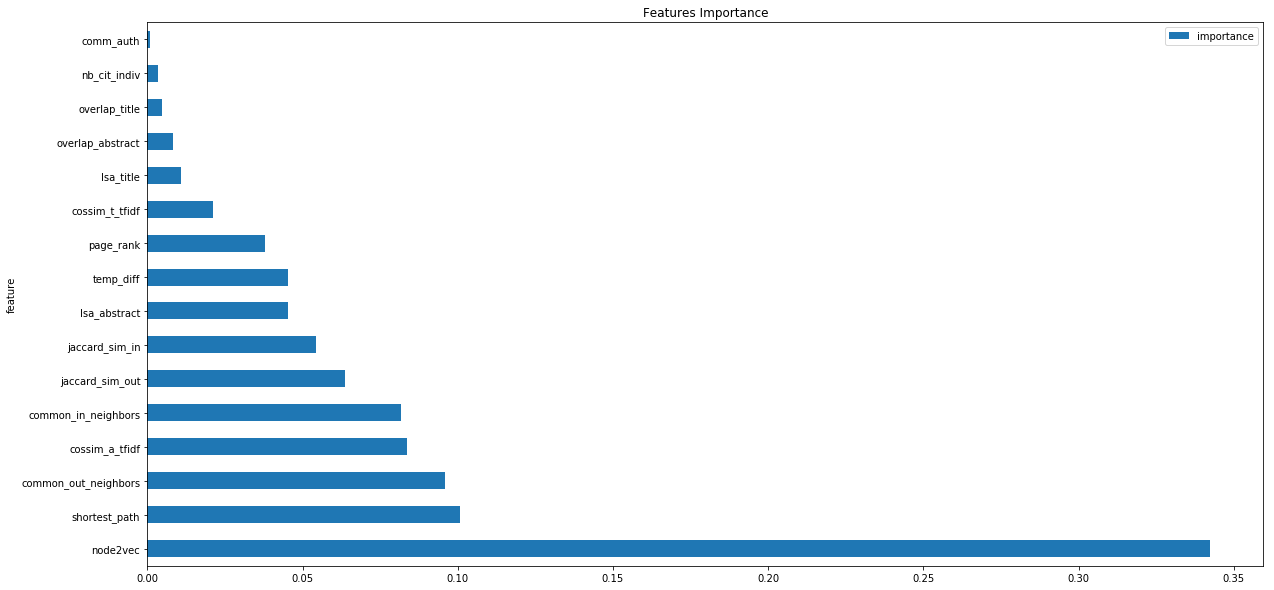

In [348]:
features = pd.DataFrame()
features['feature'] = X.columns
features['importance'] = model_rf.feature_importances_
features.sort_values(by=['importance'], ascending=False, inplace=True)
features.set_index('feature', inplace=True)
features_top.plot(kind='barh', figsize=(20, 10))
plt.title('Features Importance')
plt.show()

# 5. Models comparison

In [22]:
tps0=time.clock()

# Classifiers
rf   = RandomForestClassifier()
gbm = GradientBoostingClassifier()
boost = xgb.XGBClassifier()
svm_  = SVC()
logi = LogisticRegression()
nnet=MLPClassifier()
nb = GaussianNB()

# Number of iterations
B=10 # to test the loop : use B=3 instead

# Parameters grids

listMethGrid=[logi,nb, svm_,rf,gbm,boost,nnet]
arrayErreur=np.empty((B,7))

In [23]:
for i in range(B):
    print i
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
    
    # Computation of test error
    for j,method in enumerate(listMethGrid):
        methFit=method.fit(X_train, y_train)
        predictions = methFit.predict(X_test)
        arrayErreur[i,j]=accuracy_score(y_test, predictions)
        
tps1=time.clock()
print("Execution time in mn :",(tps1 - tps0)/60)

dataframeErreur=pd.DataFrame(arrayErreur,columns=["Logit","NB","SVM","RF","GBM","XGB","NNET"])    

0
1
2
3
4
5
6
7
8
9
('Execution time in mn :', 5.1645530499999985)


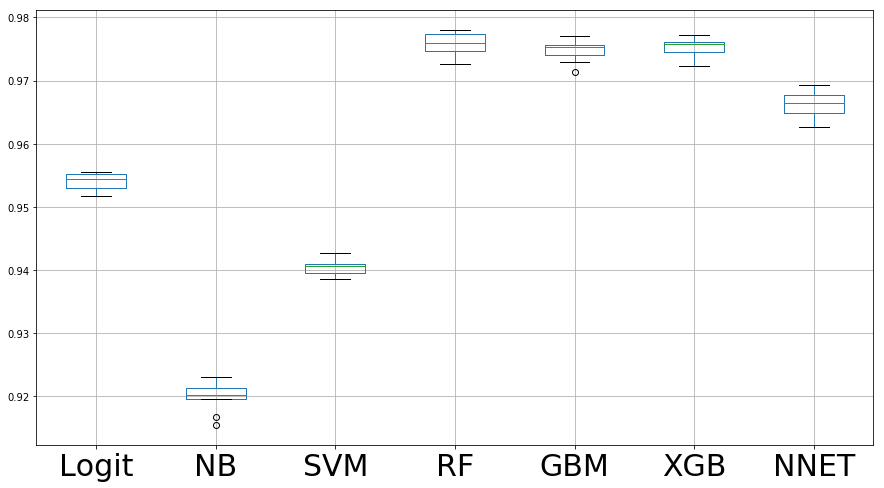

In [24]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(15,8))
dataframeErreur[["Logit","NB","SVM","RF","GBM","XGB","NNET"]].boxplot(return_type='dict')
dataframeErreur.to_csv('dataframeErreur_B10.csv',index=None)
ax.set_xticklabels(["Logit","NB","SVM","RF","GBM","XGB","NNET"],fontsize=30)
plt.show()

# 6. Improvement of the best model: Parameters tuning for random forest

In [248]:
def optimize_rf(X_train,y_train):
    K = 9
    rf=RandomForestClassifier()

    ##### n_estimators
    #Range of parameters
    param=[{"n_estimators":[10,50,100,500]}]
    rForest2= GridSearchCV(RandomForestClassifier(random_state=1),
            param,cv=K,n_jobs=-1)
    rForestOpt=rForest2.fit(X_train,y_train)
    # Optimal parameter
    n_est=rForestOpt.best_params_['n_estimators']
    print ('n_estimators : ',n_est)

    #max_features represents the maximum number of features that will be used in the model
    #Range of parameters
    param=[{"max_features":["auto","sqrt","log2"]}]
    rForest2= GridSearchCV(RandomForestClassifier(n_estimators=n_est,random_state=1),
            param,cv=K,n_jobs=-1)
    rForestOpt=rForest2.fit(X_train,y_train)

    # Optimal parameter
    max_f=rForestOpt.best_params_['max_features']
    print ('max_feature : ', max_f)

    #Range of parameters
    param=[{"min_samples_leaf":[3,5,7,10]}]
    rForest2= GridSearchCV(RandomForestClassifier(n_estimators=n_est,max_features=max_f,random_state=1),
            param,cv=K,n_jobs=-1)
    rForestOpt=rForest2.fit(X_train,y_train)
    # Optimal parameter
    min_sl=rForestOpt.best_params_['min_samples_leaf']
    print ('min_samples_leaf : ', min_sl)


    #Range of parameters
    param=[{"min_samples_split":[5,7,10,15]}]
    rForest2= GridSearchCV(RandomForestClassifier(n_estimators=n_est,max_features=max_f,min_samples_leaf=min_sl,
                                                  random_state=1),
                           param,cv=K,n_jobs=-1)
    rForestOpt=rForest2.fit(X_train,y_train)
    # Optimal parameter
    min_ss=rForestOpt.best_params_['min_samples_split']
    print ('min_samples_split : ', min_ss)


    #Range of parameters
    param=[{"max_depth":[10,50,100,500]}]
    rForest2= GridSearchCV(RandomForestClassifier(n_estimators=n_est,max_features=max_f,min_samples_leaf=min_sl,
                                                 min_samples_split=min_ss,random_state=1),
                           param,cv=K,n_jobs=-1)
    rForestOpt=rForest2.fit(X_train,y_train)
    # Optimal parameter
    max_d=rForestOpt.best_params_['max_depth']
    print ('max_depth : ', max_d)


    ### Model with best parameters
    model=RandomForestClassifier(n_estimators=n_est,max_features=max_f,min_samples_leaf=min_sl,max_depth=max_d,
                            min_samples_split=min_ss,random_state=1)
    return model

In [254]:
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV

def score_cv(model, X, y, scoring='accuracy'):
    s = cross_val_score(model, X, y, cv = 5, scoring=scoring)
    return np.mean(s)

In [265]:
rf_opt = optimize_rf(X, y)
rf_opt.fit(X, y)
print(score_cv(rf_opt,X, y, scoring='accuracy'))

('n_estimators : ', 500)
('max_feature : ', 'auto')
('min_samples_leaf : ', 3)
('min_samples_split : ', 7)
('max_depth : ', 50)
0.9749796465634537


# 7. Predictions

In [271]:
col= ['IDPairs','Edge']
colnames=[i for i in dataset_test.columns if i not in col]
test=dataset_test[colnames]

In [272]:
pred_test = rf_opt.predict(test)
pred_test

array([0, 1, 1, ..., 0, 0, 1])

In [273]:
final_pred = pd.concat([dataset_test['IDPairs'],pd.DataFrame(pred_test)],axis=1)
final_pred.columns = ['id','category']
final_pred.to_csv('../Data/Submissions/final_pred_rf_opt.csv',index=None)